In [1]:
import pandas as pd
import numpy as np
import torch
import matplotlib.pyplot as plt
from transformers import AutoModel, AutoTokenizer
from sklearn.model_selection import train_test_split
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import FeatureUnion, Pipeline
from sklearn.multioutput import MultiOutputClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import precision_score, f1_score, recall_score, classification_report
%matplotlib inline

<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


In [2]:
torch.cuda.is_available()

True

In [3]:
tok = AutoTokenizer.from_pretrained('KB/bert-base-swedish-cased', use_fast=False)
#model = AutoModel.from_pretrained('KB/bert-base-swedish-cased')


In [4]:
#inputs = tok(['hälsa hälsan hälsans'], return_tensors="pt", padding='max_length', max_length = 512, truncation=True)
#inputs = tok(X[:10].values.tolist(), return_tensors="pt", padding='max_length', max_length = 512, truncation=True)

In [5]:
#outputs = model(**inputs)
#outputs = outputs['pooler_output'].detach().numpy().reshape(X.shape[0], -1)

In [3]:
class NLPTransformer(TransformerMixin):
    def __init__(self):
        print('Init called')
        self.model_name = 'KB/bert-base-swedish-cased'
        self.Bert = AutoModel.from_pretrained(self.model_name)
        self.Tokenizer = AutoTokenizer.from_pretrained(self.model_name)
        self.batch_size = 50
        
        #cuda_enabled = torch.cuda.is_available()
        #if cuda_enabled:
        #    device = torch.device('cuda')
        #    self.batch_size = 25
        #else:
        #    device = torch.device('cpu')
        #    self.batch_size = 20

        #self.Bert.to(device)
        #print(f'We are running on device: {device}')
        
        #Freeze the Bert model layers
        for param in self.Bert.parameters():
            param.requires_grad = False
        
        
    def fit(self, X, y=None):
        print('Fit called')
        
        
        return self
    
    def partial_fit(self, X, y=None):
        print('Partial Fit called')

        return self
        
    def transform(self, X):
        print('Transform Called')
        
        #Check device
        device = self.Bert.device
        
        #Preprocess data
        X = X.str.replace('\n','')
        X = X.str.replace('\r','')
        X = X.str.lower()
        X = X.values.tolist()
       
        # Transform input tokens. This is most efficient if done in one batch 
        inputs = self.Tokenizer(X, return_tensors="pt", padding='max_length', max_length = 512, truncation=True)

        # Run Bert model, We must mini batch this in order to not overflow the memory of the system
        transformed = []
        
        batches = int(np.ceil(len(X) / self.batch_size))
        for batchId in range(batches):
            print(f'Running batch {batchId+1}/{batches}')
        
            inputs_batch = {}
            for key in inputs.keys():
                inputs_batch[key] = inputs[key][batchId * self.batch_size:(batchId + 1) * self.batch_size].to(device)
            
            inputs_batch
            outputs = self.Bert(**inputs_batch)
            #inputs = self.Tokenizer(X[batchId * self.batch_size:(batchId + 1) * self.batch_size].values.tolist(), return_tensors="pt", padding='max_length', max_length = 512, truncation=True).to(device)
            #outputs = self.Bert(**inputs)
            #outputs = outputs['pooler_output'].detach().numpy()
            
            outputs = outputs['pooler_output'].to('cpu').detach().numpy()
            print(f'output shape: {outputs.shape}')
            transformed.extend(outputs)
        
        transformed = np.array(transformed)
        print(f'transformed.shape: {transformed.shape}')
        
        return transformed

In [58]:
pipeline = Pipeline([    
            ('nlpTransformer', NLPTransformer()),
            ('clf', RandomForestClassifier())])

Init called


Some weights of the model checkpoint at KB/bert-base-swedish-cased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [5]:
#Read the data

In [4]:
#Test data anonymized
#df = pd.read_csv('../data/CRMIncidents_Anonymized.csv')
df = pd.read_csv('../data/CRMIncidents_Anonymized_Complete_Table.csv')

<ipython-input-4-01876a210620>:3: DtypeWarning: Columns (1,3,5,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,39,41,43,45,47,49,51,52,54,56,57,58) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('../data/CRMIncidents_Anonymized_Complete_Table.csv')


In [5]:
df.head()

,Unnamed: 0.1,Unnamed: 0,CRMIncidentId,IncidentId,LineId,Linje,JourneyId,TurNummer,Trafikslag,Ankomstdag,...,Enhet,Queue_SK,Kö,ModifiedOn,ContactId,Contact_SK,iBID,IsActive,TicketId,Beskrivning_Anonymized
0,0,0,673326.0,77DE23B5-43D8-E811-80F6-005056B63599,-1.0,NaN,-1.0,NaN,NaN,2018-10-25,...,Kundtjänst,8.0,Support Synpunkter,2018-10-29 11:33:19,586769.0,C0BDFF48-2C0B-E811-80F1-005056B64D75,NaN,True,NaN,"Hej,\r\r\n \r\r\nHar nu fått tag i föraren som..."
1,1,1,673354.0,EBD68435-41D8-E811-80F6-005056B63599,-1.0,NaN,-1.0,NaN,NaN,2018-10-25,...,Kundtjänst,8.0,Support Synpunkter,2018-11-08 08:17:09,331145.0,E429FD9A-5DEC-E411-80D6-0050569071BE,NaN,True,NaN,Buss 000 00:00\r\r\n\r\r\nKristianstad Hästtor...
2,2,2,673617.0,3ED0AA37-16D9-E811-80F4-005056B62B18,-1.0,NaN,-1.0,NaN,NaN,2018-10-26,...,Kundtjänst,8.0,Support Synpunkter,2021-10-07 08:49:10,726145.0,12F4B35F-16D9-E811-80F4-005056B62B18,NaN,True,NaN,Skadeanmälan för påkörning av bil bakifrån vid...
3,3,3,673807.0,AAA91AC9-E0D8-E811-80F5-005056B64D75,-1.0,NaN,-1.0,NaN,NaN,2018-10-26,...,Kundtjänst,8.0,Support Synpunkter,2018-11-08 10:36:12,603794.0,56A30A33-A32D-E811-80F2-005056B62B18,NaN,True,NaN,"Hej, \r\r\nVarför heter en av hållplatserna i ..."
4,4,4,673850.0,5F1165E6-63D9-E811-80F5-005056B64D75,-1.0,NaN,-1.0,NaN,NaN,2018-10-26,...,Kundtjänst,8.0,Support Synpunkter,2019-11-27 15:06:13,22229.0,383EAEB1-1DEB-E411-80D8-005056903A38,NaN,True,NaN,Hej!\r\r\nHar en fråga som gäller busskurerna ...


In [6]:
df.columns

Index(['Unnamed: 0.1', 'Unnamed: 0', 'CRMIncidentId', 'IncidentId', 'LineId',
       'Linje', 'JourneyId', 'TurNummer', 'Trafikslag', 'Ankomstdag',
       'Händelsedatum', 'Hanteratdatum', 'Ärendenummer', 'KategoriId11',
       'Kategori11', 'KategoriId12', 'Kategori12', 'KategoriId13',
       'Kategori13', 'KategoriId21', 'Kategori21', 'KategoriId22',
       'Kategori22', 'KategoriId23', 'Kategori23', 'KategoriId31',
       'Kategori31', 'KategoriId32', 'Kategori32', 'KategoriId33',
       'Kategori33', 'KategoriId41', 'Kategori41', 'KategoriId42',
       'Kategori42', 'KategoriId43', 'Kategori43', 'Titel', 'CaseType_SK',
       'Ärendetyp', 'CaseOrigin_SK', 'Ursprung', 'Priority_SK', 'Prioritet',
       'IncidentStage_SK', 'ÄrendeStatus', 'Owner_SK', 'Handläggare',
       'BusinessUnit_SK', 'Enhet', 'Queue_SK', 'Kö', 'ModifiedOn', 'ContactId',
       'Contact_SK', 'iBID', 'IsActive', 'TicketId', 'Beskrivning_Anonymized'],
      dtype='object')

In [7]:
#Remove nans, select relevant columns
df = df[['Ärendetyp', 'Beskrivning_Anonymized', 'Prioritet', 'Ankomstdag']]
df = df[~df['Ärendetyp'].isna()]
df = df[~df['Beskrivning_Anonymized'].isna()]

(array([288232.,  88707.,      0.,   5276.,      0., 160978., 799256.,
             0.,   6202.,   2816.]),
 array([0. , 0.6, 1.2, 1.8, 2.4, 3. , 3.6, 4.2, 4.8, 5.4, 6. ]),
 <BarContainer object of 10 artists>)

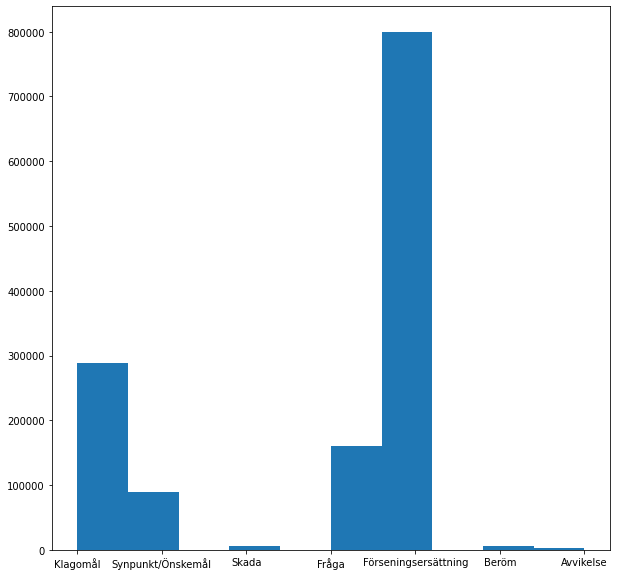

In [8]:
plt.figure(figsize=(10,10))
plt.hist(df['Ärendetyp'])

In [9]:
df['Ärendetyp'].value_counts()

Förseningsersättning    799256
Klagomål                288232
Fråga                   160978
Synpunkt/Önskemål        88707
Beröm                     6202
Skada                     5276
Avvikelse                 2816
Name: Ärendetyp, dtype: int64

In [10]:
df.shape

(1351467, 4)

In [11]:
categories = df['Ärendetyp'].unique()

In [12]:
categories

array(['Klagomål', 'Synpunkt/Önskemål', 'Skada', 'Fråga',
       'Förseningsersättning', 'Beröm', 'Avvikelse'], dtype=object)

In [13]:
#Make a balanced training set
desiredCount = 20000
#desiredCount = 1500
dfBalanced = None
for category in categories:
    sample = df[df['Ärendetyp'] == category].sample(n=desiredCount, replace=True, random_state=42)
    if dfBalanced is None:
        dfBalanced = sample
    else:
        dfBalanced = pd.concat([dfBalanced, sample], ignore_index=True)


#Next random shuffle of all rows
df = dfBalanced.sample(frac=1)

In [14]:
#df = df[:10000] #Max for this computer
df.shape

(140000, 4)

(array([20000., 20000.,     0., 20000.,     0., 20000., 20000.,     0.,
        20000., 20000.]),
 array([0. , 0.6, 1.2, 1.8, 2.4, 3. , 3.6, 4.2, 4.8, 5.4, 6. ]),
 <BarContainer object of 10 artists>)

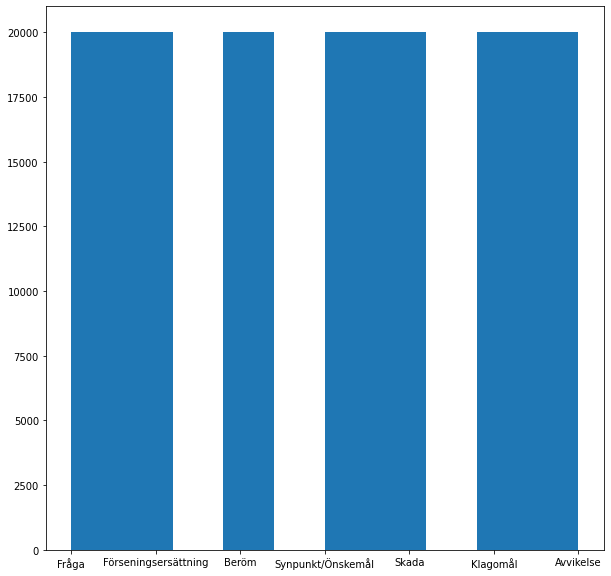

In [15]:
plt.figure(figsize=(10,10))
plt.hist(df['Ärendetyp'])

In [16]:
X = df['Beskrivning_Anonymized'].str.lower() #Lower case to slim the vocabulary

In [17]:
Y = pd.get_dummies(df['Ärendetyp'], columns=['Ärendetyp'])

In [18]:
classes = Y.columns

In [19]:
classes

Index(['Avvikelse', 'Beröm', 'Fråga', 'Förseningsersättning', 'Klagomål',
       'Skada', 'Synpunkt/Önskemål'],
      dtype='object')

In [20]:
Y.shape

(140000, 7)

In [21]:
transformer = NLPTransformer()

Init called


Some weights of the model checkpoint at KB/bert-base-swedish-cased were not used when initializing BertModel: ['cls.predictions.transform.dense.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [24]:
X.shape

(140000,)

In [25]:
Y.shape

(140000, 7)

In [23]:
Y.to_pickle('targets.pkl')

In [26]:
X_transformed = transformer.transform(X)

Transform Called
Running batch 1/2800
output shape: (50, 768)
Running batch 2/2800
output shape: (50, 768)
Running batch 3/2800
output shape: (50, 768)
Running batch 4/2800
output shape: (50, 768)
Running batch 5/2800
output shape: (50, 768)
Running batch 6/2800
output shape: (50, 768)
Running batch 7/2800
output shape: (50, 768)
Running batch 8/2800
output shape: (50, 768)
Running batch 9/2800
output shape: (50, 768)
Running batch 10/2800
output shape: (50, 768)
Running batch 11/2800
output shape: (50, 768)
Running batch 12/2800
output shape: (50, 768)
Running batch 13/2800
output shape: (50, 768)
Running batch 14/2800
output shape: (50, 768)
Running batch 15/2800
output shape: (50, 768)
Running batch 16/2800
output shape: (50, 768)
Running batch 17/2800
output shape: (50, 768)
Running batch 18/2800
output shape: (50, 768)
Running batch 19/2800
output shape: (50, 768)
Running batch 20/2800
output shape: (50, 768)
Running batch 21/2800
output shape: (50, 768)
Running batch 22/2800
outp

output shape: (50, 768)
Running batch 178/2800
output shape: (50, 768)
Running batch 179/2800
output shape: (50, 768)
Running batch 180/2800
output shape: (50, 768)
Running batch 181/2800
output shape: (50, 768)
Running batch 182/2800
output shape: (50, 768)
Running batch 183/2800
output shape: (50, 768)
Running batch 184/2800
output shape: (50, 768)
Running batch 185/2800
output shape: (50, 768)
Running batch 186/2800
output shape: (50, 768)
Running batch 187/2800
output shape: (50, 768)
Running batch 188/2800
output shape: (50, 768)
Running batch 189/2800
output shape: (50, 768)
Running batch 190/2800
output shape: (50, 768)
Running batch 191/2800
output shape: (50, 768)
Running batch 192/2800
output shape: (50, 768)
Running batch 193/2800
output shape: (50, 768)
Running batch 194/2800
output shape: (50, 768)
Running batch 195/2800
output shape: (50, 768)
Running batch 196/2800
output shape: (50, 768)
Running batch 197/2800
output shape: (50, 768)
Running batch 198/2800
output shape:

output shape: (50, 768)
Running batch 353/2800
output shape: (50, 768)
Running batch 354/2800
output shape: (50, 768)
Running batch 355/2800
output shape: (50, 768)
Running batch 356/2800
output shape: (50, 768)
Running batch 357/2800
output shape: (50, 768)
Running batch 358/2800
output shape: (50, 768)
Running batch 359/2800
output shape: (50, 768)
Running batch 360/2800
output shape: (50, 768)
Running batch 361/2800
output shape: (50, 768)
Running batch 362/2800
output shape: (50, 768)
Running batch 363/2800
output shape: (50, 768)
Running batch 364/2800
output shape: (50, 768)
Running batch 365/2800
output shape: (50, 768)
Running batch 366/2800
output shape: (50, 768)
Running batch 367/2800
output shape: (50, 768)
Running batch 368/2800
output shape: (50, 768)
Running batch 369/2800
output shape: (50, 768)
Running batch 370/2800
output shape: (50, 768)
Running batch 371/2800
output shape: (50, 768)
Running batch 372/2800
output shape: (50, 768)
Running batch 373/2800
output shape:

output shape: (50, 768)
Running batch 528/2800
output shape: (50, 768)
Running batch 529/2800
output shape: (50, 768)
Running batch 530/2800
output shape: (50, 768)
Running batch 531/2800
output shape: (50, 768)
Running batch 532/2800
output shape: (50, 768)
Running batch 533/2800
output shape: (50, 768)
Running batch 534/2800
output shape: (50, 768)
Running batch 535/2800
output shape: (50, 768)
Running batch 536/2800
output shape: (50, 768)
Running batch 537/2800
output shape: (50, 768)
Running batch 538/2800
output shape: (50, 768)
Running batch 539/2800
output shape: (50, 768)
Running batch 540/2800
output shape: (50, 768)
Running batch 541/2800
output shape: (50, 768)
Running batch 542/2800
output shape: (50, 768)
Running batch 543/2800
output shape: (50, 768)
Running batch 544/2800
output shape: (50, 768)
Running batch 545/2800
output shape: (50, 768)
Running batch 546/2800
output shape: (50, 768)
Running batch 547/2800
output shape: (50, 768)
Running batch 548/2800
output shape:

output shape: (50, 768)
Running batch 703/2800
output shape: (50, 768)
Running batch 704/2800
output shape: (50, 768)
Running batch 705/2800
output shape: (50, 768)
Running batch 706/2800
output shape: (50, 768)
Running batch 707/2800
output shape: (50, 768)
Running batch 708/2800
output shape: (50, 768)
Running batch 709/2800
output shape: (50, 768)
Running batch 710/2800
output shape: (50, 768)
Running batch 711/2800
output shape: (50, 768)
Running batch 712/2800
output shape: (50, 768)
Running batch 713/2800
output shape: (50, 768)
Running batch 714/2800
output shape: (50, 768)
Running batch 715/2800
output shape: (50, 768)
Running batch 716/2800
output shape: (50, 768)
Running batch 717/2800
output shape: (50, 768)
Running batch 718/2800
output shape: (50, 768)
Running batch 719/2800
output shape: (50, 768)
Running batch 720/2800
output shape: (50, 768)
Running batch 721/2800
output shape: (50, 768)
Running batch 722/2800
output shape: (50, 768)
Running batch 723/2800
output shape:

output shape: (50, 768)
Running batch 878/2800
output shape: (50, 768)
Running batch 879/2800
output shape: (50, 768)
Running batch 880/2800
output shape: (50, 768)
Running batch 881/2800
output shape: (50, 768)
Running batch 882/2800
output shape: (50, 768)
Running batch 883/2800
output shape: (50, 768)
Running batch 884/2800
output shape: (50, 768)
Running batch 885/2800
output shape: (50, 768)
Running batch 886/2800
output shape: (50, 768)
Running batch 887/2800
output shape: (50, 768)
Running batch 888/2800
output shape: (50, 768)
Running batch 889/2800
output shape: (50, 768)
Running batch 890/2800
output shape: (50, 768)
Running batch 891/2800
output shape: (50, 768)
Running batch 892/2800
output shape: (50, 768)
Running batch 893/2800
output shape: (50, 768)
Running batch 894/2800
output shape: (50, 768)
Running batch 895/2800
output shape: (50, 768)
Running batch 896/2800
output shape: (50, 768)
Running batch 897/2800
output shape: (50, 768)
Running batch 898/2800
output shape:

output shape: (50, 768)
Running batch 1052/2800
output shape: (50, 768)
Running batch 1053/2800
output shape: (50, 768)
Running batch 1054/2800
output shape: (50, 768)
Running batch 1055/2800
output shape: (50, 768)
Running batch 1056/2800
output shape: (50, 768)
Running batch 1057/2800
output shape: (50, 768)
Running batch 1058/2800
output shape: (50, 768)
Running batch 1059/2800
output shape: (50, 768)
Running batch 1060/2800
output shape: (50, 768)
Running batch 1061/2800
output shape: (50, 768)
Running batch 1062/2800
output shape: (50, 768)
Running batch 1063/2800
output shape: (50, 768)
Running batch 1064/2800
output shape: (50, 768)
Running batch 1065/2800
output shape: (50, 768)
Running batch 1066/2800
output shape: (50, 768)
Running batch 1067/2800
output shape: (50, 768)
Running batch 1068/2800
output shape: (50, 768)
Running batch 1069/2800
output shape: (50, 768)
Running batch 1070/2800
output shape: (50, 768)
Running batch 1071/2800
output shape: (50, 768)
Running batch 10

output shape: (50, 768)
Running batch 1223/2800
output shape: (50, 768)
Running batch 1224/2800
output shape: (50, 768)
Running batch 1225/2800
output shape: (50, 768)
Running batch 1226/2800
output shape: (50, 768)
Running batch 1227/2800
output shape: (50, 768)
Running batch 1228/2800
output shape: (50, 768)
Running batch 1229/2800
output shape: (50, 768)
Running batch 1230/2800
output shape: (50, 768)
Running batch 1231/2800
output shape: (50, 768)
Running batch 1232/2800
output shape: (50, 768)
Running batch 1233/2800
output shape: (50, 768)
Running batch 1234/2800
output shape: (50, 768)
Running batch 1235/2800
output shape: (50, 768)
Running batch 1236/2800
output shape: (50, 768)
Running batch 1237/2800
output shape: (50, 768)
Running batch 1238/2800
output shape: (50, 768)
Running batch 1239/2800
output shape: (50, 768)
Running batch 1240/2800
output shape: (50, 768)
Running batch 1241/2800
output shape: (50, 768)
Running batch 1242/2800
output shape: (50, 768)
Running batch 12

output shape: (50, 768)
Running batch 1394/2800
output shape: (50, 768)
Running batch 1395/2800
output shape: (50, 768)
Running batch 1396/2800
output shape: (50, 768)
Running batch 1397/2800
output shape: (50, 768)
Running batch 1398/2800
output shape: (50, 768)
Running batch 1399/2800
output shape: (50, 768)
Running batch 1400/2800
output shape: (50, 768)
Running batch 1401/2800
output shape: (50, 768)
Running batch 1402/2800
output shape: (50, 768)
Running batch 1403/2800
output shape: (50, 768)
Running batch 1404/2800
output shape: (50, 768)
Running batch 1405/2800
output shape: (50, 768)
Running batch 1406/2800
output shape: (50, 768)
Running batch 1407/2800
output shape: (50, 768)
Running batch 1408/2800
output shape: (50, 768)
Running batch 1409/2800
output shape: (50, 768)
Running batch 1410/2800
output shape: (50, 768)
Running batch 1411/2800
output shape: (50, 768)
Running batch 1412/2800
output shape: (50, 768)
Running batch 1413/2800
output shape: (50, 768)
Running batch 14

output shape: (50, 768)
Running batch 1565/2800
output shape: (50, 768)
Running batch 1566/2800
output shape: (50, 768)
Running batch 1567/2800
output shape: (50, 768)
Running batch 1568/2800
output shape: (50, 768)
Running batch 1569/2800
output shape: (50, 768)
Running batch 1570/2800
output shape: (50, 768)
Running batch 1571/2800
output shape: (50, 768)
Running batch 1572/2800
output shape: (50, 768)
Running batch 1573/2800
output shape: (50, 768)
Running batch 1574/2800
output shape: (50, 768)
Running batch 1575/2800
output shape: (50, 768)
Running batch 1576/2800
output shape: (50, 768)
Running batch 1577/2800
output shape: (50, 768)
Running batch 1578/2800
output shape: (50, 768)
Running batch 1579/2800
output shape: (50, 768)
Running batch 1580/2800
output shape: (50, 768)
Running batch 1581/2800
output shape: (50, 768)
Running batch 1582/2800
output shape: (50, 768)
Running batch 1583/2800
output shape: (50, 768)
Running batch 1584/2800
output shape: (50, 768)
Running batch 15

output shape: (50, 768)
Running batch 1736/2800
output shape: (50, 768)
Running batch 1737/2800
output shape: (50, 768)
Running batch 1738/2800
output shape: (50, 768)
Running batch 1739/2800
output shape: (50, 768)
Running batch 1740/2800
output shape: (50, 768)
Running batch 1741/2800
output shape: (50, 768)
Running batch 1742/2800
output shape: (50, 768)
Running batch 1743/2800
output shape: (50, 768)
Running batch 1744/2800
output shape: (50, 768)
Running batch 1745/2800
output shape: (50, 768)
Running batch 1746/2800
output shape: (50, 768)
Running batch 1747/2800
output shape: (50, 768)
Running batch 1748/2800
output shape: (50, 768)
Running batch 1749/2800
output shape: (50, 768)
Running batch 1750/2800
output shape: (50, 768)
Running batch 1751/2800
output shape: (50, 768)
Running batch 1752/2800
output shape: (50, 768)
Running batch 1753/2800
output shape: (50, 768)
Running batch 1754/2800
output shape: (50, 768)
Running batch 1755/2800
output shape: (50, 768)
Running batch 17

output shape: (50, 768)
Running batch 1907/2800
output shape: (50, 768)
Running batch 1908/2800
output shape: (50, 768)
Running batch 1909/2800
output shape: (50, 768)
Running batch 1910/2800
output shape: (50, 768)
Running batch 1911/2800
output shape: (50, 768)
Running batch 1912/2800
output shape: (50, 768)
Running batch 1913/2800
output shape: (50, 768)
Running batch 1914/2800
output shape: (50, 768)
Running batch 1915/2800
output shape: (50, 768)
Running batch 1916/2800
output shape: (50, 768)
Running batch 1917/2800
output shape: (50, 768)
Running batch 1918/2800
output shape: (50, 768)
Running batch 1919/2800
output shape: (50, 768)
Running batch 1920/2800
output shape: (50, 768)
Running batch 1921/2800
output shape: (50, 768)
Running batch 1922/2800
output shape: (50, 768)
Running batch 1923/2800
output shape: (50, 768)
Running batch 1924/2800
output shape: (50, 768)
Running batch 1925/2800
output shape: (50, 768)
Running batch 1926/2800
output shape: (50, 768)
Running batch 19

output shape: (50, 768)
Running batch 2078/2800
output shape: (50, 768)
Running batch 2079/2800
output shape: (50, 768)
Running batch 2080/2800
output shape: (50, 768)
Running batch 2081/2800
output shape: (50, 768)
Running batch 2082/2800
output shape: (50, 768)
Running batch 2083/2800
output shape: (50, 768)
Running batch 2084/2800
output shape: (50, 768)
Running batch 2085/2800
output shape: (50, 768)
Running batch 2086/2800
output shape: (50, 768)
Running batch 2087/2800
output shape: (50, 768)
Running batch 2088/2800
output shape: (50, 768)
Running batch 2089/2800
output shape: (50, 768)
Running batch 2090/2800
output shape: (50, 768)
Running batch 2091/2800
output shape: (50, 768)
Running batch 2092/2800
output shape: (50, 768)
Running batch 2093/2800
output shape: (50, 768)
Running batch 2094/2800
output shape: (50, 768)
Running batch 2095/2800
output shape: (50, 768)
Running batch 2096/2800
output shape: (50, 768)
Running batch 2097/2800
output shape: (50, 768)
Running batch 20

output shape: (50, 768)
Running batch 2249/2800
output shape: (50, 768)
Running batch 2250/2800
output shape: (50, 768)
Running batch 2251/2800
output shape: (50, 768)
Running batch 2252/2800
output shape: (50, 768)
Running batch 2253/2800
output shape: (50, 768)
Running batch 2254/2800
output shape: (50, 768)
Running batch 2255/2800
output shape: (50, 768)
Running batch 2256/2800
output shape: (50, 768)
Running batch 2257/2800
output shape: (50, 768)
Running batch 2258/2800
output shape: (50, 768)
Running batch 2259/2800
output shape: (50, 768)
Running batch 2260/2800
output shape: (50, 768)
Running batch 2261/2800
output shape: (50, 768)
Running batch 2262/2800
output shape: (50, 768)
Running batch 2263/2800
output shape: (50, 768)
Running batch 2264/2800
output shape: (50, 768)
Running batch 2265/2800
output shape: (50, 768)
Running batch 2266/2800
output shape: (50, 768)
Running batch 2267/2800
output shape: (50, 768)
Running batch 2268/2800
output shape: (50, 768)
Running batch 22

output shape: (50, 768)
Running batch 2420/2800
output shape: (50, 768)
Running batch 2421/2800
output shape: (50, 768)
Running batch 2422/2800
output shape: (50, 768)
Running batch 2423/2800
output shape: (50, 768)
Running batch 2424/2800
output shape: (50, 768)
Running batch 2425/2800
output shape: (50, 768)
Running batch 2426/2800
output shape: (50, 768)
Running batch 2427/2800
output shape: (50, 768)
Running batch 2428/2800
output shape: (50, 768)
Running batch 2429/2800
output shape: (50, 768)
Running batch 2430/2800
output shape: (50, 768)
Running batch 2431/2800
output shape: (50, 768)
Running batch 2432/2800
output shape: (50, 768)
Running batch 2433/2800
output shape: (50, 768)
Running batch 2434/2800
output shape: (50, 768)
Running batch 2435/2800
output shape: (50, 768)
Running batch 2436/2800
output shape: (50, 768)
Running batch 2437/2800
output shape: (50, 768)
Running batch 2438/2800
output shape: (50, 768)
Running batch 2439/2800
output shape: (50, 768)
Running batch 24

output shape: (50, 768)
Running batch 2591/2800
output shape: (50, 768)
Running batch 2592/2800
output shape: (50, 768)
Running batch 2593/2800
output shape: (50, 768)
Running batch 2594/2800
output shape: (50, 768)
Running batch 2595/2800
output shape: (50, 768)
Running batch 2596/2800
output shape: (50, 768)
Running batch 2597/2800
output shape: (50, 768)
Running batch 2598/2800
output shape: (50, 768)
Running batch 2599/2800
output shape: (50, 768)
Running batch 2600/2800
output shape: (50, 768)
Running batch 2601/2800
output shape: (50, 768)
Running batch 2602/2800
output shape: (50, 768)
Running batch 2603/2800
output shape: (50, 768)
Running batch 2604/2800
output shape: (50, 768)
Running batch 2605/2800
output shape: (50, 768)
Running batch 2606/2800
output shape: (50, 768)
Running batch 2607/2800
output shape: (50, 768)
Running batch 2608/2800
output shape: (50, 768)
Running batch 2609/2800
output shape: (50, 768)
Running batch 2610/2800
output shape: (50, 768)
Running batch 26

output shape: (50, 768)
Running batch 2762/2800
output shape: (50, 768)
Running batch 2763/2800
output shape: (50, 768)
Running batch 2764/2800
output shape: (50, 768)
Running batch 2765/2800
output shape: (50, 768)
Running batch 2766/2800
output shape: (50, 768)
Running batch 2767/2800
output shape: (50, 768)
Running batch 2768/2800
output shape: (50, 768)
Running batch 2769/2800
output shape: (50, 768)
Running batch 2770/2800
output shape: (50, 768)
Running batch 2771/2800
output shape: (50, 768)
Running batch 2772/2800
output shape: (50, 768)
Running batch 2773/2800
output shape: (50, 768)
Running batch 2774/2800
output shape: (50, 768)
Running batch 2775/2800
output shape: (50, 768)
Running batch 2776/2800
output shape: (50, 768)
Running batch 2777/2800
output shape: (50, 768)
Running batch 2778/2800
output shape: (50, 768)
Running batch 2779/2800
output shape: (50, 768)
Running batch 2780/2800
output shape: (50, 768)
Running batch 2781/2800
output shape: (50, 768)
Running batch 27

In [6]:
X_transformed.shape

(140000, 768)

In [28]:
np.save('transformed_data.pkl', X_transformed)

In [5]:
#read back the data
X_transformed = np.load('transformed_data.pkl.npy')

In [9]:
Y = pd.read_pickle('targets.pkl')

In [11]:
#Note in case of pytorch CrossEntropyLoss, the targets should be the class index, not one hot encoded
Y = Y.values.argmax(axis=1)


In [12]:
Y

array([2, 2, 2, ..., 6, 5, 1], dtype=int64)

In [13]:
Y.max()

6

In [62]:
#This could also be a target
Y2 = pd.get_dummies(df['Prioritet'], columns=['Prioritet'])

In [63]:
Y2.head()

,Hög,Normal
0,0,1
1,0,1
2,1,0
3,0,1
4,0,1


In [21]:
X.head()

0    hej,\r\n \r\nhar nu fått tag i föraren som är ...
1    buss 000 00:00\r\n\r\nkristianstad hästtorget ...
2    skadeanmälan för påkörning av bil bakifrån vid...
3    hej, \r\nvarför heter en av hållplatserna i lu...
4    hej!\r\nhar en fråga som gäller busskurerna i ...
Name: Beskrivning_Anonymized, dtype: object

In [22]:
X[3]

'hej, \r\nvarför heter en av hållplatserna i ludvigsborg kvarndamms gatan i hörby kommun, skåne? dels så finns det ingen väg som heter så där, den heter kvarndamsvägen. dessutom är hållplatsen på ludvigsborgsvägen. xxxx ni vidarebefordra detta till rätt avdelning så det blir ändrat för att inte göra det förvirrat för resenärerna?\r\nhälsningar fredrik\r\r\n'

In [23]:
Y.head()

,Avvikelse,Beröm,Fråga,Förseningsersättning,Klagomål,Skada,Synpunkt/Önskemål
0,0,0,0,0,1,0,0
1,0,0,0,0,0,0,1
2,0,0,0,0,0,1,0
3,0,0,0,0,1,0,0
4,0,0,1,0,0,0,0


In [24]:
inputs = tok('hej, Har nu fått tag i föraren som är', return_tensors="pt", padding='max_length', max_length = 512, truncation=True)

In [25]:
inputs

{'input_ids': tensor([[    2,  8819,    19,  1177,   346,   902,  1326,    31, 15367,    67,
            54,     3,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,  

In [12]:
#Test train split

In [56]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

In [57]:
X_train.shape

(8400,)

In [24]:
Y_train[:5]

,Avvikelse,Beröm,Fråga,Förseningsersättning,Klagomål,Skada,Synpunkt/Önskemål
935,1,0,0,0,0,0,0
1009,1,0,0,0,0,0,0
262,0,0,0,0,0,0,1
931,1,0,0,0,0,0,0
814,0,1,0,0,0,0,0


In [13]:
class MiniBatcher():
    def __init__(self, X, Y, batch_size=100):
        self.X = X
        self.Y = Y
        self.batch_size = batch_size
        self.batchId = 0     
        
    def getBatchIterator(self):
        self.batchId = 0
        self.epochId = 0
        
        while True:
            X_mini = self.X[self.batchId * self.batch_size:(self.batchId + 1) * self.batch_size]
            Y_mini = self.Y[self.batchId * self.batch_size:(self.batchId + 1) * self.batch_size]
            self.batchId += 1

            if len(X_mini) < self.batch_size:               
                self.batchId = 0
                break
            
            yield X_mini, Y_mini
            
    def getBatchInfo(self):
        return f'batch: {self.batchId}/{int(np.ceil(self.X.shape[0] / self.batch_size))}'

In [61]:
mMiniBatcher = MiniBatcher(X_train, Y_train)

NameError: name 'X_train' is not defined

In [31]:
batchIterator = mMiniBatcher.getBatchIterator()

In [59]:
#Train the model
#output = pipeline.fit(X_train[:25], Y_train[:25].values)
#output = pipeline.fit(X_train[:1500], Y_train[:1500].values)
output = pipeline.fit(X_train, Y_train.values)

Fit called
Transform Called
Running batch 1/168
output shape: (50, 768)
Running batch 2/168
output shape: (50, 768)
Running batch 3/168
output shape: (50, 768)
Running batch 4/168
output shape: (50, 768)
Running batch 5/168
output shape: (50, 768)
Running batch 6/168
output shape: (50, 768)
Running batch 7/168
output shape: (50, 768)
Running batch 8/168
output shape: (50, 768)
Running batch 9/168
output shape: (50, 768)
Running batch 10/168
output shape: (50, 768)
Running batch 11/168
output shape: (50, 768)
Running batch 12/168
output shape: (50, 768)
Running batch 13/168
output shape: (50, 768)
Running batch 14/168
output shape: (50, 768)
Running batch 15/168
output shape: (50, 768)
Running batch 16/168
output shape: (50, 768)
Running batch 17/168
output shape: (50, 768)
Running batch 18/168
output shape: (50, 768)
Running batch 19/168
output shape: (50, 768)
Running batch 20/168
output shape: (50, 768)
Running batch 21/168
output shape: (50, 768)
Running batch 22/168
output shape: (

In [ ]:
output.predict(X_test[:10])

In [135]:
probs = output.predict_proba(X_test[:15])

Transform Called
Running batch 1/2
output shape: (10, 768)
Running batch 2/2
output shape: (5, 768)
transformed.shape: (15, 768)


In [53]:
Y_test[:3].values

array([[0, 0, 1, 0, 0],
       [1, 0, 0, 0, 0],
       [0, 1, 0, 0, 0]], dtype=uint8)

In [75]:
Y_test[:15]

,Avvikelse,Beröm,Fråga,Förseningsersättning,Klagomål,Skada,Synpunkt/Önskemål
521,0,0,1,0,0,0,0
941,0,0,0,0,0,0,1
741,0,0,1,0,0,0,0
980,0,0,0,0,0,0,1
411,0,0,0,0,0,0,1
679,0,0,1,0,0,0,0
673,0,0,0,0,0,0,1
513,0,0,0,0,1,0,0
773,0,0,0,0,1,0,0
136,0,0,0,0,0,0,1


In [33]:
#This will predict the classes for each row. The class with the highest probability is selected
def PredictClasses(model, X):
    probs = model.predict_proba(X)
    probs = np.array(probs) #List to (N, num_classes, 2)
    predictedClasses = np.argmax(probs[:,:,1].T, axis=1) #First index classifies it as 0, second as 1, Then get the max index for each row
    
    return predictedClasses
    
    
    

In [105]:
X[3]

'hej, \r\nvarför heter en av hållplatserna i ludvigsborg kvarndamms gatan i hörby kommun, skåne? dels så finns det ingen väg som heter så där, den heter kvarndamsvägen. dessutom är hållplatsen på ludvigsborgsvägen. xxxx ni vidarebefordra detta till rätt avdelning så det blir ändrat för att inte göra det förvirrat för resenärerna?\r\nhälsningar fredrik\r\r\n'

In [31]:
result = PredictClasses(pipeline, X_test[10:20])

Transform Called
Running batch 1/1
output shape: (10, 768)
transformed.shape: (10, 768)


In [29]:
result

array([3, 3, 3, 3, 3, 3, 6, 3, 3, 2], dtype=int64)

In [32]:
Y_test[10:20]

,Avvikelse,Beröm,Fråga,Förseningsersättning,Klagomål,Skada,Synpunkt/Önskemål
2750,0,0,0,1,0,0,0
7487,0,0,0,1,0,0,0
5272,0,0,0,1,0,0,0
5653,0,0,0,1,0,0,0
3999,0,0,0,1,0,0,0
6033,0,0,0,1,0,0,0
582,0,0,0,0,1,0,0
9930,0,0,0,1,0,0,0
7051,0,0,0,1,0,0,0
8158,0,0,0,1,0,0,0


In [38]:
result

array([3, 3, 3, 3, 3, 3, 6, 3, 3, 3], dtype=int64)

In [41]:
ost = Y_test[10:20].to_numpy().argmax(axis=1)
ost

array([3, 3, 3, 3, 3, 3, 4, 3, 3, 3], dtype=int64)

In [51]:
result.shape

(10,)

In [77]:
cm = confusion_matrix(ost, result,normalize='true')
cm

array([[1., 0., 0.],
       [0., 0., 1.],
       [0., 0., 0.]])

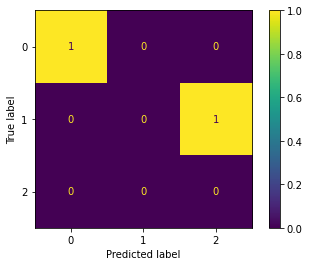

In [78]:
ConfusionMatrixDisplay(confusion_matrix=cm,).plot()

In [61]:
confusion_matrix(ost, result)

array([[9, 0, 0],
       [0, 0, 1],
       [0, 0, 0]], dtype=int64)

In [62]:
#results = PredictClasses(pipeline, X_test[:15])
results = PredictClasses(pipeline, X_test)
results

Transform Called
Running batch 1/200


KeyboardInterrupt: 

In [85]:
results

array([4, 6, 4, 6, 6, 6, 4, 4, 6, 4, 6, 4, 6, 6, 6, 6, 6, 2, 4, 6, 6, 2,
       2, 4, 4, 4, 4, 6, 2, 4, 4, 6, 6, 6, 4, 4, 6, 2, 6, 4, 4, 4, 3, 6,
       4, 6, 2, 6, 2, 6, 6, 2, 6, 6, 4, 6, 4, 4, 4, 6, 4, 4, 4, 6, 6, 6,
       6, 2, 4, 6, 6, 6, 6, 6, 4, 4, 2, 4, 6, 4, 6, 4, 2, 6, 4, 2, 6, 6,
       2, 2, 4, 4, 4, 4, 6, 4, 4, 4, 4, 6, 6, 4, 4, 2, 2, 6, 4, 4, 3, 6,
       6, 4, 6, 6, 4, 4, 6, 6, 6, 4, 6, 6, 6, 2, 4, 6, 6, 4, 6, 6, 6, 6,
       6, 6, 6, 4, 4, 4, 6, 4, 4, 6, 6, 4, 6, 2, 6, 4, 2, 4, 4, 2, 6, 2,
       6, 6, 2, 6, 4, 6, 6, 4, 6, 6, 2, 6, 4, 6, 3, 4, 4, 4, 2, 6, 4, 4,
       6, 2, 6, 2, 4, 6, 4, 2, 6, 2, 4, 6, 6, 6, 4, 6, 6, 4, 2, 6, 6, 2,
       6, 2, 6], dtype=int64)

In [89]:
targets = np.argmax(np.array(Y), axis=1)
targets

array([4, 6, 5, ..., 4, 4, 2], dtype=int64)

In [37]:
Y_test.columns

Index(['Avvikelse', 'Beröm', 'Fråga', 'Förseningsersättning', 'Klagomål',
       'Skada', 'Synpunkt/Önskemål'],
      dtype='object')

In [41]:
Y_test.columns.shape

(7,)

In [45]:
def EvaluateModelUsingProbs(model, X_test, Y_test):
    Y_pred = PredictClasses(model, X_test) #1D-array with classes
    targets = np.argmax(np.array(Y_test), axis=1) #1D-array with classes
    
    total_hits = np.sum(np.sum(Y_pred == targets))
    total_misses = np.sum(np.sum(Y_pred != targets))
    total_accuracy = total_hits/(total_hits + total_misses)
    print(f'Total Accuracy: {total_accuracy}')
    #cm = confusion_matrix(targets, Y_pred, normalize='true')
    #ConfusionMatrixDisplay(confusion_matrix=cm,).plot()
    cm = confusion_matrix(targets, Y_pred, normalize='true', labels=list(range(Y_test.columns.shape[0])))
    ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=list(range(Y_test.columns.shape[0]))).plot()
    

In [35]:
#Evaluate the model and print the accuracy

def EvaluateModel(model, X_test, Y_test):
    Y_pred = model.predict(X_test)
    
    total_hits = np.sum(np.sum(Y_pred == Y_test))
    total_misses = np.sum(np.sum(Y_pred != Y_test))
    total_accuracy = total_hits/(total_hits + total_misses)
       
    target_names = [name for name in Y.columns]

    precisions = []
    recalls = []
    f1scores = []
    for (name, col) in zip(target_names, range(len(target_names))):
        y_test = Y_test[name].values
        y_pred = Y_pred[:, col]
        
        if(np.max(y_test) <= 1):
            #Only one category
            precisions.append(precision_score(y_test, y_pred))
            recalls.append(recall_score(y_test, y_pred))
            f1scores.append(f1_score(y_test, y_pred))
        print(f'Category: {name}')
        print(classification_report(y_test, y_pred))
        print('-'*42)
     
    
    print(f'Total Accuracy: {total_accuracy}')
    print(f'Average Precission: {np.average(precisions)}')
    print(f'Average Recall: {np.average(recalls)}')
    print(f'Average F1 Score: {np.average(f1scores)}')

In [88]:
EvaluateModel(pipeline, X_test[:100], Y_test[:100])

Transform Called
Running batch 1/10
output shape: (10, 768)
Running batch 2/10
output shape: (10, 768)
Running batch 3/10
output shape: (10, 768)
Running batch 4/10
output shape: (10, 768)
Running batch 5/10
output shape: (10, 768)
Running batch 6/10
output shape: (10, 768)
Running batch 7/10
output shape: (10, 768)
Running batch 8/10
output shape: (10, 768)
Running batch 9/10
output shape: (10, 768)
Running batch 10/10
output shape: (10, 768)
transformed.shape: (100, 768)
Category: Avvikelse
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       100

    accuracy                           1.00       100
   macro avg       1.00      1.00      1.00       100
weighted avg       1.00      1.00      1.00       100

------------------------------------------
Category: Beröm
              precision    recall  f1-score   support

           0       0.99      1.00      0.99        99
           1       0.00      0.00      0.00         1

    ac

C:\ProgramData\Anaconda3\envs\dataScience\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\envs\dataScience\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\envs\dataScience\lib\site-packages\sklearn\metrics\_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
C:\ProgramData\Anaconda3\envs\dataScience\lib\site-

Transform Called
Running batch 1/42
output shape: (50, 768)
Running batch 2/42
output shape: (50, 768)
Running batch 3/42
output shape: (50, 768)
Running batch 4/42
output shape: (50, 768)
Running batch 5/42
output shape: (50, 768)
Running batch 6/42
output shape: (50, 768)
Running batch 7/42
output shape: (50, 768)
Running batch 8/42
output shape: (50, 768)
Running batch 9/42
output shape: (50, 768)
Running batch 10/42
output shape: (50, 768)
Running batch 11/42
output shape: (50, 768)
Running batch 12/42
output shape: (50, 768)
Running batch 13/42
output shape: (50, 768)
Running batch 14/42
output shape: (50, 768)
Running batch 15/42
output shape: (50, 768)
Running batch 16/42
output shape: (50, 768)
Running batch 17/42
output shape: (50, 768)
Running batch 18/42
output shape: (50, 768)
Running batch 19/42
output shape: (50, 768)
Running batch 20/42
output shape: (50, 768)
Running batch 21/42
output shape: (50, 768)
Running batch 22/42
output shape: (50, 768)
Running batch 23/42
outp

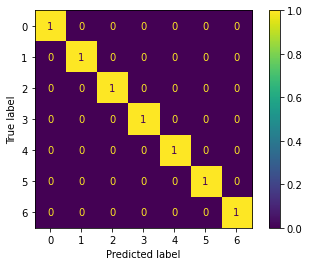

In [60]:
EvaluateModelUsingProbs(pipeline, X_test, Y_test)

In [108]:
EvaluateModelUsingProbs(pipeline, X_train, Y_train)

Transform Called
Running batch 1/80
output shape: (10, 768)
Running batch 2/80
output shape: (10, 768)
Running batch 3/80
output shape: (10, 768)
Running batch 4/80
output shape: (10, 768)
Running batch 5/80
output shape: (10, 768)
Running batch 6/80
output shape: (10, 768)
Running batch 7/80
output shape: (10, 768)
Running batch 8/80
output shape: (10, 768)
Running batch 9/80
output shape: (10, 768)
Running batch 10/80
output shape: (10, 768)
Running batch 11/80
output shape: (10, 768)
Running batch 12/80
output shape: (10, 768)
Running batch 13/80
output shape: (10, 768)
Running batch 14/80
output shape: (10, 768)
Running batch 15/80
output shape: (10, 768)
Running batch 16/80
output shape: (10, 768)
Running batch 17/80
output shape: (10, 768)
Running batch 18/80
output shape: (10, 768)
Running batch 19/80
output shape: (10, 768)
Running batch 20/80
output shape: (10, 768)
Running batch 21/80
output shape: (10, 768)
Running batch 22/80
output shape: (10, 768)
Running batch 23/80
outp

In [104]:
X[:2].values

array(['hej,\r\r\n \r\r\nhar nu fått tag i föraren som är i grekland på semester.\r\r\n \r\r\nden unga killen som frågade fick svaret av föraren att det är läge xxxx som gäller på knutpunkten.\r\r\n\r\r\ndetta gav föraren resenären efter att ha själv letat upp det på skånetrafikens app.\r\r\nmotparten lämnar tyvärr en del information till sin egen fördel.\r\r\nföraren försökte att hjälpa så gott han kunde.\r\r\n \r\r\n\r\r\nmed vänlig hälsning,\r\r\n  xxxx prata\r\r\n\r\r\ngruppchef\r\r\n \r\r\nnobina sverige ab\r\r\n\r\r\nadress: streetname_replaced 00, 000 00 helsingborg\r\r\nmobil:  +00 00 000 00 00\r\r\ndirekt: +00 0 000 000 00\r\r\n\r\r\nväxel:  +00 0 000 000 00\r\r\n\r\r\nhemsida:\r\r\nwww.nobina.com\r\r\n \r\r\nnobina sverige ab, org.nr 000000-0000 | styrelsens säte - stockholm\r\r\n\r\r\np please consider the environment before printing this e-mail.\r\r\n\r\r\n \r\r\n\r\r\nfrån: xxxx prata \r\r\n\r\r\nskickat: den 00 oktober 0000 00:00\r\r\n\r\r\ntill: email@address.replaced em

In [94]:
inputs = X[]

In [95]:
inputs

0    jag vill ha ersättning för min biljett, då tåg...
1                      bussen hade dålig air condition
2    beskrivning i avic:\r\r\n xxxx sjukresebeställ...
dtype: object

In [107]:
PredictClasses(pipeline, X[10:20])

Transform Called
Running batch 1/1
output shape: (10, 768)
transformed.shape: (10, 768)


array([6, 1, 4, 4, 6, 6, 4, 2, 5, 0], dtype=int64)

In [108]:
Y[10:20]

,Avvikelse,Beröm,Fråga,Förseningsersättning,Klagomål,Skada,Synpunkt/Önskemål
10,0,0,1,0,0,0,0
11,0,0,0,0,0,0,1
12,0,0,0,0,0,0,1
13,0,0,0,0,0,0,1
14,0,0,0,0,0,0,1
15,0,0,0,0,1,0,0
16,0,0,0,0,1,0,0
17,0,0,1,0,0,0,0
18,0,0,0,0,1,0,0
19,0,0,0,0,1,0,0


In [140]:
#Save, Load model

In [61]:
from joblib import dump, load

In [62]:
modelName = 'BertModel.joblib'

In [63]:

dump(pipeline, modelName ) 

['BertModel.joblib']

In [18]:
loadedModel = load(modelName) 

In [19]:
loadedModel.predict(X_test[100:120])

Transform Called
Running batch 1/2
output shape: (10, 768)
Running batch 2/2
output shape: (10, 768)
transformed.shape: (20, 768)


array([[0, 0, 0, 0, 0],
       [0, 0, 0, 0, 1],
       [0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0],
       [0, 0, 0, 0, 1],
       [1, 0, 0, 0, 0],
       [0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0],
       [0, 0, 0, 1, 0],
       [0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0],
       [0, 0, 1, 0, 0],
       [0, 0, 1, 0, 0],
       [0, 0, 0, 0, 0],
       [0, 0, 0, 0, 1],
       [0, 0, 0, 1, 0],
       [0, 0, 0, 1, 0],
       [1, 0, 0, 0, 0],
       [0, 0, 0, 0, 0],
       [0, 0, 1, 0, 0]], dtype=uint8)

In [1]:
#Deep learning using pytorch

In [14]:
from torch import nn, optim
import torch.nn.functional as F

class TorchNLP(nn.Module):
    def __init__(self, n_classes):
        super().__init__()
        #print('Init called')
        self.model_name = 'KB/bert-base-swedish-cased'
        self.Bert = AutoModel.from_pretrained(self.model_name)
        self.Tokenizer = AutoTokenizer.from_pretrained(self.model_name)
        self.n_classes = n_classes
        self.TorchModel = nn.Sequential(nn.Linear(768, 256),
                          nn.ReLU(),
                          nn.Dropout(p=0.42),
                          nn.Linear(256, 128),
                          nn.ReLU(),
                          nn.Dropout(p=0.42),              
                          nn.Linear(128, n_classes))
                          #nn.Softmax(dim=1)) Cannot use softmax here since nn.CrossEntropyLoss expects scores!
        
        #Freeze the Bert model layers
        for param in self.Bert.parameters():
            param.requires_grad = False
            
    def forward(self, X):
        #print('Forward Called')
       
        #Check device
        device = self.Bert.device
        
        # Transform input tokens. This is most efficient if done in one batch 
        X = self.Tokenizer(X.values.tolist(), return_tensors="pt", padding='max_length', max_length = 512, truncation=True).to(device)
        
        X = self.Bert(**X)
        X = X['pooler_output']
        X = self.TorchModel(X)
        
        return X
    
    def predict(self, X):
        with torch.no_grad():
            self.eval()
            output = self.forward(X)
            top_p, top_class = output.topk(1, dim=1)
            top_class = top_class.to('cpu').numpy().reshape(-1,)
            self.train()
            return top_class

In [28]:
#This is the slim version where the BERT features is already provided as input
class TorchNLPLight(nn.Module):
    def __init__(self, n_classes):
        super().__init__()
        #print('Init called')
        self.n_classes = n_classes
        self.TorchModel = nn.Sequential(nn.Conv1d(1, 256, 3, stride=1, padding='same'),
                          nn.Flatten(),
                          nn.BatchNorm1d(256*768),              
                          nn.ReLU(),
                          nn.Dropout(p=0.42),
                          nn.Linear(256*768, 1024),
                          nn.BatchNorm1d(1024),              
                          nn.ReLU(),
                          nn.Dropout(p=0.42),
                          nn.Linear(1024, 512),
                          nn.BatchNorm1d(512),
                          nn.ReLU(),
                          nn.Dropout(p=0.42),
                          nn.Linear(512, 256),
                          nn.BatchNorm1d(256),
                          nn.ReLU(),
                          nn.Dropout(p=0.42),            
                          nn.Linear(256, n_classes))
                          #nn.Softmax(dim=1)) Cannot use softmax here since nn.CrossEntropyLoss expects scores!
        
    def forward(self, X):
        #print('Forward Called')
        X = X.reshape(X.shape[0], 1, X.shape[1]) #Reshape for Conv1d
        X = self.TorchModel(X)
        
        return X
    
    def predict(self, X):
        with torch.no_grad():
            self.eval()
            output = self.forward(X)
            #print(f'X.shape: {X.shape}')
            #print(f'output.shape: {output.shape}')
            top_p, top_class = output.topk(1, dim=1)
            top_class = top_class.to('cpu').numpy().reshape(-1,)
            #print(f'top_class.shape: {top_class.shape}')
            self.train()
            return top_class

In [125]:

testModel = nn.Conv1d(1, 768, 3, stride=1, padding='same')

In [107]:
X_transformed[:5].shape

(5, 768)

In [100]:
torch.tensor(X_transformed[:5].reshape(-1,768,1)).shape

torch.Size([5, 768, 1])

In [126]:
testModel(torch.tensor(X_transformed[:5].reshape(-1,1,768))).shape

torch.Size([5, 768, 768])

In [119]:
testModel(torch.tensor(X_transformed[:5].reshape(-1,1,768))).view(5,-1).shape

torch.Size([5, 589824])

In [117]:
768*768

589824

In [29]:
n_classes = Y.max() + 1
torchModelLight = TorchNLPLight(n_classes = n_classes)

In [17]:
X_transformed.shape

(140000, 768)

In [49]:
#n_classes = Y.shape[1] #In case of one hot encoded, which we don't have anymore
n_classes = Y.max() + 1
torchModel = TorchNLP(n_classes = n_classes)

Some weights of the model checkpoint at KB/bert-base-swedish-cased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [67]:
output = torchModel(X_train[:5])

Forward Called


In [68]:
output

tensor([[0.1394, 0.1599, 0.1548, 0.1324, 0.1248, 0.1408, 0.1479],
        [0.1428, 0.1565, 0.1440, 0.1306, 0.1277, 0.1471, 0.1513],
        [0.1410, 0.1569, 0.1521, 0.1396, 0.1235, 0.1379, 0.1489],
        [0.1318, 0.1499, 0.1585, 0.1312, 0.1373, 0.1510, 0.1404],
        [0.1423, 0.1517, 0.1463, 0.1242, 0.1348, 0.1532, 0.1476]],
       grad_fn=<SoftmaxBackward0>)

In [50]:
#mMiniBatcherTrain = MiniBatcher(X_train[:1000], Y_train[:1000], batch_size=15)
#mMiniBatcherTest = MiniBatcher(X_test[:100], Y_test[:100], batch_size=15)
mMiniBatcherTrain = MiniBatcher(X_train, Y_train, batch_size=100)
mMiniBatcherTest = MiniBatcher(X_test[:500], Y_test[:500], batch_size=100)

In [70]:
for param in torchModel.parameters():
    print(type(param.data), param.size(), param.requires_grad)

<class 'torch.Tensor'> torch.Size([50325, 768]) False
<class 'torch.Tensor'> torch.Size([512, 768]) False
<class 'torch.Tensor'> torch.Size([2, 768]) False
<class 'torch.Tensor'> torch.Size([768]) False
<class 'torch.Tensor'> torch.Size([768]) False
<class 'torch.Tensor'> torch.Size([768, 768]) False
<class 'torch.Tensor'> torch.Size([768]) False
<class 'torch.Tensor'> torch.Size([768, 768]) False
<class 'torch.Tensor'> torch.Size([768]) False
<class 'torch.Tensor'> torch.Size([768, 768]) False
<class 'torch.Tensor'> torch.Size([768]) False
<class 'torch.Tensor'> torch.Size([768, 768]) False
<class 'torch.Tensor'> torch.Size([768]) False
<class 'torch.Tensor'> torch.Size([768]) False
<class 'torch.Tensor'> torch.Size([768]) False
<class 'torch.Tensor'> torch.Size([3072, 768]) False
<class 'torch.Tensor'> torch.Size([3072]) False
<class 'torch.Tensor'> torch.Size([768, 3072]) False
<class 'torch.Tensor'> torch.Size([768]) False
<class 'torch.Tensor'> torch.Size([768]) False
<class 'torc

In [18]:
cuda_enabled = torch.cuda.is_available()
if cuda_enabled:
    device = torch.device('cuda')
else:
    device = torch.device('cpu')
    
print(f'We are running on device: {device}')

We are running on device: cuda


In [19]:
import gc

gc.collect()
torch.cuda.empty_cache() 

In [47]:
#!pip install GPUtil
from GPUtil import showUtilization as gpu_usage
from numba import cuda

def free_gpu_cache():
    print("Initial GPU Usage")
    gpu_usage()                             

    torch.cuda.empty_cache()

    cuda.select_device(0)
    cuda.close()
    cuda.select_device(0)

    print("GPU Usage after emptying the cache")
    gpu_usage()

In [32]:
#free_gpu_cache()    

Initial GPU Usage
| ID | GPU | MEM  |
-------------------
|  0 | 19% | 100% |
GPU Usage after emptying the cache
| ID | GPU | MEM |
------------------
|  0 | 25% |  8% |


In [54]:
criterion = nn.CrossEntropyLoss()
#optimizer = optim.Adam(torchModel.parameters(), lr=0.003)
#optimizer = optim.Adam(torchModel.parameters(), lr=0.0015)
optimizer = optim.Adam(torchModel.TorchModel.parameters(), lr=0.0015)

epochs = 15
steps = 0
train_losses, test_losses = [], []

torchModel.to(device)
#optimizer.to(device)
criterion.to(device)

for e in range(epochs):
    running_loss = 0
    print(f'Running epoch {e+1}/{epochs}')
    for images, labels in mMiniBatcherTrain.getBatchIterator():
        #print('Training batch...')
        optimizer.zero_grad()
 
        #print(f'labels.shape: {labels.shape}')
        labels = torch.from_numpy(labels).to(device)
        
        #print('Running torch')
        output = torchModel(images)
        
        #print(f'output.shape: {output.shape}')
        #print('Calculating loss')
        
        loss = criterion(output, labels)
        #print('Back prop.')
        loss.backward()
        optimizer.step()
        batch_loss = loss.item()
        print(f'Batch loss: {batch_loss} {mMiniBatcherTrain.getBatchInfo()}')
        running_loss += batch_loss
        
        del labels
        del images
        del output
        gc.collect()
        torch.cuda.empty_cache() 
   
    test_loss = 0
    accuracy = 0

    print('Running evaluation loop...')
    # Turn off gradients for validation, saves memory and computations
    with torch.no_grad():
        torchModel.eval()
        for images, labels in mMiniBatcherTest.getBatchIterator():
            #print('Validation batch...')
            #labels = torch.from_numpy(labels.values).type(torch.FloatTensor)
            labels = torch.from_numpy(labels).to(device)
            output = torchModel(images)
            test_loss += criterion(output, labels).to('cpu') #Want the loss on CPU

            top_p, top_class = output.topk(1, dim=1)
            #print(top_p)
            #top_p_target, top_class_target = labels.topk(1, dim=1)
            #equals = top_class == top_class_target
            equals = top_class == labels.view(top_class.shape)
            accuracy += torch.sum(equals.type(torch.FloatTensor)).to('cpu')
            print(mMiniBatcherTest.getBatchInfo())
            
            del labels
            del images
            del output
            gc.collect()
            torch.cuda.empty_cache() 

    torchModel.train()

    train_losses.append(running_loss/len(mMiniBatcherTrain.X))
    test_losses.append(test_loss/len(mMiniBatcherTest.X))

    print("Epoch: {}/{}.. ".format(e+1, epochs),
          "Training Loss: {:.5f}.. ".format(train_losses[-1]),
          "Test Loss: {:.5f}.. ".format(test_losses[-1]),
          "Test Accuracy: {:.5f}".format(accuracy/len(mMiniBatcherTest.X)))

Running epoch 1/15
Batch loss: 1.954135537147522 batch: 1/840
Batch loss: 1.9362761974334717 batch: 2/840
Batch loss: 1.8906426429748535 batch: 3/840
Batch loss: 1.8690556287765503 batch: 4/840
Batch loss: 1.8202908039093018 batch: 5/840
Batch loss: 1.835722804069519 batch: 6/840
Batch loss: 1.8324123620986938 batch: 7/840
Batch loss: 1.763242244720459 batch: 8/840
Batch loss: 1.6997215747833252 batch: 9/840
Batch loss: 1.6596179008483887 batch: 10/840
Batch loss: 1.5897629261016846 batch: 11/840
Batch loss: 1.539951205253601 batch: 12/840
Batch loss: 1.4772002696990967 batch: 13/840
Batch loss: 1.5468162298202515 batch: 14/840
Batch loss: 1.5089606046676636 batch: 15/840
Batch loss: 1.3836619853973389 batch: 16/840
Batch loss: 1.4789026975631714 batch: 17/840
Batch loss: 1.3889561891555786 batch: 18/840
Batch loss: 1.5200637578964233 batch: 19/840
Batch loss: 1.5299617052078247 batch: 20/840
Batch loss: 1.3485318422317505 batch: 21/840
Batch loss: 1.2940984964370728 batch: 22/840
Batc

Batch loss: 0.7951816320419312 batch: 182/840
Batch loss: 0.8690511584281921 batch: 183/840
Batch loss: 0.7038179039955139 batch: 184/840
Batch loss: 0.6490274667739868 batch: 185/840
Batch loss: 0.6118298172950745 batch: 186/840
Batch loss: 0.899085283279419 batch: 187/840
Batch loss: 0.6294940710067749 batch: 188/840
Batch loss: 0.7716383934020996 batch: 189/840
Batch loss: 0.8323737978935242 batch: 190/840
Batch loss: 0.9039003252983093 batch: 191/840
Batch loss: 0.6373999118804932 batch: 192/840
Batch loss: 0.7699265480041504 batch: 193/840
Batch loss: 0.6271510720252991 batch: 194/840
Batch loss: 0.8850708603858948 batch: 195/840
Batch loss: 0.8654938340187073 batch: 196/840
Batch loss: 0.9021247029304504 batch: 197/840
Batch loss: 0.6622282266616821 batch: 198/840
Batch loss: 0.6796248555183411 batch: 199/840
Batch loss: 1.0166761875152588 batch: 200/840
Batch loss: 0.7078800797462463 batch: 201/840
Batch loss: 0.7737282514572144 batch: 202/840
Batch loss: 0.730421781539917 batch

Batch loss: 0.8427690863609314 batch: 361/840
Batch loss: 0.7094565033912659 batch: 362/840
Batch loss: 0.6792579889297485 batch: 363/840
Batch loss: 0.8090555667877197 batch: 364/840
Batch loss: 0.6996357440948486 batch: 365/840
Batch loss: 0.7451508045196533 batch: 366/840
Batch loss: 0.6123248934745789 batch: 367/840
Batch loss: 0.8089743256568909 batch: 368/840
Batch loss: 0.7570825815200806 batch: 369/840
Batch loss: 0.844102680683136 batch: 370/840
Batch loss: 0.7829903364181519 batch: 371/840
Batch loss: 0.5819993615150452 batch: 372/840
Batch loss: 0.7638490200042725 batch: 373/840
Batch loss: 0.7978590130805969 batch: 374/840
Batch loss: 0.5898246169090271 batch: 375/840
Batch loss: 0.6014736890792847 batch: 376/840
Batch loss: 0.8016733527183533 batch: 377/840
Batch loss: 0.6976556181907654 batch: 378/840
Batch loss: 0.6751377582550049 batch: 379/840
Batch loss: 0.8054524064064026 batch: 380/840
Batch loss: 0.9623992443084717 batch: 381/840
Batch loss: 0.9835478067398071 batc

Batch loss: 0.9284355044364929 batch: 540/840
Batch loss: 0.6596453189849854 batch: 541/840
Batch loss: 0.7162241339683533 batch: 542/840
Batch loss: 0.4929408133029938 batch: 543/840
Batch loss: 0.7537846565246582 batch: 544/840
Batch loss: 0.6873822212219238 batch: 545/840
Batch loss: 0.6991969347000122 batch: 546/840
Batch loss: 0.6705578565597534 batch: 547/840
Batch loss: 0.5631430149078369 batch: 548/840
Batch loss: 0.6281132102012634 batch: 549/840
Batch loss: 0.5886301398277283 batch: 550/840
Batch loss: 0.7284570932388306 batch: 551/840
Batch loss: 0.5658173561096191 batch: 552/840
Batch loss: 0.7600362300872803 batch: 553/840
Batch loss: 0.7598035335540771 batch: 554/840
Batch loss: 0.757946789264679 batch: 555/840
Batch loss: 0.7470917701721191 batch: 556/840
Batch loss: 0.7330151200294495 batch: 557/840
Batch loss: 0.6981569528579712 batch: 558/840
Batch loss: 0.7330963611602783 batch: 559/840
Batch loss: 0.7011208534240723 batch: 560/840
Batch loss: 0.7255317568778992 batc

Batch loss: 0.4618542790412903 batch: 719/840
Batch loss: 0.6074709892272949 batch: 720/840
Batch loss: 0.7665508985519409 batch: 721/840
Batch loss: 0.8022251129150391 batch: 722/840
Batch loss: 0.6108312010765076 batch: 723/840
Batch loss: 0.8637728691101074 batch: 724/840
Batch loss: 0.6542158722877502 batch: 725/840
Batch loss: 0.6007346510887146 batch: 726/840
Batch loss: 0.9786267876625061 batch: 727/840
Batch loss: 0.7840850353240967 batch: 728/840
Batch loss: 0.7231331467628479 batch: 729/840
Batch loss: 0.6894960999488831 batch: 730/840
Batch loss: 0.5432916879653931 batch: 731/840
Batch loss: 0.8383905291557312 batch: 732/840
Batch loss: 0.6988280415534973 batch: 733/840
Batch loss: 0.6126189231872559 batch: 734/840
Batch loss: 0.6437366604804993 batch: 735/840
Batch loss: 0.7362656593322754 batch: 736/840
Batch loss: 0.6232479810714722 batch: 737/840
Batch loss: 0.5787289142608643 batch: 738/840
Batch loss: 0.8120728135108948 batch: 739/840
Batch loss: 0.7618032693862915 bat

Batch loss: 0.7629560232162476 batch: 55/840
Batch loss: 0.7648380994796753 batch: 56/840
Batch loss: 0.6573198437690735 batch: 57/840
Batch loss: 0.6300498843193054 batch: 58/840
Batch loss: 0.7975641489028931 batch: 59/840
Batch loss: 0.6121431589126587 batch: 60/840
Batch loss: 0.9078845977783203 batch: 61/840
Batch loss: 0.8052216172218323 batch: 62/840
Batch loss: 0.7341633439064026 batch: 63/840
Batch loss: 0.8013801574707031 batch: 64/840
Batch loss: 0.6917120218276978 batch: 65/840
Batch loss: 0.7406668066978455 batch: 66/840
Batch loss: 0.8201132416725159 batch: 67/840
Batch loss: 0.6787261962890625 batch: 68/840
Batch loss: 0.7875643968582153 batch: 69/840
Batch loss: 0.7249207496643066 batch: 70/840
Batch loss: 0.8109495639801025 batch: 71/840
Batch loss: 0.7322428822517395 batch: 72/840
Batch loss: 0.8322797417640686 batch: 73/840
Batch loss: 0.7041040658950806 batch: 74/840
Batch loss: 0.7945618629455566 batch: 75/840
Batch loss: 0.4904438853263855 batch: 76/840
Batch loss

Batch loss: 0.7729421257972717 batch: 235/840
Batch loss: 0.7577117681503296 batch: 236/840
Batch loss: 0.5641129612922668 batch: 237/840
Batch loss: 0.7865288257598877 batch: 238/840
Batch loss: 0.7301586866378784 batch: 239/840
Batch loss: 0.7609365582466125 batch: 240/840
Batch loss: 0.8113994598388672 batch: 241/840
Batch loss: 0.6313235759735107 batch: 242/840
Batch loss: 0.5920937657356262 batch: 243/840
Batch loss: 0.785841703414917 batch: 244/840
Batch loss: 0.5799567699432373 batch: 245/840
Batch loss: 0.7028455138206482 batch: 246/840
Batch loss: 0.6982203722000122 batch: 247/840
Batch loss: 0.7640137672424316 batch: 248/840
Batch loss: 0.9223235249519348 batch: 249/840
Batch loss: 0.6225365996360779 batch: 250/840
Batch loss: 0.694206714630127 batch: 251/840
Batch loss: 0.6365183591842651 batch: 252/840
Batch loss: 0.7373077273368835 batch: 253/840
Batch loss: 0.9442362785339355 batch: 254/840
Batch loss: 0.7323944568634033 batch: 255/840
Batch loss: 0.7443397641181946 batch

Batch loss: 0.702406644821167 batch: 414/840
Batch loss: 0.9646587371826172 batch: 415/840
Batch loss: 0.5132680535316467 batch: 416/840
Batch loss: 0.7814856767654419 batch: 417/840
Batch loss: 0.8084311485290527 batch: 418/840
Batch loss: 0.8190696239471436 batch: 419/840
Batch loss: 0.710356593132019 batch: 420/840
Batch loss: 0.6220932602882385 batch: 421/840
Batch loss: 0.6323842406272888 batch: 422/840
Batch loss: 0.8008817434310913 batch: 423/840
Batch loss: 0.7588991522789001 batch: 424/840
Batch loss: 0.7628356218338013 batch: 425/840
Batch loss: 0.7265452742576599 batch: 426/840
Batch loss: 0.717620313167572 batch: 427/840
Batch loss: 0.8238585591316223 batch: 428/840
Batch loss: 0.6396276354789734 batch: 429/840
Batch loss: 0.9030716419219971 batch: 430/840
Batch loss: 0.6654850244522095 batch: 431/840
Batch loss: 0.7328319549560547 batch: 432/840
Batch loss: 0.6005955338478088 batch: 433/840
Batch loss: 0.6661014556884766 batch: 434/840
Batch loss: 0.8167585134506226 batch:

Batch loss: 0.7742642760276794 batch: 593/840
Batch loss: 0.6991603374481201 batch: 594/840
Batch loss: 0.45113399624824524 batch: 595/840
Batch loss: 0.591407835483551 batch: 596/840
Batch loss: 0.7118915319442749 batch: 597/840
Batch loss: 0.5601863265037537 batch: 598/840
Batch loss: 0.5582578182220459 batch: 599/840
Batch loss: 0.8223369717597961 batch: 600/840
Batch loss: 0.7205594778060913 batch: 601/840
Batch loss: 0.6125538349151611 batch: 602/840
Batch loss: 0.7006803750991821 batch: 603/840
Batch loss: 0.7223252058029175 batch: 604/840
Batch loss: 0.9176857471466064 batch: 605/840
Batch loss: 0.8329961895942688 batch: 606/840
Batch loss: 0.7359417080879211 batch: 607/840
Batch loss: 0.8659982085227966 batch: 608/840
Batch loss: 0.6168786883354187 batch: 609/840
Batch loss: 0.7695086002349854 batch: 610/840
Batch loss: 0.7614015936851501 batch: 611/840
Batch loss: 0.8142792582511902 batch: 612/840
Batch loss: 0.7714126706123352 batch: 613/840
Batch loss: 0.7432668805122375 bat

Batch loss: 0.7136338949203491 batch: 772/840
Batch loss: 0.5603766441345215 batch: 773/840
Batch loss: 0.520460307598114 batch: 774/840
Batch loss: 0.54917311668396 batch: 775/840
Batch loss: 0.5805213451385498 batch: 776/840
Batch loss: 0.6006617546081543 batch: 777/840
Batch loss: 0.5212373733520508 batch: 778/840
Batch loss: 0.8456566333770752 batch: 779/840
Batch loss: 0.726939857006073 batch: 780/840
Batch loss: 0.7831668257713318 batch: 781/840
Batch loss: 0.6716859340667725 batch: 782/840
Batch loss: 0.5151993632316589 batch: 783/840
Batch loss: 0.7599252462387085 batch: 784/840
Batch loss: 0.7033916711807251 batch: 785/840
Batch loss: 0.7887646555900574 batch: 786/840
Batch loss: 0.6017487049102783 batch: 787/840
Batch loss: 0.7289230227470398 batch: 788/840
Batch loss: 0.8354370594024658 batch: 789/840
Batch loss: 0.7312440276145935 batch: 790/840
Batch loss: 0.6571652889251709 batch: 791/840
Batch loss: 0.5245264172554016 batch: 792/840
Batch loss: 0.6717785000801086 batch: 

Batch loss: 0.6759828925132751 batch: 109/840
Batch loss: 0.5473222136497498 batch: 110/840
Batch loss: 0.5582352876663208 batch: 111/840
Batch loss: 0.7974791526794434 batch: 112/840
Batch loss: 0.7353047132492065 batch: 113/840
Batch loss: 0.6366559863090515 batch: 114/840
Batch loss: 0.6948081851005554 batch: 115/840
Batch loss: 0.6145722270011902 batch: 116/840
Batch loss: 0.6543692946434021 batch: 117/840
Batch loss: 0.5518554449081421 batch: 118/840
Batch loss: 0.6531992554664612 batch: 119/840
Batch loss: 0.6035178899765015 batch: 120/840
Batch loss: 0.7630844712257385 batch: 121/840
Batch loss: 1.0080513954162598 batch: 122/840
Batch loss: 0.5163282155990601 batch: 123/840
Batch loss: 0.6124362349510193 batch: 124/840
Batch loss: 0.7135162353515625 batch: 125/840
Batch loss: 0.7433531880378723 batch: 126/840
Batch loss: 0.879401683807373 batch: 127/840
Batch loss: 0.7361404895782471 batch: 128/840
Batch loss: 0.777320921421051 batch: 129/840
Batch loss: 0.7002102732658386 batch

Batch loss: 0.5904445052146912 batch: 288/840
Batch loss: 0.8545376062393188 batch: 289/840
Batch loss: 0.7372949719429016 batch: 290/840
Batch loss: 0.7338487505912781 batch: 291/840
Batch loss: 0.587815523147583 batch: 292/840
Batch loss: 0.8504446148872375 batch: 293/840
Batch loss: 0.644611120223999 batch: 294/840
Batch loss: 0.4997488856315613 batch: 295/840
Batch loss: 0.6419566869735718 batch: 296/840
Batch loss: 0.7463201284408569 batch: 297/840
Batch loss: 0.6318334341049194 batch: 298/840
Batch loss: 0.6352393627166748 batch: 299/840
Batch loss: 0.8721566200256348 batch: 300/840
Batch loss: 0.7264401316642761 batch: 301/840
Batch loss: 0.6743545532226562 batch: 302/840
Batch loss: 0.7715914845466614 batch: 303/840
Batch loss: 0.6067880988121033 batch: 304/840
Batch loss: 0.6194544434547424 batch: 305/840
Batch loss: 0.7523966431617737 batch: 306/840
Batch loss: 0.599102258682251 batch: 307/840
Batch loss: 0.8265693187713623 batch: 308/840
Batch loss: 0.660824716091156 batch: 

Batch loss: 0.9584640264511108 batch: 467/840
Batch loss: 0.6751030683517456 batch: 468/840
Batch loss: 0.5632038116455078 batch: 469/840
Batch loss: 0.6779122948646545 batch: 470/840
Batch loss: 0.6806524395942688 batch: 471/840
Batch loss: 0.7061455249786377 batch: 472/840
Batch loss: 0.8148102760314941 batch: 473/840
Batch loss: 0.6753948330879211 batch: 474/840
Batch loss: 0.7666313648223877 batch: 475/840
Batch loss: 0.6829323768615723 batch: 476/840
Batch loss: 0.5460050702095032 batch: 477/840
Batch loss: 0.5037806034088135 batch: 478/840
Batch loss: 0.5709492564201355 batch: 479/840
Batch loss: 0.6975857615470886 batch: 480/840
Batch loss: 0.6135264039039612 batch: 481/840
Batch loss: 0.7064226269721985 batch: 482/840
Batch loss: 0.8125025033950806 batch: 483/840
Batch loss: 0.6295955181121826 batch: 484/840
Batch loss: 0.7056680917739868 batch: 485/840
Batch loss: 0.65228271484375 batch: 486/840
Batch loss: 0.5058897137641907 batch: 487/840
Batch loss: 0.6829477548599243 batch

Batch loss: 0.6532209515571594 batch: 646/840
Batch loss: 0.789581298828125 batch: 647/840
Batch loss: 0.6360241770744324 batch: 648/840
Batch loss: 0.646595299243927 batch: 649/840
Batch loss: 0.5973663926124573 batch: 650/840
Batch loss: 0.712001621723175 batch: 651/840
Batch loss: 0.7650576233863831 batch: 652/840
Batch loss: 0.6351963877677917 batch: 653/840
Batch loss: 0.878908634185791 batch: 654/840
Batch loss: 0.6146227717399597 batch: 655/840
Batch loss: 0.633087158203125 batch: 656/840
Batch loss: 0.6378815174102783 batch: 657/840
Batch loss: 0.7844903469085693 batch: 658/840
Batch loss: 0.8119395971298218 batch: 659/840
Batch loss: 0.49511516094207764 batch: 660/840
Batch loss: 0.7709668874740601 batch: 661/840
Batch loss: 0.7787835001945496 batch: 662/840
Batch loss: 0.618738055229187 batch: 663/840
Batch loss: 0.7101131677627563 batch: 664/840
Batch loss: 0.8232844471931458 batch: 665/840
Batch loss: 0.7267553210258484 batch: 666/840
Batch loss: 0.7803328633308411 batch: 6

Batch loss: 0.7179213166236877 batch: 825/840
Batch loss: 0.6002063751220703 batch: 826/840
Batch loss: 0.6432604789733887 batch: 827/840
Batch loss: 0.8179863095283508 batch: 828/840
Batch loss: 0.6113344430923462 batch: 829/840
Batch loss: 0.7261989712715149 batch: 830/840
Batch loss: 0.5813494324684143 batch: 831/840
Batch loss: 0.7723399996757507 batch: 832/840
Batch loss: 0.7425729632377625 batch: 833/840
Batch loss: 0.7208622694015503 batch: 834/840
Batch loss: 0.5306658744812012 batch: 835/840
Batch loss: 0.6025689840316772 batch: 836/840
Batch loss: 0.7683371901512146 batch: 837/840
Batch loss: 0.7025558948516846 batch: 838/840
Batch loss: 0.6042853593826294 batch: 839/840
Batch loss: 0.7173480987548828 batch: 840/840
Running evaluation loop...
batch: 1/5
batch: 2/5
batch: 3/5
batch: 4/5
batch: 5/5
Epoch: 3/15..  Training Loss: 0.007..  Test Loss: 0.005..  Test Accuracy: 0.814
Running epoch 4/15
Batch loss: 0.5206408500671387 batch: 1/840
Batch loss: 1.11375892162323 batch: 2/8

Batch loss: 0.8055455088615417 batch: 162/840
Batch loss: 0.8526853322982788 batch: 163/840
Batch loss: 0.4948110580444336 batch: 164/840
Batch loss: 0.6111969351768494 batch: 165/840
Batch loss: 0.6300873756408691 batch: 166/840
Batch loss: 0.7273434996604919 batch: 167/840
Batch loss: 0.592089831829071 batch: 168/840
Batch loss: 0.5644845366477966 batch: 169/840
Batch loss: 0.7071936726570129 batch: 170/840
Batch loss: 0.6894271969795227 batch: 171/840
Batch loss: 0.7669909596443176 batch: 172/840
Batch loss: 0.563789427280426 batch: 173/840
Batch loss: 0.6264147758483887 batch: 174/840
Batch loss: 0.6515375375747681 batch: 175/840
Batch loss: 0.7897191643714905 batch: 176/840
Batch loss: 0.6838936805725098 batch: 177/840
Batch loss: 0.6111046075820923 batch: 178/840
Batch loss: 0.7797077298164368 batch: 179/840
Batch loss: 0.5645722150802612 batch: 180/840
Batch loss: 0.5818890333175659 batch: 181/840
Batch loss: 0.6301219463348389 batch: 182/840
Batch loss: 0.7318995594978333 batch

Batch loss: 0.5393564701080322 batch: 341/840
Batch loss: 0.5791621208190918 batch: 342/840
Batch loss: 0.8212456703186035 batch: 343/840
Batch loss: 0.691765308380127 batch: 344/840
Batch loss: 0.43591389060020447 batch: 345/840
Batch loss: 0.6217524409294128 batch: 346/840
Batch loss: 0.6984596252441406 batch: 347/840
Batch loss: 0.6453769207000732 batch: 348/840
Batch loss: 0.7100834846496582 batch: 349/840
Batch loss: 0.5771466493606567 batch: 350/840
Batch loss: 0.7074903249740601 batch: 351/840
Batch loss: 0.7597488164901733 batch: 352/840
Batch loss: 0.8080952167510986 batch: 353/840
Batch loss: 0.6019771695137024 batch: 354/840
Batch loss: 0.5836263298988342 batch: 355/840
Batch loss: 0.6068894863128662 batch: 356/840
Batch loss: 0.5619048476219177 batch: 357/840
Batch loss: 0.9108259677886963 batch: 358/840
Batch loss: 0.5716696977615356 batch: 359/840
Batch loss: 0.9013494253158569 batch: 360/840
Batch loss: 0.8102597594261169 batch: 361/840
Batch loss: 0.5468874573707581 bat

Batch loss: 0.7167176604270935 batch: 520/840
Batch loss: 0.7690946459770203 batch: 521/840
Batch loss: 0.6057003736495972 batch: 522/840
Batch loss: 0.5384803414344788 batch: 523/840
Batch loss: 0.6711328029632568 batch: 524/840
Batch loss: 0.6166236996650696 batch: 525/840
Batch loss: 0.7826942205429077 batch: 526/840
Batch loss: 0.6991108655929565 batch: 527/840
Batch loss: 0.592963457107544 batch: 528/840
Batch loss: 0.5513065457344055 batch: 529/840
Batch loss: 0.5628508925437927 batch: 530/840
Batch loss: 0.6286256909370422 batch: 531/840
Batch loss: 0.4899005591869354 batch: 532/840
Batch loss: 0.6869046688079834 batch: 533/840
Batch loss: 0.6446962952613831 batch: 534/840
Batch loss: 0.7142298817634583 batch: 535/840
Batch loss: 0.7137712240219116 batch: 536/840
Batch loss: 0.7373092174530029 batch: 537/840
Batch loss: 0.6155681014060974 batch: 538/840
Batch loss: 0.617030143737793 batch: 539/840
Batch loss: 0.7862457036972046 batch: 540/840
Batch loss: 0.6259289979934692 batch

Batch loss: 0.7416943311691284 batch: 699/840
Batch loss: 0.7269849181175232 batch: 700/840
Batch loss: 0.8738850355148315 batch: 701/840
Batch loss: 0.5809977054595947 batch: 702/840
Batch loss: 0.5549842715263367 batch: 703/840
Batch loss: 0.7913877964019775 batch: 704/840
Batch loss: 0.6765732765197754 batch: 705/840
Batch loss: 0.6729186177253723 batch: 706/840
Batch loss: 0.6869041323661804 batch: 707/840
Batch loss: 0.7430425882339478 batch: 708/840
Batch loss: 0.7930179834365845 batch: 709/840
Batch loss: 0.7631410360336304 batch: 710/840
Batch loss: 0.49731120467185974 batch: 711/840
Batch loss: 0.7682493329048157 batch: 712/840
Batch loss: 0.631742000579834 batch: 713/840
Batch loss: 0.6991836428642273 batch: 714/840
Batch loss: 0.7876458168029785 batch: 715/840
Batch loss: 0.7220051288604736 batch: 716/840
Batch loss: 0.6779417991638184 batch: 717/840
Batch loss: 0.6698852777481079 batch: 718/840
Batch loss: 0.4665464460849762 batch: 719/840
Batch loss: 0.5797619223594666 bat

Batch loss: 0.5553137063980103 batch: 35/840
Batch loss: 0.547267735004425 batch: 36/840
Batch loss: 0.6446153521537781 batch: 37/840
Batch loss: 0.7532804608345032 batch: 38/840
Batch loss: 0.6299211382865906 batch: 39/840
Batch loss: 0.5711548328399658 batch: 40/840
Batch loss: 0.7376341819763184 batch: 41/840
Batch loss: 0.7272316813468933 batch: 42/840
Batch loss: 0.5959916114807129 batch: 43/840
Batch loss: 0.6881881952285767 batch: 44/840
Batch loss: 0.6869748830795288 batch: 45/840
Batch loss: 0.5083778500556946 batch: 46/840
Batch loss: 0.549892783164978 batch: 47/840
Batch loss: 0.6762640476226807 batch: 48/840
Batch loss: 0.6384792923927307 batch: 49/840
Batch loss: 0.684328019618988 batch: 50/840
Batch loss: 0.7534106969833374 batch: 51/840
Batch loss: 0.7040141820907593 batch: 52/840
Batch loss: 0.5750580430030823 batch: 53/840
Batch loss: 0.592047929763794 batch: 54/840
Batch loss: 0.594737708568573 batch: 55/840
Batch loss: 0.5907946228981018 batch: 56/840
Batch loss: 0.7

Batch loss: 0.6859768629074097 batch: 215/840
Batch loss: 0.6991797089576721 batch: 216/840
Batch loss: 0.6782758235931396 batch: 217/840
Batch loss: 0.6809844374656677 batch: 218/840
Batch loss: 0.6858030557632446 batch: 219/840
Batch loss: 0.9294419288635254 batch: 220/840
Batch loss: 0.6737663745880127 batch: 221/840
Batch loss: 0.6714615821838379 batch: 222/840
Batch loss: 0.5512919425964355 batch: 223/840
Batch loss: 0.8526037335395813 batch: 224/840
Batch loss: 0.6670998334884644 batch: 225/840
Batch loss: 0.7660945057868958 batch: 226/840
Batch loss: 0.8043345808982849 batch: 227/840
Batch loss: 0.5440222024917603 batch: 228/840
Batch loss: 0.5156587362289429 batch: 229/840
Batch loss: 0.6406474113464355 batch: 230/840
Batch loss: 0.5344092845916748 batch: 231/840
Batch loss: 0.6147727966308594 batch: 232/840
Batch loss: 0.6722660660743713 batch: 233/840
Batch loss: 0.7668278217315674 batch: 234/840
Batch loss: 0.6226369738578796 batch: 235/840
Batch loss: 0.7421488165855408 bat

Batch loss: 0.7345939874649048 batch: 394/840
Batch loss: 0.5910273194313049 batch: 395/840
Batch loss: 0.6479747891426086 batch: 396/840
Batch loss: 0.603110671043396 batch: 397/840
Batch loss: 0.7764988541603088 batch: 398/840
Batch loss: 0.4449108839035034 batch: 399/840
Batch loss: 0.6228424906730652 batch: 400/840
Batch loss: 0.652009129524231 batch: 401/840
Batch loss: 0.5601206421852112 batch: 402/840
Batch loss: 0.644626259803772 batch: 403/840
Batch loss: 0.6018016338348389 batch: 404/840
Batch loss: 0.537771999835968 batch: 405/840
Batch loss: 0.6725877523422241 batch: 406/840
Batch loss: 0.5965656638145447 batch: 407/840
Batch loss: 0.7520586252212524 batch: 408/840
Batch loss: 0.6969004273414612 batch: 409/840
Batch loss: 0.7321940064430237 batch: 410/840
Batch loss: 0.7318657040596008 batch: 411/840
Batch loss: 0.8395887017250061 batch: 412/840
Batch loss: 0.7033280730247498 batch: 413/840
Batch loss: 0.6510676741600037 batch: 414/840
Batch loss: 0.9329430460929871 batch: 

Batch loss: 0.656150221824646 batch: 573/840
Batch loss: 0.7795054912567139 batch: 574/840
Batch loss: 0.5167266726493835 batch: 575/840
Batch loss: 0.7259087562561035 batch: 576/840
Batch loss: 0.6271551251411438 batch: 577/840
Batch loss: 0.750383734703064 batch: 578/840
Batch loss: 0.6894859075546265 batch: 579/840
Batch loss: 0.8437957167625427 batch: 580/840
Batch loss: 0.7548210024833679 batch: 581/840
Batch loss: 0.8586009740829468 batch: 582/840
Batch loss: 0.6151660084724426 batch: 583/840
Batch loss: 0.7065261006355286 batch: 584/840
Batch loss: 0.6819703578948975 batch: 585/840
Batch loss: 0.6843703985214233 batch: 586/840
Batch loss: 0.6434952020645142 batch: 587/840
Batch loss: 0.49952012300491333 batch: 588/840
Batch loss: 0.7644034028053284 batch: 589/840
Batch loss: 0.554949164390564 batch: 590/840
Batch loss: 0.4679270088672638 batch: 591/840
Batch loss: 0.5980646014213562 batch: 592/840
Batch loss: 0.7976739406585693 batch: 593/840
Batch loss: 0.6787362694740295 batch

Batch loss: 0.8145378828048706 batch: 752/840
Batch loss: 0.5652704834938049 batch: 753/840
Batch loss: 0.6685783267021179 batch: 754/840
Batch loss: 0.6702832579612732 batch: 755/840
Batch loss: 0.5927320718765259 batch: 756/840
Batch loss: 0.6473495960235596 batch: 757/840
Batch loss: 0.6631720662117004 batch: 758/840
Batch loss: 0.5276720523834229 batch: 759/840
Batch loss: 0.6075963973999023 batch: 760/840
Batch loss: 0.5651214122772217 batch: 761/840
Batch loss: 0.8148454427719116 batch: 762/840
Batch loss: 0.38564586639404297 batch: 763/840
Batch loss: 0.6904526352882385 batch: 764/840
Batch loss: 0.5302625894546509 batch: 765/840
Batch loss: 0.5483038425445557 batch: 766/840
Batch loss: 0.6895551085472107 batch: 767/840
Batch loss: 0.6501303315162659 batch: 768/840
Batch loss: 0.8633359670639038 batch: 769/840
Batch loss: 0.5449306964874268 batch: 770/840
Batch loss: 0.6466947793960571 batch: 771/840
Batch loss: 0.5897641181945801 batch: 772/840
Batch loss: 0.5487260818481445 ba

Batch loss: 0.4273456931114197 batch: 89/840
Batch loss: 0.49756741523742676 batch: 90/840
Batch loss: 0.6277928352355957 batch: 91/840
Batch loss: 0.6013364195823669 batch: 92/840
Batch loss: 0.621572732925415 batch: 93/840
Batch loss: 0.5959766507148743 batch: 94/840
Batch loss: 0.4871208071708679 batch: 95/840
Batch loss: 0.6136190891265869 batch: 96/840
Batch loss: 0.6936027407646179 batch: 97/840
Batch loss: 0.8742967844009399 batch: 98/840
Batch loss: 0.529708981513977 batch: 99/840
Batch loss: 0.6611769199371338 batch: 100/840
Batch loss: 0.5891065001487732 batch: 101/840
Batch loss: 0.48619404435157776 batch: 102/840
Batch loss: 0.6648203134536743 batch: 103/840
Batch loss: 0.4931459426879883 batch: 104/840
Batch loss: 0.5454641580581665 batch: 105/840
Batch loss: 0.6422783732414246 batch: 106/840
Batch loss: 0.6101815700531006 batch: 107/840
Batch loss: 0.80327969789505 batch: 108/840
Batch loss: 0.599432110786438 batch: 109/840
Batch loss: 0.5376288294792175 batch: 110/840
Ba

Batch loss: 0.5435997843742371 batch: 268/840
Batch loss: 0.5709262490272522 batch: 269/840
Batch loss: 0.6061674952507019 batch: 270/840
Batch loss: 0.5108600854873657 batch: 271/840
Batch loss: 0.8558752536773682 batch: 272/840
Batch loss: 0.6923969388008118 batch: 273/840
Batch loss: 0.5989536643028259 batch: 274/840
Batch loss: 0.7667465209960938 batch: 275/840
Batch loss: 0.6629545092582703 batch: 276/840
Batch loss: 0.5671050548553467 batch: 277/840
Batch loss: 0.8004733324050903 batch: 278/840
Batch loss: 0.6689884066581726 batch: 279/840
Batch loss: 0.7161937952041626 batch: 280/840
Batch loss: 0.6179115772247314 batch: 281/840
Batch loss: 0.5336389541625977 batch: 282/840
Batch loss: 0.771929919719696 batch: 283/840
Batch loss: 0.4995283782482147 batch: 284/840
Batch loss: 0.4961470067501068 batch: 285/840
Batch loss: 0.6402315497398376 batch: 286/840
Batch loss: 0.4910798668861389 batch: 287/840
Batch loss: 0.642548143863678 batch: 288/840
Batch loss: 0.8573712110519409 batch

Batch loss: 0.636339545249939 batch: 447/840
Batch loss: 0.7086731195449829 batch: 448/840
Batch loss: 0.5532137751579285 batch: 449/840
Batch loss: 0.6442967057228088 batch: 450/840
Batch loss: 0.7028977274894714 batch: 451/840
Batch loss: 0.7765887379646301 batch: 452/840
Batch loss: 0.6512401700019836 batch: 453/840
Batch loss: 0.5835393667221069 batch: 454/840
Batch loss: 0.6583204865455627 batch: 455/840
Batch loss: 0.6039807796478271 batch: 456/840
Batch loss: 0.543761670589447 batch: 457/840
Batch loss: 0.6709083318710327 batch: 458/840
Batch loss: 0.672484815120697 batch: 459/840
Batch loss: 0.5074782371520996 batch: 460/840
Batch loss: 0.7323715090751648 batch: 461/840
Batch loss: 0.6828070878982544 batch: 462/840
Batch loss: 0.8199707269668579 batch: 463/840
Batch loss: 0.45494842529296875 batch: 464/840
Batch loss: 0.904721200466156 batch: 465/840
Batch loss: 0.6809939742088318 batch: 466/840
Batch loss: 0.8221043348312378 batch: 467/840
Batch loss: 0.6063264012336731 batch:

Batch loss: 0.5647445321083069 batch: 626/840
Batch loss: 0.576361894607544 batch: 627/840
Batch loss: 0.6583991050720215 batch: 628/840
Batch loss: 0.5965865850448608 batch: 629/840
Batch loss: 0.6124563813209534 batch: 630/840
Batch loss: 0.6473554968833923 batch: 631/840
Batch loss: 0.7086635828018188 batch: 632/840
Batch loss: 0.5127256512641907 batch: 633/840
Batch loss: 0.6960954070091248 batch: 634/840
Batch loss: 0.5632712841033936 batch: 635/840
Batch loss: 0.5921258330345154 batch: 636/840
Batch loss: 0.5026082992553711 batch: 637/840
Batch loss: 0.683290421962738 batch: 638/840
Batch loss: 0.6440385580062866 batch: 639/840
Batch loss: 0.6322287321090698 batch: 640/840
Batch loss: 0.7800689935684204 batch: 641/840
Batch loss: 0.573424756526947 batch: 642/840
Batch loss: 1.0185548067092896 batch: 643/840
Batch loss: 0.6422721743583679 batch: 644/840
Batch loss: 0.5797909498214722 batch: 645/840
Batch loss: 0.6838799118995667 batch: 646/840
Batch loss: 0.7534171342849731 batch:

Batch loss: 0.5908075571060181 batch: 805/840
Batch loss: 0.6861249804496765 batch: 806/840
Batch loss: 0.6320688724517822 batch: 807/840
Batch loss: 0.6443777680397034 batch: 808/840
Batch loss: 0.5998581051826477 batch: 809/840
Batch loss: 0.6267279982566833 batch: 810/840
Batch loss: 0.5462456345558167 batch: 811/840
Batch loss: 0.6458823680877686 batch: 812/840
Batch loss: 0.4515721797943115 batch: 813/840
Batch loss: 0.6888258457183838 batch: 814/840
Batch loss: 0.6393541693687439 batch: 815/840
Batch loss: 0.6975163817405701 batch: 816/840
Batch loss: 0.6042117476463318 batch: 817/840
Batch loss: 0.6168645024299622 batch: 818/840
Batch loss: 0.529721200466156 batch: 819/840
Batch loss: 0.6453955769538879 batch: 820/840
Batch loss: 0.683186948299408 batch: 821/840
Batch loss: 0.6761329174041748 batch: 822/840
Batch loss: 0.6958857774734497 batch: 823/840
Batch loss: 0.7436498403549194 batch: 824/840
Batch loss: 0.6622024774551392 batch: 825/840
Batch loss: 0.5878279805183411 batch

Batch loss: 0.617235004901886 batch: 142/840
Batch loss: 0.6275566220283508 batch: 143/840
Batch loss: 0.5123825669288635 batch: 144/840
Batch loss: 0.7076588273048401 batch: 145/840
Batch loss: 0.7337955236434937 batch: 146/840
Batch loss: 0.5931075215339661 batch: 147/840
Batch loss: 0.6785932183265686 batch: 148/840
Batch loss: 0.6694176197052002 batch: 149/840
Batch loss: 0.6968677043914795 batch: 150/840
Batch loss: 0.6138027310371399 batch: 151/840
Batch loss: 0.584904670715332 batch: 152/840
Batch loss: 0.5637467503547668 batch: 153/840
Batch loss: 0.7191519141197205 batch: 154/840
Batch loss: 0.5358077883720398 batch: 155/840
Batch loss: 0.5569371581077576 batch: 156/840
Batch loss: 0.6332311034202576 batch: 157/840
Batch loss: 0.591666579246521 batch: 158/840
Batch loss: 0.5717006921768188 batch: 159/840
Batch loss: 0.5851190090179443 batch: 160/840
Batch loss: 0.6754816174507141 batch: 161/840
Batch loss: 0.6878563165664673 batch: 162/840
Batch loss: 0.6785523295402527 batch:

Batch loss: 0.5292178392410278 batch: 321/840
Batch loss: 0.7555029988288879 batch: 322/840
Batch loss: 0.8196893334388733 batch: 323/840
Batch loss: 0.6750500202178955 batch: 324/840
Batch loss: 0.5271837115287781 batch: 325/840
Batch loss: 0.5799279808998108 batch: 326/840
Batch loss: 0.5284938216209412 batch: 327/840
Batch loss: 0.8976287841796875 batch: 328/840
Batch loss: 0.7130608558654785 batch: 329/840
Batch loss: 0.6223104596138 batch: 330/840
Batch loss: 0.7257717847824097 batch: 331/840
Batch loss: 0.6819815635681152 batch: 332/840
Batch loss: 0.6146687269210815 batch: 333/840
Batch loss: 0.7319801449775696 batch: 334/840
Batch loss: 0.5656142830848694 batch: 335/840
Batch loss: 0.815721333026886 batch: 336/840
Batch loss: 0.8373140692710876 batch: 337/840
Batch loss: 0.6743718981742859 batch: 338/840
Batch loss: 0.5682758092880249 batch: 339/840
Batch loss: 0.7881045341491699 batch: 340/840
Batch loss: 0.5675820112228394 batch: 341/840
Batch loss: 0.48436182737350464 batch:

Batch loss: 0.6276779770851135 batch: 500/840
Batch loss: 0.5198490023612976 batch: 501/840
Batch loss: 0.7441518902778625 batch: 502/840
Batch loss: 0.48566871881484985 batch: 503/840
Batch loss: 0.6064630746841431 batch: 504/840
Batch loss: 0.7661152482032776 batch: 505/840
Batch loss: 0.5896593332290649 batch: 506/840
Batch loss: 0.7413894534111023 batch: 507/840
Batch loss: 0.5950033068656921 batch: 508/840
Batch loss: 0.655758798122406 batch: 509/840
Batch loss: 0.7134829163551331 batch: 510/840
Batch loss: 0.4748131036758423 batch: 511/840
Batch loss: 0.6362482309341431 batch: 512/840
Batch loss: 0.5462290048599243 batch: 513/840
Batch loss: 0.7183212041854858 batch: 514/840
Batch loss: 0.5413353443145752 batch: 515/840
Batch loss: 0.6891316175460815 batch: 516/840
Batch loss: 0.5990265011787415 batch: 517/840
Batch loss: 0.6191167831420898 batch: 518/840
Batch loss: 0.7804262638092041 batch: 519/840
Batch loss: 0.5558063387870789 batch: 520/840
Batch loss: 0.6955779790878296 bat

Batch loss: 0.8069524168968201 batch: 679/840
Batch loss: 0.6602084636688232 batch: 680/840
Batch loss: 0.647300124168396 batch: 681/840
Batch loss: 0.6055466532707214 batch: 682/840
Batch loss: 0.5354856252670288 batch: 683/840
Batch loss: 0.8109566569328308 batch: 684/840
Batch loss: 0.6712053418159485 batch: 685/840
Batch loss: 0.6825747489929199 batch: 686/840
Batch loss: 0.7098442912101746 batch: 687/840
Batch loss: 0.6371276378631592 batch: 688/840
Batch loss: 0.5666394233703613 batch: 689/840
Batch loss: 0.5731914639472961 batch: 690/840
Batch loss: 0.6444064974784851 batch: 691/840
Batch loss: 0.5869895219802856 batch: 692/840
Batch loss: 0.6465593576431274 batch: 693/840
Batch loss: 0.7953531742095947 batch: 694/840
Batch loss: 0.8226582407951355 batch: 695/840
Batch loss: 0.6007908582687378 batch: 696/840
Batch loss: 0.6721212863922119 batch: 697/840
Batch loss: 0.6237316727638245 batch: 698/840
Batch loss: 0.7440046072006226 batch: 699/840
Batch loss: 0.7729341387748718 batc

Batch loss: 0.6568712592124939 batch: 14/840
Batch loss: 0.6296234130859375 batch: 15/840
Batch loss: 0.4546438157558441 batch: 16/840
Batch loss: 0.48572295904159546 batch: 17/840
Batch loss: 0.7581895589828491 batch: 18/840
Batch loss: 0.6506277322769165 batch: 19/840
Batch loss: 0.8572757244110107 batch: 20/840
Batch loss: 0.7043890953063965 batch: 21/840
Batch loss: 0.5363996624946594 batch: 22/840
Batch loss: 0.612775981426239 batch: 23/840
Batch loss: 0.5060285329818726 batch: 24/840
Batch loss: 0.5380575060844421 batch: 25/840
Batch loss: 0.6935567259788513 batch: 26/840
Batch loss: 0.7029228210449219 batch: 27/840
Batch loss: 0.7013592720031738 batch: 28/840
Batch loss: 0.6477252244949341 batch: 29/840
Batch loss: 0.4914020299911499 batch: 30/840
Batch loss: 0.5624921321868896 batch: 31/840
Batch loss: 0.6138068437576294 batch: 32/840
Batch loss: 0.6311284303665161 batch: 33/840
Batch loss: 0.5980865955352783 batch: 34/840
Batch loss: 0.5652652978897095 batch: 35/840
Batch loss

Batch loss: 0.6100456118583679 batch: 195/840
Batch loss: 0.756122887134552 batch: 196/840
Batch loss: 0.6547669768333435 batch: 197/840
Batch loss: 0.4722850024700165 batch: 198/840
Batch loss: 0.655456006526947 batch: 199/840
Batch loss: 0.8042426109313965 batch: 200/840
Batch loss: 0.5270053744316101 batch: 201/840
Batch loss: 0.6068867444992065 batch: 202/840
Batch loss: 0.6071258783340454 batch: 203/840
Batch loss: 0.7038097977638245 batch: 204/840
Batch loss: 0.6880822777748108 batch: 205/840
Batch loss: 0.6491600871086121 batch: 206/840
Batch loss: 0.5509613156318665 batch: 207/840
Batch loss: 0.6924440860748291 batch: 208/840
Batch loss: 0.6627405285835266 batch: 209/840
Batch loss: 0.5289117693901062 batch: 210/840
Batch loss: 0.47052496671676636 batch: 211/840
Batch loss: 0.5426260828971863 batch: 212/840
Batch loss: 0.6512241959571838 batch: 213/840
Batch loss: 0.758857011795044 batch: 214/840
Batch loss: 0.6841474175453186 batch: 215/840
Batch loss: 0.5296105742454529 batch

Batch loss: 0.6950103044509888 batch: 374/840
Batch loss: 0.58251953125 batch: 375/840
Batch loss: 0.5506236553192139 batch: 376/840
Batch loss: 0.5947486758232117 batch: 377/840
Batch loss: 0.5970924496650696 batch: 378/840
Batch loss: 0.5059450268745422 batch: 379/840
Batch loss: 0.7921249270439148 batch: 380/840
Batch loss: 0.7739621996879578 batch: 381/840
Batch loss: 0.7752132415771484 batch: 382/840
Batch loss: 0.6751151084899902 batch: 383/840
Batch loss: 0.6006791591644287 batch: 384/840
Batch loss: 0.6985270977020264 batch: 385/840
Batch loss: 0.707266628742218 batch: 386/840
Batch loss: 0.6318323016166687 batch: 387/840
Batch loss: 0.702701210975647 batch: 388/840
Batch loss: 0.5843770503997803 batch: 389/840
Batch loss: 0.7741184234619141 batch: 390/840
Batch loss: 0.7277212738990784 batch: 391/840
Batch loss: 0.5786960124969482 batch: 392/840
Batch loss: 0.4499836266040802 batch: 393/840
Batch loss: 0.7524163722991943 batch: 394/840
Batch loss: 0.5092244148254395 batch: 395

Batch loss: 0.6754202842712402 batch: 553/840
Batch loss: 0.541429340839386 batch: 554/840
Batch loss: 0.6940234899520874 batch: 555/840
Batch loss: 0.6613345146179199 batch: 556/840
Batch loss: 0.6002936363220215 batch: 557/840
Batch loss: 0.6536957621574402 batch: 558/840
Batch loss: 0.5243127942085266 batch: 559/840
Batch loss: 0.7536185383796692 batch: 560/840
Batch loss: 0.6129105687141418 batch: 561/840
Batch loss: 0.5706142783164978 batch: 562/840
Batch loss: 0.48910441994667053 batch: 563/840
Batch loss: 0.6633398532867432 batch: 564/840
Batch loss: 0.6747941374778748 batch: 565/840
Batch loss: 0.8206098675727844 batch: 566/840
Batch loss: 0.8087664842605591 batch: 567/840
Batch loss: 0.6687734127044678 batch: 568/840
Batch loss: 0.653992235660553 batch: 569/840
Batch loss: 0.40633055567741394 batch: 570/840
Batch loss: 0.7254889607429504 batch: 571/840
Batch loss: 0.7042340636253357 batch: 572/840
Batch loss: 0.6295430660247803 batch: 573/840
Batch loss: 0.7542447447776794 bat

Batch loss: 0.8091269135475159 batch: 732/840
Batch loss: 0.6594135165214539 batch: 733/840
Batch loss: 0.5829812288284302 batch: 734/840
Batch loss: 0.5434207916259766 batch: 735/840
Batch loss: 0.7424229383468628 batch: 736/840
Batch loss: 0.6686879992485046 batch: 737/840
Batch loss: 0.4742799997329712 batch: 738/840
Batch loss: 0.7717787027359009 batch: 739/840
Batch loss: 0.651549756526947 batch: 740/840
Batch loss: 0.5491855144500732 batch: 741/840
Batch loss: 0.5602543354034424 batch: 742/840
Batch loss: 0.44938868284225464 batch: 743/840
Batch loss: 0.4995308816432953 batch: 744/840
Batch loss: 0.5449714660644531 batch: 745/840
Batch loss: 0.595782995223999 batch: 746/840
Batch loss: 0.7084508538246155 batch: 747/840
Batch loss: 0.6481449007987976 batch: 748/840
Batch loss: 0.5973760485649109 batch: 749/840
Batch loss: 0.5755674242973328 batch: 750/840
Batch loss: 0.7710118889808655 batch: 751/840
Batch loss: 0.8273326754570007 batch: 752/840
Batch loss: 0.4902692139148712 batc

Batch loss: 0.726094663143158 batch: 69/840
Batch loss: 0.6016557216644287 batch: 70/840
Batch loss: 0.8730433583259583 batch: 71/840
Batch loss: 0.783261775970459 batch: 72/840
Batch loss: 0.6854133605957031 batch: 73/840
Batch loss: 0.6141713857650757 batch: 74/840
Batch loss: 0.6643725037574768 batch: 75/840
Batch loss: 0.43803471326828003 batch: 76/840
Batch loss: 0.6693471670150757 batch: 77/840
Batch loss: 0.7206944823265076 batch: 78/840
Batch loss: 0.6168774366378784 batch: 79/840
Batch loss: 0.6286092400550842 batch: 80/840
Batch loss: 0.5526739358901978 batch: 81/840
Batch loss: 0.610927402973175 batch: 82/840
Batch loss: 0.5013668537139893 batch: 83/840
Batch loss: 0.8300849795341492 batch: 84/840
Batch loss: 0.685204267501831 batch: 85/840
Batch loss: 0.9446369409561157 batch: 86/840
Batch loss: 0.563470721244812 batch: 87/840
Batch loss: 0.44857245683670044 batch: 88/840
Batch loss: 0.499497652053833 batch: 89/840
Batch loss: 0.5819955468177795 batch: 90/840
Batch loss: 0.

Batch loss: 0.7087507843971252 batch: 248/840
Batch loss: 0.6444986462593079 batch: 249/840
Batch loss: 0.5033085942268372 batch: 250/840
Batch loss: 0.5960314273834229 batch: 251/840
Batch loss: 0.5817121267318726 batch: 252/840
Batch loss: 0.7002370953559875 batch: 253/840
Batch loss: 0.6930816173553467 batch: 254/840
Batch loss: 0.6040250658988953 batch: 255/840
Batch loss: 0.666151225566864 batch: 256/840
Batch loss: 0.5316101908683777 batch: 257/840
Batch loss: 0.7246439456939697 batch: 258/840
Batch loss: 0.5317834615707397 batch: 259/840
Batch loss: 0.4934249520301819 batch: 260/840
Batch loss: 0.5574193000793457 batch: 261/840
Batch loss: 0.42644762992858887 batch: 262/840
Batch loss: 0.6393835544586182 batch: 263/840
Batch loss: 0.564897894859314 batch: 264/840
Batch loss: 0.6426345705986023 batch: 265/840
Batch loss: 0.5702565908432007 batch: 266/840
Batch loss: 0.6365152597427368 batch: 267/840
Batch loss: 0.5330783724784851 batch: 268/840
Batch loss: 0.5758811831474304 batc

Batch loss: 0.6328994631767273 batch: 427/840
Batch loss: 0.7144467830657959 batch: 428/840
Batch loss: 0.5882222056388855 batch: 429/840
Batch loss: 0.7345538139343262 batch: 430/840
Batch loss: 0.6331673860549927 batch: 431/840
Batch loss: 0.6205217838287354 batch: 432/840
Batch loss: 0.5064971446990967 batch: 433/840
Batch loss: 0.5621923804283142 batch: 434/840
Batch loss: 0.6718695163726807 batch: 435/840
Batch loss: 0.6152183413505554 batch: 436/840
Batch loss: 0.6221634149551392 batch: 437/840
Batch loss: 0.5131189227104187 batch: 438/840
Batch loss: 0.6231229901313782 batch: 439/840
Batch loss: 0.6852729320526123 batch: 440/840
Batch loss: 0.7857697010040283 batch: 441/840
Batch loss: 0.7132149338722229 batch: 442/840
Batch loss: 0.6094950437545776 batch: 443/840
Batch loss: 0.6353698372840881 batch: 444/840
Batch loss: 0.5493463277816772 batch: 445/840
Batch loss: 0.6397413015365601 batch: 446/840
Batch loss: 0.6949372887611389 batch: 447/840
Batch loss: 0.691754937171936 batc

Batch loss: 0.8905407786369324 batch: 606/840
Batch loss: 0.6224891543388367 batch: 607/840
Batch loss: 0.6245429515838623 batch: 608/840
Batch loss: 0.46295538544654846 batch: 609/840
Batch loss: 0.6474604606628418 batch: 610/840
Batch loss: 0.6580077409744263 batch: 611/840
Batch loss: 0.6199028491973877 batch: 612/840
Batch loss: 0.6779490113258362 batch: 613/840
Batch loss: 0.6177284717559814 batch: 614/840
Batch loss: 0.5120131969451904 batch: 615/840
Batch loss: 0.5481239557266235 batch: 616/840
Batch loss: 0.49344608187675476 batch: 617/840
Batch loss: 0.5900804400444031 batch: 618/840
Batch loss: 0.7559494972229004 batch: 619/840
Batch loss: 0.5270478129386902 batch: 620/840
Batch loss: 0.700214684009552 batch: 621/840
Batch loss: 0.6552430987358093 batch: 622/840
Batch loss: 0.5820823907852173 batch: 623/840
Batch loss: 0.7617287635803223 batch: 624/840
Batch loss: 0.6986879706382751 batch: 625/840
Batch loss: 0.57233065366745 batch: 626/840
Batch loss: 0.6244034767150879 batc

Batch loss: 0.5507640242576599 batch: 785/840
Batch loss: 0.6922746300697327 batch: 786/840
Batch loss: 0.5607686042785645 batch: 787/840
Batch loss: 0.6133044362068176 batch: 788/840
Batch loss: 0.7778906226158142 batch: 789/840
Batch loss: 0.6819035410881042 batch: 790/840
Batch loss: 0.5766227841377258 batch: 791/840
Batch loss: 0.3831547200679779 batch: 792/840
Batch loss: 0.6479565501213074 batch: 793/840
Batch loss: 0.6930228471755981 batch: 794/840
Batch loss: 0.6564703583717346 batch: 795/840
Batch loss: 0.7637691497802734 batch: 796/840
Batch loss: 0.6773735880851746 batch: 797/840
Batch loss: 0.5854198932647705 batch: 798/840
Batch loss: 0.5863327980041504 batch: 799/840
Batch loss: 0.5609017014503479 batch: 800/840
Batch loss: 0.7572056651115417 batch: 801/840
Batch loss: 0.5263804197311401 batch: 802/840
Batch loss: 0.5134181380271912 batch: 803/840
Batch loss: 0.7484831213951111 batch: 804/840
Batch loss: 0.5787115693092346 batch: 805/840
Batch loss: 0.6113894581794739 bat

Batch loss: 0.85808265209198 batch: 122/840
Batch loss: 0.47007134556770325 batch: 123/840
Batch loss: 0.6022940874099731 batch: 124/840
Batch loss: 0.5806018710136414 batch: 125/840
Batch loss: 0.6389834880828857 batch: 126/840
Batch loss: 0.6662684082984924 batch: 127/840
Batch loss: 0.611802339553833 batch: 128/840
Batch loss: 0.7805414795875549 batch: 129/840
Batch loss: 0.6538532376289368 batch: 130/840
Batch loss: 0.6897634267807007 batch: 131/840
Batch loss: 1.1014901399612427 batch: 132/840
Batch loss: 0.7001873254776001 batch: 133/840
Batch loss: 0.5872253179550171 batch: 134/840
Batch loss: 0.5693249106407166 batch: 135/840
Batch loss: 0.728101909160614 batch: 136/840
Batch loss: 0.5534405708312988 batch: 137/840
Batch loss: 0.4803513288497925 batch: 138/840
Batch loss: 0.678789496421814 batch: 139/840
Batch loss: 0.6421746611595154 batch: 140/840
Batch loss: 0.5144826769828796 batch: 141/840
Batch loss: 0.5039138197898865 batch: 142/840
Batch loss: 0.48080652952194214 batch:

Batch loss: 0.7248691320419312 batch: 301/840
Batch loss: 0.660478949546814 batch: 302/840
Batch loss: 0.6644818186759949 batch: 303/840
Batch loss: 0.4748244881629944 batch: 304/840
Batch loss: 0.5441550612449646 batch: 305/840
Batch loss: 0.6619676947593689 batch: 306/840
Batch loss: 0.6131755709648132 batch: 307/840
Batch loss: 0.6947618126869202 batch: 308/840
Batch loss: 0.600753128528595 batch: 309/840
Batch loss: 0.9204639196395874 batch: 310/840
Batch loss: 0.7619420886039734 batch: 311/840
Batch loss: 0.6731660962104797 batch: 312/840
Batch loss: 0.645439863204956 batch: 313/840
Batch loss: 0.5992175340652466 batch: 314/840
Batch loss: 0.6717221736907959 batch: 315/840
Batch loss: 0.41551512479782104 batch: 316/840
Batch loss: 0.6989560127258301 batch: 317/840
Batch loss: 0.7524411678314209 batch: 318/840
Batch loss: 0.7142200469970703 batch: 319/840
Batch loss: 0.5410881042480469 batch: 320/840
Batch loss: 0.5324452519416809 batch: 321/840
Batch loss: 0.7725279927253723 batch

Batch loss: 0.6400166153907776 batch: 480/840
Batch loss: 0.6102261543273926 batch: 481/840
Batch loss: 0.6746479272842407 batch: 482/840
Batch loss: 0.854095458984375 batch: 483/840
Batch loss: 0.4890179932117462 batch: 484/840
Batch loss: 0.6781836748123169 batch: 485/840
Batch loss: 0.6319714784622192 batch: 486/840
Batch loss: 0.47598525881767273 batch: 487/840
Batch loss: 0.6770341396331787 batch: 488/840
Batch loss: 0.6584159135818481 batch: 489/840
Batch loss: 0.7568680047988892 batch: 490/840
Batch loss: 0.3946806788444519 batch: 491/840
Batch loss: 0.6279184818267822 batch: 492/840
Batch loss: 0.6859356164932251 batch: 493/840
Batch loss: 0.34391099214553833 batch: 494/840
Batch loss: 0.7006009817123413 batch: 495/840
Batch loss: 0.6318884491920471 batch: 496/840
Batch loss: 0.8168532848358154 batch: 497/840
Batch loss: 0.5404656529426575 batch: 498/840
Batch loss: 0.6486827731132507 batch: 499/840
Batch loss: 0.5450182557106018 batch: 500/840
Batch loss: 0.5592153668403625 ba

Batch loss: 0.6479200124740601 batch: 659/840
Batch loss: 0.6304791569709778 batch: 660/840
Batch loss: 0.7200886011123657 batch: 661/840
Batch loss: 0.6676404476165771 batch: 662/840
Batch loss: 0.5243040919303894 batch: 663/840
Batch loss: 0.5975248217582703 batch: 664/840
Batch loss: 0.6842653155326843 batch: 665/840
Batch loss: 0.6129787564277649 batch: 666/840
Batch loss: 0.8465477228164673 batch: 667/840
Batch loss: 0.6948869824409485 batch: 668/840
Batch loss: 0.6032808423042297 batch: 669/840
Batch loss: 0.5751833915710449 batch: 670/840
Batch loss: 0.6816482543945312 batch: 671/840
Batch loss: 0.5310954451560974 batch: 672/840
Batch loss: 0.7622016668319702 batch: 673/840
Batch loss: 0.7061046361923218 batch: 674/840
Batch loss: 0.609058678150177 batch: 675/840
Batch loss: 0.5835261344909668 batch: 676/840
Batch loss: 0.6031098365783691 batch: 677/840
Batch loss: 0.5985111594200134 batch: 678/840
Batch loss: 0.805738091468811 batch: 679/840
Batch loss: 0.7073810696601868 batch

Batch loss: 0.7984111905097961 batch: 838/840
Batch loss: 0.6110010147094727 batch: 839/840
Batch loss: 0.6561132073402405 batch: 840/840
Running evaluation loop...
batch: 1/5
batch: 2/5
batch: 3/5
batch: 4/5
batch: 5/5
Epoch: 10/15..  Training Loss: 0.006..  Test Loss: 0.005..  Test Accuracy: 0.810
Running epoch 11/15
Batch loss: 0.48212963342666626 batch: 1/840
Batch loss: 1.1387251615524292 batch: 2/840
Batch loss: 0.5886335968971252 batch: 3/840
Batch loss: 0.7219880819320679 batch: 4/840
Batch loss: 0.6514614224433899 batch: 5/840
Batch loss: 0.41225555539131165 batch: 6/840
Batch loss: 0.5937109589576721 batch: 7/840
Batch loss: 0.5579603314399719 batch: 8/840
Batch loss: 0.5902275443077087 batch: 9/840
Batch loss: 0.619544506072998 batch: 10/840
Batch loss: 0.5584364533424377 batch: 11/840
Batch loss: 0.5585454702377319 batch: 12/840
Batch loss: 0.49924957752227783 batch: 13/840
Batch loss: 0.6949397325515747 batch: 14/840
Batch loss: 0.5625876784324646 batch: 15/840
Batch loss:

Batch loss: 0.5352247357368469 batch: 175/840
Batch loss: 0.6610172986984253 batch: 176/840
Batch loss: 0.6838523745536804 batch: 177/840
Batch loss: 0.6734927296638489 batch: 178/840
Batch loss: 0.7160698771476746 batch: 179/840
Batch loss: 0.616433322429657 batch: 180/840
Batch loss: 0.5423415899276733 batch: 181/840
Batch loss: 0.5703869462013245 batch: 182/840
Batch loss: 0.6112351417541504 batch: 183/840
Batch loss: 0.5383538007736206 batch: 184/840
Batch loss: 0.5080475211143494 batch: 185/840
Batch loss: 0.5157424807548523 batch: 186/840
Batch loss: 0.674416184425354 batch: 187/840
Batch loss: 0.5744113922119141 batch: 188/840
Batch loss: 0.6316797137260437 batch: 189/840
Batch loss: 0.7286738753318787 batch: 190/840
Batch loss: 0.7214086055755615 batch: 191/840
Batch loss: 0.4670702815055847 batch: 192/840
Batch loss: 0.47772225737571716 batch: 193/840
Batch loss: 0.3689665198326111 batch: 194/840
Batch loss: 0.48119503259658813 batch: 195/840
Batch loss: 0.7525362372398376 bat

Batch loss: 0.5774341821670532 batch: 354/840
Batch loss: 0.47021159529685974 batch: 355/840
Batch loss: 0.5130252242088318 batch: 356/840
Batch loss: 0.5381221175193787 batch: 357/840
Batch loss: 0.6335855722427368 batch: 358/840
Batch loss: 0.5527399182319641 batch: 359/840
Batch loss: 0.7753105163574219 batch: 360/840
Batch loss: 0.7184547185897827 batch: 361/840
Batch loss: 0.6072542071342468 batch: 362/840
Batch loss: 0.6265612244606018 batch: 363/840
Batch loss: 0.70276939868927 batch: 364/840
Batch loss: 0.5392575263977051 batch: 365/840
Batch loss: 0.6650264859199524 batch: 366/840
Batch loss: 0.46301379799842834 batch: 367/840
Batch loss: 0.7149473428726196 batch: 368/840
Batch loss: 0.6183743476867676 batch: 369/840
Batch loss: 0.7559217214584351 batch: 370/840
Batch loss: 0.6615894436836243 batch: 371/840
Batch loss: 0.4207928776741028 batch: 372/840
Batch loss: 0.6401746869087219 batch: 373/840
Batch loss: 0.6749857068061829 batch: 374/840
Batch loss: 0.5259241461753845 bat

Batch loss: 0.6248078346252441 batch: 533/840
Batch loss: 0.6168057918548584 batch: 534/840
Batch loss: 0.5891121029853821 batch: 535/840
Batch loss: 0.5479736924171448 batch: 536/840
Batch loss: 0.5828794836997986 batch: 537/840
Batch loss: 0.4764338433742523 batch: 538/840
Batch loss: 0.6247014999389648 batch: 539/840
Batch loss: 0.7235237956047058 batch: 540/840
Batch loss: 0.6950569152832031 batch: 541/840
Batch loss: 0.6540377736091614 batch: 542/840
Batch loss: 0.4914195239543915 batch: 543/840
Batch loss: 0.6903573870658875 batch: 544/840
Batch loss: 0.6398258805274963 batch: 545/840
Batch loss: 0.5092463493347168 batch: 546/840
Batch loss: 0.547671377658844 batch: 547/840
Batch loss: 0.5350499749183655 batch: 548/840
Batch loss: 0.537991464138031 batch: 549/840
Batch loss: 0.5111928582191467 batch: 550/840
Batch loss: 0.671984076499939 batch: 551/840
Batch loss: 0.5269877314567566 batch: 552/840
Batch loss: 0.6273808479309082 batch: 553/840
Batch loss: 0.6380963325500488 batch:

Batch loss: 0.6669734716415405 batch: 712/840
Batch loss: 0.5472900867462158 batch: 713/840
Batch loss: 0.6427754759788513 batch: 714/840
Batch loss: 0.6929024457931519 batch: 715/840
Batch loss: 0.6409072875976562 batch: 716/840
Batch loss: 0.7421362400054932 batch: 717/840
Batch loss: 0.558096706867218 batch: 718/840
Batch loss: 0.4780447483062744 batch: 719/840
Batch loss: 0.5471028089523315 batch: 720/840
Batch loss: 0.6687490344047546 batch: 721/840
Batch loss: 0.7669888138771057 batch: 722/840
Batch loss: 0.5260406732559204 batch: 723/840
Batch loss: 0.7502405643463135 batch: 724/840
Batch loss: 0.6517887115478516 batch: 725/840
Batch loss: 0.6425604820251465 batch: 726/840
Batch loss: 0.7572811841964722 batch: 727/840
Batch loss: 0.719482958316803 batch: 728/840
Batch loss: 0.6163515448570251 batch: 729/840
Batch loss: 0.5720213651657104 batch: 730/840
Batch loss: 0.5333706736564636 batch: 731/840
Batch loss: 0.7822756171226501 batch: 732/840
Batch loss: 0.6251577138900757 batch

Batch loss: 0.5860925912857056 batch: 48/840
Batch loss: 0.579903781414032 batch: 49/840
Batch loss: 0.6079249382019043 batch: 50/840
Batch loss: 0.676777720451355 batch: 51/840
Batch loss: 0.6834861636161804 batch: 52/840
Batch loss: 0.5628201365470886 batch: 53/840
Batch loss: 0.677206814289093 batch: 54/840
Batch loss: 0.6455696821212769 batch: 55/840
Batch loss: 0.46384918689727783 batch: 56/840
Batch loss: 0.6445857286453247 batch: 57/840
Batch loss: 0.5905929803848267 batch: 58/840
Batch loss: 0.559836208820343 batch: 59/840
Batch loss: 0.6566406488418579 batch: 60/840
Batch loss: 0.7475599050521851 batch: 61/840
Batch loss: 0.7049005031585693 batch: 62/840
Batch loss: 0.5744215250015259 batch: 63/840
Batch loss: 0.6995124816894531 batch: 64/840
Batch loss: 0.5484561324119568 batch: 65/840
Batch loss: 0.5363996028900146 batch: 66/840
Batch loss: 0.640399158000946 batch: 67/840
Batch loss: 0.6737123727798462 batch: 68/840
Batch loss: 0.7087306976318359 batch: 69/840
Batch loss: 0.

Batch loss: 0.4773269593715668 batch: 228/840
Batch loss: 0.46884995698928833 batch: 229/840
Batch loss: 0.598045289516449 batch: 230/840
Batch loss: 0.48795369267463684 batch: 231/840
Batch loss: 0.5640665292739868 batch: 232/840
Batch loss: 0.7348002791404724 batch: 233/840
Batch loss: 0.5155380964279175 batch: 234/840
Batch loss: 0.6067073345184326 batch: 235/840
Batch loss: 0.7087889909744263 batch: 236/840
Batch loss: 0.5229277610778809 batch: 237/840
Batch loss: 0.6974466443061829 batch: 238/840
Batch loss: 0.6268895864486694 batch: 239/840
Batch loss: 0.662769615650177 batch: 240/840
Batch loss: 0.6142366528511047 batch: 241/840
Batch loss: 0.5581411719322205 batch: 242/840
Batch loss: 0.6437787413597107 batch: 243/840
Batch loss: 0.6744087338447571 batch: 244/840
Batch loss: 0.478080153465271 batch: 245/840
Batch loss: 0.5332430005073547 batch: 246/840
Batch loss: 0.7403622269630432 batch: 247/840
Batch loss: 0.6882920265197754 batch: 248/840
Batch loss: 0.9368149638175964 batc

Batch loss: 0.5322454571723938 batch: 407/840
Batch loss: 0.6290424466133118 batch: 408/840
Batch loss: 0.699280321598053 batch: 409/840
Batch loss: 0.87884122133255 batch: 410/840
Batch loss: 0.7878567576408386 batch: 411/840
Batch loss: 0.7522141933441162 batch: 412/840
Batch loss: 0.672089159488678 batch: 413/840
Batch loss: 0.5225752592086792 batch: 414/840
Batch loss: 0.8961448669433594 batch: 415/840
Batch loss: 0.44602280855178833 batch: 416/840
Batch loss: 0.5941513180732727 batch: 417/840
Batch loss: 0.7514727115631104 batch: 418/840
Batch loss: 0.6251924633979797 batch: 419/840
Batch loss: 0.6919043064117432 batch: 420/840
Batch loss: 0.5423755049705505 batch: 421/840
Batch loss: 0.5515317320823669 batch: 422/840
Batch loss: 0.7362473011016846 batch: 423/840
Batch loss: 0.6893961429595947 batch: 424/840
Batch loss: 0.6998827457427979 batch: 425/840
Batch loss: 0.5869777202606201 batch: 426/840
Batch loss: 0.5497910976409912 batch: 427/840
Batch loss: 0.7341428399085999 batch:

Batch loss: 0.6413366198539734 batch: 586/840
Batch loss: 0.6614829301834106 batch: 587/840
Batch loss: 0.6117152571678162 batch: 588/840
Batch loss: 0.7502248287200928 batch: 589/840
Batch loss: 0.4205474853515625 batch: 590/840
Batch loss: 0.4354659616947174 batch: 591/840
Batch loss: 0.4998418390750885 batch: 592/840
Batch loss: 0.8253275156021118 batch: 593/840
Batch loss: 0.6586718559265137 batch: 594/840
Batch loss: 0.30704745650291443 batch: 595/840
Batch loss: 0.4726310968399048 batch: 596/840
Batch loss: 0.6004575490951538 batch: 597/840
Batch loss: 0.43487539887428284 batch: 598/840
Batch loss: 0.6150572299957275 batch: 599/840
Batch loss: 0.785199761390686 batch: 600/840
Batch loss: 0.7335411310195923 batch: 601/840
Batch loss: 0.49271923303604126 batch: 602/840
Batch loss: 0.5401470065116882 batch: 603/840
Batch loss: 0.6728925108909607 batch: 604/840
Batch loss: 0.7537436485290527 batch: 605/840
Batch loss: 0.8493638634681702 batch: 606/840
Batch loss: 0.5750709772109985 b

Batch loss: 0.41795018315315247 batch: 765/840
Batch loss: 0.619662880897522 batch: 766/840
Batch loss: 0.898394763469696 batch: 767/840
Batch loss: 0.7107377648353577 batch: 768/840
Batch loss: 0.6453225612640381 batch: 769/840
Batch loss: 0.5436524748802185 batch: 770/840
Batch loss: 0.6763499975204468 batch: 771/840
Batch loss: 0.483007550239563 batch: 772/840
Batch loss: 0.5038214325904846 batch: 773/840
Batch loss: 0.50376296043396 batch: 774/840
Batch loss: 0.6219906806945801 batch: 775/840
Batch loss: 0.5490787029266357 batch: 776/840
Batch loss: 0.48236599564552307 batch: 777/840
Batch loss: 0.5030001997947693 batch: 778/840
Batch loss: 0.7370665669441223 batch: 779/840
Batch loss: 0.5727481245994568 batch: 780/840
Batch loss: 0.5302107930183411 batch: 781/840
Batch loss: 0.6718466877937317 batch: 782/840
Batch loss: 0.4620470404624939 batch: 783/840
Batch loss: 0.6622456312179565 batch: 784/840
Batch loss: 0.5017804503440857 batch: 785/840
Batch loss: 0.6025637984275818 batch:

Batch loss: 0.4575197100639343 batch: 102/840
Batch loss: 0.6288957595825195 batch: 103/840
Batch loss: 0.494482159614563 batch: 104/840
Batch loss: 0.6672325134277344 batch: 105/840
Batch loss: 0.6609136462211609 batch: 106/840
Batch loss: 0.5712193846702576 batch: 107/840
Batch loss: 0.9120755791664124 batch: 108/840
Batch loss: 0.5141875147819519 batch: 109/840
Batch loss: 0.5728437304496765 batch: 110/840
Batch loss: 0.4922439157962799 batch: 111/840
Batch loss: 0.7980489134788513 batch: 112/840
Batch loss: 0.6867132782936096 batch: 113/840
Batch loss: 0.5374689698219299 batch: 114/840
Batch loss: 0.5895994305610657 batch: 115/840
Batch loss: 0.560984194278717 batch: 116/840
Batch loss: 0.7223750948905945 batch: 117/840
Batch loss: 0.42967385053634644 batch: 118/840
Batch loss: 0.5247234106063843 batch: 119/840
Batch loss: 0.6045535802841187 batch: 120/840
Batch loss: 0.6964160799980164 batch: 121/840
Batch loss: 0.7588688731193542 batch: 122/840
Batch loss: 0.5578256845474243 batc

Batch loss: 0.6347368359565735 batch: 281/840
Batch loss: 0.5841825008392334 batch: 282/840
Batch loss: 0.6910359859466553 batch: 283/840
Batch loss: 0.4188976585865021 batch: 284/840
Batch loss: 0.5642722845077515 batch: 285/840
Batch loss: 0.6625900268554688 batch: 286/840
Batch loss: 0.44194549322128296 batch: 287/840
Batch loss: 0.5055350661277771 batch: 288/840
Batch loss: 0.8952553272247314 batch: 289/840
Batch loss: 0.6730090975761414 batch: 290/840
Batch loss: 0.6497672200202942 batch: 291/840
Batch loss: 0.5181186199188232 batch: 292/840
Batch loss: 0.6637270450592041 batch: 293/840
Batch loss: 0.6071469187736511 batch: 294/840
Batch loss: 0.5413346290588379 batch: 295/840
Batch loss: 0.6088092923164368 batch: 296/840
Batch loss: 0.6883724927902222 batch: 297/840
Batch loss: 0.6573560833930969 batch: 298/840
Batch loss: 0.5272627472877502 batch: 299/840
Batch loss: 0.8262540698051453 batch: 300/840
Batch loss: 0.6046696901321411 batch: 301/840
Batch loss: 0.6811429858207703 ba

Batch loss: 0.4559035003185272 batch: 460/840
Batch loss: 0.6985692381858826 batch: 461/840
Batch loss: 0.5903876423835754 batch: 462/840
Batch loss: 0.6932179927825928 batch: 463/840
Batch loss: 0.5406429767608643 batch: 464/840
Batch loss: 0.8148140907287598 batch: 465/840
Batch loss: 0.6921818256378174 batch: 466/840
Batch loss: 0.8492562174797058 batch: 467/840
Batch loss: 0.5001876354217529 batch: 468/840
Batch loss: 0.5583797693252563 batch: 469/840
Batch loss: 0.5937869548797607 batch: 470/840
Batch loss: 0.5899854898452759 batch: 471/840
Batch loss: 0.7263176441192627 batch: 472/840
Batch loss: 0.7579324841499329 batch: 473/840
Batch loss: 0.5620824694633484 batch: 474/840
Batch loss: 0.5539972186088562 batch: 475/840
Batch loss: 0.5890229940414429 batch: 476/840
Batch loss: 0.5256059169769287 batch: 477/840
Batch loss: 0.43296322226524353 batch: 478/840
Batch loss: 0.4556267559528351 batch: 479/840
Batch loss: 0.6446810364723206 batch: 480/840
Batch loss: 0.6221598386764526 ba

Batch loss: 0.6829483509063721 batch: 639/840
Batch loss: 0.5164150595664978 batch: 640/840
Batch loss: 0.832904040813446 batch: 641/840
Batch loss: 0.5813828110694885 batch: 642/840
Batch loss: 0.8516293168067932 batch: 643/840
Batch loss: 0.5536300539970398 batch: 644/840
Batch loss: 0.5381994843482971 batch: 645/840
Batch loss: 0.5818721652030945 batch: 646/840
Batch loss: 0.6366590857505798 batch: 647/840
Batch loss: 0.627524197101593 batch: 648/840
Batch loss: 0.6363242864608765 batch: 649/840
Batch loss: 0.5277549028396606 batch: 650/840
Batch loss: 0.6065276861190796 batch: 651/840
Batch loss: 0.7135367393493652 batch: 652/840
Batch loss: 0.46122032403945923 batch: 653/840
Batch loss: 0.9576066732406616 batch: 654/840
Batch loss: 0.5838545560836792 batch: 655/840
Batch loss: 0.5272199511528015 batch: 656/840
Batch loss: 0.5417273044586182 batch: 657/840
Batch loss: 0.5683385729789734 batch: 658/840
Batch loss: 0.7289000153541565 batch: 659/840
Batch loss: 0.5465776324272156 batc

Batch loss: 0.7062437534332275 batch: 818/840
Batch loss: 0.526105523109436 batch: 819/840
Batch loss: 0.6460859179496765 batch: 820/840
Batch loss: 0.6787360310554504 batch: 821/840
Batch loss: 0.5791730284690857 batch: 822/840
Batch loss: 0.7560252547264099 batch: 823/840
Batch loss: 0.8068123459815979 batch: 824/840
Batch loss: 0.6423029899597168 batch: 825/840
Batch loss: 0.5552993416786194 batch: 826/840
Batch loss: 0.5475264191627502 batch: 827/840
Batch loss: 0.6749385595321655 batch: 828/840
Batch loss: 0.5850094556808472 batch: 829/840
Batch loss: 0.7395409345626831 batch: 830/840
Batch loss: 0.5961737632751465 batch: 831/840
Batch loss: 0.7108189463615417 batch: 832/840
Batch loss: 0.6469309329986572 batch: 833/840
Batch loss: 0.5631629824638367 batch: 834/840
Batch loss: 0.47077882289886475 batch: 835/840
Batch loss: 0.6336544156074524 batch: 836/840
Batch loss: 0.6452784538269043 batch: 837/840
Batch loss: 0.6852951049804688 batch: 838/840
Batch loss: 0.5256032943725586 bat

Batch loss: 0.500082790851593 batch: 155/840
Batch loss: 0.579103410243988 batch: 156/840
Batch loss: 0.6690755486488342 batch: 157/840
Batch loss: 0.4972093999385834 batch: 158/840
Batch loss: 0.5225533843040466 batch: 159/840
Batch loss: 0.5444604158401489 batch: 160/840
Batch loss: 0.6820705533027649 batch: 161/840
Batch loss: 0.6696226596832275 batch: 162/840
Batch loss: 0.6340273022651672 batch: 163/840
Batch loss: 0.45905840396881104 batch: 164/840
Batch loss: 0.6680819988250732 batch: 165/840
Batch loss: 0.5232229232788086 batch: 166/840
Batch loss: 0.6236520409584045 batch: 167/840
Batch loss: 0.633539080619812 batch: 168/840
Batch loss: 0.4581613540649414 batch: 169/840
Batch loss: 0.6246985793113708 batch: 170/840
Batch loss: 0.6537085175514221 batch: 171/840
Batch loss: 0.6630408763885498 batch: 172/840
Batch loss: 0.6177719235420227 batch: 173/840
Batch loss: 0.6088497638702393 batch: 174/840
Batch loss: 0.5580502152442932 batch: 175/840
Batch loss: 0.7439872026443481 batch

Batch loss: 0.676219642162323 batch: 334/840
Batch loss: 0.5374742150306702 batch: 335/840
Batch loss: 0.7275542616844177 batch: 336/840
Batch loss: 0.8822558522224426 batch: 337/840
Batch loss: 0.740756094455719 batch: 338/840
Batch loss: 0.5489345192909241 batch: 339/840
Batch loss: 0.7556161284446716 batch: 340/840
Batch loss: 0.5028223991394043 batch: 341/840
Batch loss: 0.46881648898124695 batch: 342/840
Batch loss: 0.7942386865615845 batch: 343/840
Batch loss: 0.564178466796875 batch: 344/840
Batch loss: 0.4889373779296875 batch: 345/840
Batch loss: 0.6293520331382751 batch: 346/840
Batch loss: 0.7809052467346191 batch: 347/840
Batch loss: 0.63685542345047 batch: 348/840
Batch loss: 0.6130476593971252 batch: 349/840
Batch loss: 0.53387451171875 batch: 350/840
Batch loss: 0.7601810693740845 batch: 351/840
Batch loss: 0.6361535787582397 batch: 352/840
Batch loss: 0.726309061050415 batch: 353/840
Batch loss: 0.6223248839378357 batch: 354/840
Batch loss: 0.5553798675537109 batch: 355

Batch loss: 0.5871518850326538 batch: 513/840
Batch loss: 0.6323200464248657 batch: 514/840
Batch loss: 0.38930976390838623 batch: 515/840
Batch loss: 0.660062313079834 batch: 516/840
Batch loss: 0.5781707167625427 batch: 517/840
Batch loss: 0.7400498390197754 batch: 518/840
Batch loss: 0.9457343816757202 batch: 519/840
Batch loss: 0.5971339344978333 batch: 520/840
Batch loss: 0.5823533535003662 batch: 521/840
Batch loss: 0.5669263005256653 batch: 522/840
Batch loss: 0.5207718014717102 batch: 523/840
Batch loss: 0.6216354370117188 batch: 524/840
Batch loss: 0.5415240526199341 batch: 525/840
Batch loss: 0.6962172985076904 batch: 526/840
Batch loss: 0.7221055030822754 batch: 527/840
Batch loss: 0.7299468517303467 batch: 528/840
Batch loss: 0.5005067586898804 batch: 529/840
Batch loss: 0.5308778285980225 batch: 530/840
Batch loss: 0.5702365636825562 batch: 531/840
Batch loss: 0.3818659484386444 batch: 532/840
Batch loss: 0.6996857523918152 batch: 533/840
Batch loss: 0.6518881916999817 bat

Batch loss: 0.6288873553276062 batch: 692/840
Batch loss: 0.6288907527923584 batch: 693/840
Batch loss: 0.7972927093505859 batch: 694/840
Batch loss: 0.6923161149024963 batch: 695/840
Batch loss: 0.6135925650596619 batch: 696/840
Batch loss: 0.562557578086853 batch: 697/840
Batch loss: 0.5995562076568604 batch: 698/840
Batch loss: 0.6688772439956665 batch: 699/840
Batch loss: 0.7191662788391113 batch: 700/840
Batch loss: 0.8126928210258484 batch: 701/840
Batch loss: 0.691344678401947 batch: 702/840
Batch loss: 0.5445941686630249 batch: 703/840
Batch loss: 0.8110744953155518 batch: 704/840
Batch loss: 0.6062442660331726 batch: 705/840
Batch loss: 0.5800601243972778 batch: 706/840
Batch loss: 0.7102557420730591 batch: 707/840
Batch loss: 0.6095046401023865 batch: 708/840
Batch loss: 0.6768530011177063 batch: 709/840
Batch loss: 0.7482885122299194 batch: 710/840
Batch loss: 0.503308117389679 batch: 711/840
Batch loss: 0.7782816886901855 batch: 712/840
Batch loss: 0.4531058073043823 batch:

Batch loss: 0.6021156907081604 batch: 28/840
Batch loss: 0.5735129117965698 batch: 29/840
Batch loss: 0.5109794735908508 batch: 30/840
Batch loss: 0.5904938578605652 batch: 31/840
Batch loss: 0.5981833338737488 batch: 32/840
Batch loss: 0.6113447546958923 batch: 33/840
Batch loss: 0.4487757384777069 batch: 34/840
Batch loss: 0.494591623544693 batch: 35/840
Batch loss: 0.4872990548610687 batch: 36/840
Batch loss: 0.6875902414321899 batch: 37/840
Batch loss: 0.7168633937835693 batch: 38/840
Batch loss: 0.7149865031242371 batch: 39/840
Batch loss: 0.5362414717674255 batch: 40/840
Batch loss: 0.8019624352455139 batch: 41/840
Batch loss: 0.5821481943130493 batch: 42/840
Batch loss: 0.5890933275222778 batch: 43/840
Batch loss: 0.682228147983551 batch: 44/840
Batch loss: 0.5858602523803711 batch: 45/840
Batch loss: 0.5124677419662476 batch: 46/840
Batch loss: 0.5184600353240967 batch: 47/840
Batch loss: 0.5900648832321167 batch: 48/840
Batch loss: 0.6455181837081909 batch: 49/840
Batch loss: 

Batch loss: 0.5972554087638855 batch: 208/840
Batch loss: 0.5354229807853699 batch: 209/840
Batch loss: 0.6074554324150085 batch: 210/840
Batch loss: 0.49014610052108765 batch: 211/840
Batch loss: 0.5661182999610901 batch: 212/840
Batch loss: 0.7376562356948853 batch: 213/840
Batch loss: 0.6857926249504089 batch: 214/840
Batch loss: 0.5795580148696899 batch: 215/840
Batch loss: 0.6052008271217346 batch: 216/840
Batch loss: 0.7540960907936096 batch: 217/840
Batch loss: 0.6341010928153992 batch: 218/840
Batch loss: 0.606706440448761 batch: 219/840
Batch loss: 0.7404935956001282 batch: 220/840
Batch loss: 0.502988874912262 batch: 221/840
Batch loss: 0.7262333631515503 batch: 222/840
Batch loss: 0.5107777118682861 batch: 223/840
Batch loss: 0.7443498969078064 batch: 224/840
Batch loss: 0.6478846073150635 batch: 225/840
Batch loss: 0.7010459899902344 batch: 226/840
Batch loss: 0.7102625966072083 batch: 227/840
Batch loss: 0.5508115887641907 batch: 228/840
Batch loss: 0.46950867772102356 bat

Batch loss: 0.5868216156959534 batch: 387/840
Batch loss: 0.7090156674385071 batch: 388/840
Batch loss: 0.5429076552391052 batch: 389/840
Batch loss: 0.8035603165626526 batch: 390/840
Batch loss: 0.5088576674461365 batch: 391/840
Batch loss: 0.6249111294746399 batch: 392/840
Batch loss: 0.44435226917266846 batch: 393/840
Batch loss: 0.7629169225692749 batch: 394/840
Batch loss: 0.5455337762832642 batch: 395/840
Batch loss: 0.6442421078681946 batch: 396/840
Batch loss: 0.599124550819397 batch: 397/840
Batch loss: 0.7209210395812988 batch: 398/840
Batch loss: 0.501073956489563 batch: 399/840
Batch loss: 0.590226948261261 batch: 400/840
Batch loss: 0.7158079743385315 batch: 401/840
Batch loss: 0.4878758192062378 batch: 402/840
Batch loss: 0.6109613180160522 batch: 403/840
Batch loss: 0.5311827063560486 batch: 404/840
Batch loss: 0.5416290760040283 batch: 405/840
Batch loss: 0.6825850605964661 batch: 406/840
Batch loss: 0.541194498538971 batch: 407/840
Batch loss: 0.6545137763023376 batch:

Batch loss: 0.6115856766700745 batch: 566/840
Batch loss: 0.8163964152336121 batch: 567/840
Batch loss: 0.5675003528594971 batch: 568/840
Batch loss: 0.6457807421684265 batch: 569/840
Batch loss: 0.5076826810836792 batch: 570/840
Batch loss: 0.769838809967041 batch: 571/840
Batch loss: 0.6338231563568115 batch: 572/840
Batch loss: 0.6582450270652771 batch: 573/840
Batch loss: 0.7656224966049194 batch: 574/840
Batch loss: 0.5773225426673889 batch: 575/840
Batch loss: 0.570605456829071 batch: 576/840
Batch loss: 0.4971667230129242 batch: 577/840
Batch loss: 0.681968629360199 batch: 578/840
Batch loss: 0.583021342754364 batch: 579/840
Batch loss: 0.8553261756896973 batch: 580/840
Batch loss: 0.6238713264465332 batch: 581/840
Batch loss: 0.7455951571464539 batch: 582/840
Batch loss: 0.5325659513473511 batch: 583/840
Batch loss: 0.7433427572250366 batch: 584/840
Batch loss: 0.5405387282371521 batch: 585/840
Batch loss: 0.596453070640564 batch: 586/840
Batch loss: 0.6466764807701111 batch: 5

Batch loss: 0.5446745753288269 batch: 745/840
Batch loss: 0.6182487607002258 batch: 746/840
Batch loss: 0.7370836734771729 batch: 747/840
Batch loss: 0.6698896884918213 batch: 748/840
Batch loss: 0.542156457901001 batch: 749/840
Batch loss: 0.4097430109977722 batch: 750/840
Batch loss: 0.6536552906036377 batch: 751/840
Batch loss: 0.8325798511505127 batch: 752/840
Batch loss: 0.4543101489543915 batch: 753/840
Batch loss: 0.6355700492858887 batch: 754/840
Batch loss: 0.5765249729156494 batch: 755/840
Batch loss: 0.554629385471344 batch: 756/840
Batch loss: 0.7365243434906006 batch: 757/840
Batch loss: 0.5000913739204407 batch: 758/840
Batch loss: 0.5045077204704285 batch: 759/840
Batch loss: 0.569338321685791 batch: 760/840
Batch loss: 0.489003449678421 batch: 761/840
Batch loss: 0.8078245520591736 batch: 762/840
Batch loss: 0.4633783996105194 batch: 763/840
Batch loss: 0.5938063263893127 batch: 764/840
Batch loss: 0.47184890508651733 batch: 765/840
Batch loss: 0.5797761678695679 batch:

In [ ]:
plt.plot(train_losses, label='Training loss')
plt.plot(test_losses, label='Validation loss')
plt.legend(frameon=False)

In [156]:
torchModel.to('cpu')

TorchNLP(
  (Bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(50325, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
   

In [20]:
X_light_train, X_light_test, Y_light_train, Y_light_test = train_test_split(X_transformed, Y, test_size=0.2, random_state=42)

In [21]:
X_light_train.shape

(112000, 768)

In [24]:
mMiniBatcherTrain = MiniBatcher(X_light_train, Y_light_train, batch_size=500)
mMiniBatcherTest = MiniBatcher(X_light_test, Y_light_test, batch_size=500)

In [31]:
train_losses, test_losses = [], []
optimizer = optim.Adam(torchModelLight.TorchModel.parameters(), lr=0.0015)

In [32]:
#Train LIGHT network
criterion = nn.CrossEntropyLoss()
#optimizer = optim.Adam(torchModelLight.TorchModel.parameters(), lr=0.0015)
#optimizer = optim.Adam(torchModelLight.TorchModel.parameters(), lr=0.0035)

epochs = 75
steps = 0
#train_losses, test_losses = [], []

torchModelLight.to(device)
#optimizer.to(device)
criterion.to(device)

for e in range(epochs):
    running_loss = 0
    print(f'Running epoch {e+1}/{epochs}')
    for images, labels in mMiniBatcherTrain.getBatchIterator():
        #print('Training batch...')
        optimizer.zero_grad()
 
        #print(f'labels.shape: {labels.shape}')
        labels = torch.from_numpy(labels).to(device)
        images = torch.from_numpy(images).to(device)
        
        #print('Running torch')
        output = torchModelLight(images)
        
        #print(f'output.shape: {output.shape}')
        #print('Calculating loss')
        
        loss = criterion(output, labels)
        #print('Back prop.')
        loss.backward()
        optimizer.step()
        batch_loss = loss.item()
        print(f'Batch loss: {batch_loss} {mMiniBatcherTrain.getBatchInfo()}')
        running_loss += batch_loss
        
        del labels
        del images
        del output
        gc.collect()
        torch.cuda.empty_cache() 
   
    test_loss = 0
    accuracy = 0

    print('Running evaluation loop...')
    # Turn off gradients for validation, saves memory and computations
    with torch.no_grad():
        torchModelLight.eval()
        for images, labels in mMiniBatcherTest.getBatchIterator():
            #print('Validation batch...')
            #labels = torch.from_numpy(labels.values).type(torch.FloatTensor)
            labels = torch.from_numpy(labels).to(device)
            images = torch.from_numpy(images).to(device)
            output = torchModelLight(images)
            test_loss += criterion(output, labels).to('cpu') #Want the loss on CPU

            top_p, top_class = output.topk(1, dim=1)
            #print(top_p)
            #top_p_target, top_class_target = labels.topk(1, dim=1)
            #equals = top_class == top_class_target
            equals = top_class == labels.view(top_class.shape)
            accuracy += torch.sum(equals.type(torch.FloatTensor)).to('cpu')
            print(mMiniBatcherTest.getBatchInfo())
            
            del labels
            del images
            del output
            gc.collect()
            torch.cuda.empty_cache() 

    torchModelLight.train()

    train_losses.append(running_loss/len(mMiniBatcherTrain.X))
    test_losses.append(test_loss/len(mMiniBatcherTest.X))

    print("Epoch: {}/{}.. ".format(e+1, epochs),
          "Training Loss: {:.5f}.. ".format(train_losses[-1]),
          "Test Loss: {:.5f}.. ".format(test_losses[-1]),
          "Test Accuracy: {:.5f}".format(accuracy/len(mMiniBatcherTest.X)))


Running epoch 1/75
Batch loss: 2.051389217376709 batch: 1/224
Batch loss: 1.5002692937850952 batch: 2/224
Batch loss: 1.3102997541427612 batch: 3/224
Batch loss: 1.2626101970672607 batch: 4/224
Batch loss: 1.2128772735595703 batch: 5/224
Batch loss: 1.1883563995361328 batch: 6/224
Batch loss: 1.0900918245315552 batch: 7/224
Batch loss: 1.100092887878418 batch: 8/224
Batch loss: 1.073155403137207 batch: 9/224
Batch loss: 0.9463008046150208 batch: 10/224
Batch loss: 0.9881950616836548 batch: 11/224
Batch loss: 0.936345100402832 batch: 12/224
Batch loss: 0.9024549722671509 batch: 13/224
Batch loss: 0.9313780069351196 batch: 14/224
Batch loss: 0.9049537777900696 batch: 15/224
Batch loss: 1.058172345161438 batch: 16/224
Batch loss: 0.8997771143913269 batch: 17/224
Batch loss: 0.9437781572341919 batch: 18/224
Batch loss: 0.8697070479393005 batch: 19/224
Batch loss: 0.8494426012039185 batch: 20/224
Batch loss: 0.9026504755020142 batch: 21/224
Batch loss: 0.8266898393630981 batch: 22/224
Batch

Batch loss: 0.609939694404602 batch: 183/224
Batch loss: 0.6053434610366821 batch: 184/224
Batch loss: 0.6644452810287476 batch: 185/224
Batch loss: 0.5441371202468872 batch: 186/224
Batch loss: 0.5648946166038513 batch: 187/224
Batch loss: 0.46447739005088806 batch: 188/224
Batch loss: 0.6685130596160889 batch: 189/224
Batch loss: 0.6238279938697815 batch: 190/224
Batch loss: 0.5676591992378235 batch: 191/224
Batch loss: 0.5636019110679626 batch: 192/224
Batch loss: 0.5706005692481995 batch: 193/224
Batch loss: 0.5478938221931458 batch: 194/224
Batch loss: 0.6082051992416382 batch: 195/224
Batch loss: 0.6068695187568665 batch: 196/224
Batch loss: 0.5945420861244202 batch: 197/224
Batch loss: 0.6216607093811035 batch: 198/224
Batch loss: 0.5042544007301331 batch: 199/224
Batch loss: 0.593712568283081 batch: 200/224
Batch loss: 0.6263366341590881 batch: 201/224
Batch loss: 0.6265589594841003 batch: 202/224
Batch loss: 0.5583133101463318 batch: 203/224
Batch loss: 0.5990321636199951 batc

Batch loss: 0.5589286684989929 batch: 122/224
Batch loss: 0.514904797077179 batch: 123/224
Batch loss: 0.5158848166465759 batch: 124/224
Batch loss: 0.5736355781555176 batch: 125/224
Batch loss: 0.5238995552062988 batch: 126/224
Batch loss: 0.5342587828636169 batch: 127/224
Batch loss: 0.5148451924324036 batch: 128/224
Batch loss: 0.5376291275024414 batch: 129/224
Batch loss: 0.5565242171287537 batch: 130/224
Batch loss: 0.5237817168235779 batch: 131/224
Batch loss: 0.4785759747028351 batch: 132/224
Batch loss: 0.49033281207084656 batch: 133/224
Batch loss: 0.527341365814209 batch: 134/224
Batch loss: 0.6019658446311951 batch: 135/224
Batch loss: 0.6132474541664124 batch: 136/224
Batch loss: 0.4702299237251282 batch: 137/224
Batch loss: 0.5434388518333435 batch: 138/224
Batch loss: 0.5645616054534912 batch: 139/224
Batch loss: 0.5405524969100952 batch: 140/224
Batch loss: 0.45308762788772583 batch: 141/224
Batch loss: 0.5286273956298828 batch: 142/224
Batch loss: 0.5432398319244385 bat

Batch loss: 0.5095574259757996 batch: 59/224
Batch loss: 0.5429641008377075 batch: 60/224
Batch loss: 0.5352919697761536 batch: 61/224
Batch loss: 0.5022321939468384 batch: 62/224
Batch loss: 0.5203932523727417 batch: 63/224
Batch loss: 0.5443901419639587 batch: 64/224
Batch loss: 0.5103943943977356 batch: 65/224
Batch loss: 0.4937814772129059 batch: 66/224
Batch loss: 0.4703431725502014 batch: 67/224
Batch loss: 0.5143647789955139 batch: 68/224
Batch loss: 0.5403704047203064 batch: 69/224
Batch loss: 0.5079476237297058 batch: 70/224
Batch loss: 0.4803677201271057 batch: 71/224
Batch loss: 0.4165387749671936 batch: 72/224
Batch loss: 0.5569448471069336 batch: 73/224
Batch loss: 0.475454181432724 batch: 74/224
Batch loss: 0.5567184686660767 batch: 75/224
Batch loss: 0.5290900468826294 batch: 76/224
Batch loss: 0.4769805371761322 batch: 77/224
Batch loss: 0.50425124168396 batch: 78/224
Batch loss: 0.4868847131729126 batch: 79/224
Batch loss: 0.5463533997535706 batch: 80/224
Batch loss: 0

batch: 46/56
batch: 47/56
batch: 48/56
batch: 49/56
batch: 50/56
batch: 51/56
batch: 52/56
batch: 53/56
batch: 54/56
batch: 55/56
batch: 56/56
Epoch: 3/75..  Training Loss: 0.00099..  Test Loss: 0.00093..  Test Accuracy: 0.83011
Running epoch 4/75
Batch loss: 0.4237085282802582 batch: 1/224
Batch loss: 0.4630293548107147 batch: 2/224
Batch loss: 0.44055137038230896 batch: 3/224
Batch loss: 0.4997287094593048 batch: 4/224
Batch loss: 0.4676056504249573 batch: 5/224
Batch loss: 0.5622755289077759 batch: 6/224
Batch loss: 0.447068452835083 batch: 7/224
Batch loss: 0.48818033933639526 batch: 8/224
Batch loss: 0.464382529258728 batch: 9/224
Batch loss: 0.44056183099746704 batch: 10/224
Batch loss: 0.5262156128883362 batch: 11/224
Batch loss: 0.4543817639350891 batch: 12/224
Batch loss: 0.40474754571914673 batch: 13/224
Batch loss: 0.4282059371471405 batch: 14/224
Batch loss: 0.47732704877853394 batch: 15/224
Batch loss: 0.5817759037017822 batch: 16/224
Batch loss: 0.4567321538925171 batch: 

Batch loss: 0.42429885268211365 batch: 176/224
Batch loss: 0.4816114902496338 batch: 177/224
Batch loss: 0.37901246547698975 batch: 178/224
Batch loss: 0.4615442752838135 batch: 179/224
Batch loss: 0.3879757821559906 batch: 180/224
Batch loss: 0.5026776790618896 batch: 181/224
Batch loss: 0.4620586335659027 batch: 182/224
Batch loss: 0.4573133587837219 batch: 183/224
Batch loss: 0.4011075794696808 batch: 184/224
Batch loss: 0.5155763626098633 batch: 185/224
Batch loss: 0.4121538996696472 batch: 186/224
Batch loss: 0.4377525746822357 batch: 187/224
Batch loss: 0.32270655035972595 batch: 188/224
Batch loss: 0.48356351256370544 batch: 189/224
Batch loss: 0.4732690453529358 batch: 190/224
Batch loss: 0.40683647990226746 batch: 191/224
Batch loss: 0.4654726982116699 batch: 192/224
Batch loss: 0.45737236738204956 batch: 193/224
Batch loss: 0.41821545362472534 batch: 194/224
Batch loss: 0.46257373690605164 batch: 195/224
Batch loss: 0.4833627939224243 batch: 196/224
Batch loss: 0.437336474657

Batch loss: 0.39368921518325806 batch: 114/224
Batch loss: 0.48174285888671875 batch: 115/224
Batch loss: 0.3795621693134308 batch: 116/224
Batch loss: 0.38192155957221985 batch: 117/224
Batch loss: 0.44627469778060913 batch: 118/224
Batch loss: 0.4034266471862793 batch: 119/224
Batch loss: 0.45843881368637085 batch: 120/224
Batch loss: 0.45732852816581726 batch: 121/224
Batch loss: 0.4445878863334656 batch: 122/224
Batch loss: 0.40803781151771545 batch: 123/224
Batch loss: 0.4122887849807739 batch: 124/224
Batch loss: 0.42643213272094727 batch: 125/224
Batch loss: 0.43778762221336365 batch: 126/224
Batch loss: 0.4423856735229492 batch: 127/224
Batch loss: 0.39779388904571533 batch: 128/224
Batch loss: 0.44058528542518616 batch: 129/224
Batch loss: 0.4042496085166931 batch: 130/224
Batch loss: 0.416612446308136 batch: 131/224
Batch loss: 0.35732823610305786 batch: 132/224
Batch loss: 0.3883267939090729 batch: 133/224
Batch loss: 0.4254691004753113 batch: 134/224
Batch loss: 0.511893391

Batch loss: 0.3664517104625702 batch: 50/224
Batch loss: 0.41264960169792175 batch: 51/224
Batch loss: 0.3232639729976654 batch: 52/224
Batch loss: 0.43372708559036255 batch: 53/224
Batch loss: 0.3494653105735779 batch: 54/224
Batch loss: 0.3671596944332123 batch: 55/224
Batch loss: 0.3696686327457428 batch: 56/224
Batch loss: 0.460529088973999 batch: 57/224
Batch loss: 0.39535412192344666 batch: 58/224
Batch loss: 0.3894205391407013 batch: 59/224
Batch loss: 0.47491905093193054 batch: 60/224
Batch loss: 0.43006911873817444 batch: 61/224
Batch loss: 0.3775545358657837 batch: 62/224
Batch loss: 0.39252033829689026 batch: 63/224
Batch loss: 0.4134763181209564 batch: 64/224
Batch loss: 0.36628130078315735 batch: 65/224
Batch loss: 0.38239923119544983 batch: 66/224
Batch loss: 0.3882645070552826 batch: 67/224
Batch loss: 0.4454536437988281 batch: 68/224
Batch loss: 0.42552649974823 batch: 69/224
Batch loss: 0.4244391918182373 batch: 70/224
Batch loss: 0.3946574032306671 batch: 71/224
Batch

batch: 12/56
batch: 13/56
batch: 14/56
batch: 15/56
batch: 16/56
batch: 17/56
batch: 18/56
batch: 19/56
batch: 20/56
batch: 21/56
batch: 22/56
batch: 23/56
batch: 24/56
batch: 25/56
batch: 26/56
batch: 27/56
batch: 28/56
batch: 29/56
batch: 30/56
batch: 31/56
batch: 32/56
batch: 33/56
batch: 34/56
batch: 35/56
batch: 36/56
batch: 37/56
batch: 38/56
batch: 39/56
batch: 40/56
batch: 41/56
batch: 42/56
batch: 43/56
batch: 44/56
batch: 45/56
batch: 46/56
batch: 47/56
batch: 48/56
batch: 49/56
batch: 50/56
batch: 51/56
batch: 52/56
batch: 53/56
batch: 54/56
batch: 55/56
batch: 56/56
Epoch: 6/75..  Training Loss: 0.00079..  Test Loss: 0.00078..  Test Accuracy: 0.86068
Running epoch 7/75
Batch loss: 0.32893693447113037 batch: 1/224
Batch loss: 0.3734044134616852 batch: 2/224
Batch loss: 0.3540605306625366 batch: 3/224
Batch loss: 0.41198721528053284 batch: 4/224
Batch loss: 0.3614331781864166 batch: 5/224
Batch loss: 0.44898521900177 batch: 6/224
Batch loss: 0.3565686047077179 batch: 7/224
Ba

Batch loss: 0.38084423542022705 batch: 166/224
Batch loss: 0.3110886812210083 batch: 167/224
Batch loss: 0.31350651383399963 batch: 168/224
Batch loss: 0.3850771486759186 batch: 169/224
Batch loss: 0.35687124729156494 batch: 170/224
Batch loss: 0.3516024053096771 batch: 171/224
Batch loss: 0.35179486870765686 batch: 172/224
Batch loss: 0.3602185845375061 batch: 173/224
Batch loss: 0.37482577562332153 batch: 174/224
Batch loss: 0.39816951751708984 batch: 175/224
Batch loss: 0.35847586393356323 batch: 176/224
Batch loss: 0.41026225686073303 batch: 177/224
Batch loss: 0.3161337673664093 batch: 178/224
Batch loss: 0.38128912448883057 batch: 179/224
Batch loss: 0.3252645432949066 batch: 180/224
Batch loss: 0.44079577922821045 batch: 181/224
Batch loss: 0.347291499376297 batch: 182/224
Batch loss: 0.3922438323497772 batch: 183/224
Batch loss: 0.3575045168399811 batch: 184/224
Batch loss: 0.4189414978027344 batch: 185/224
Batch loss: 0.3145492970943451 batch: 186/224
Batch loss: 0.36895275115

Batch loss: 0.3083213269710541 batch: 104/224
Batch loss: 0.3311077058315277 batch: 105/224
Batch loss: 0.3371976613998413 batch: 106/224
Batch loss: 0.3176942765712738 batch: 107/224
Batch loss: 0.37091755867004395 batch: 108/224
Batch loss: 0.3453049957752228 batch: 109/224
Batch loss: 0.3410201966762543 batch: 110/224
Batch loss: 0.3807843029499054 batch: 111/224
Batch loss: 0.3469850420951843 batch: 112/224
Batch loss: 0.41006922721862793 batch: 113/224
Batch loss: 0.35051077604293823 batch: 114/224
Batch loss: 0.3707248568534851 batch: 115/224
Batch loss: 0.3461156487464905 batch: 116/224
Batch loss: 0.3278913199901581 batch: 117/224
Batch loss: 0.39890027046203613 batch: 118/224
Batch loss: 0.32126933336257935 batch: 119/224
Batch loss: 0.36476922035217285 batch: 120/224
Batch loss: 0.37898245453834534 batch: 121/224
Batch loss: 0.3869783282279968 batch: 122/224
Batch loss: 0.33912503719329834 batch: 123/224
Batch loss: 0.33500903844833374 batch: 124/224
Batch loss: 0.34802535176

Batch loss: 0.3608580529689789 batch: 40/224
Batch loss: 0.3801504075527191 batch: 41/224
Batch loss: 0.3611850440502167 batch: 42/224
Batch loss: 0.37704703211784363 batch: 43/224
Batch loss: 0.3093070685863495 batch: 44/224
Batch loss: 0.34085437655448914 batch: 45/224
Batch loss: 0.41032129526138306 batch: 46/224
Batch loss: 0.346940279006958 batch: 47/224
Batch loss: 0.3620174825191498 batch: 48/224
Batch loss: 0.3115389049053192 batch: 49/224
Batch loss: 0.3299591541290283 batch: 50/224
Batch loss: 0.3022816479206085 batch: 51/224
Batch loss: 0.28311288356781006 batch: 52/224
Batch loss: 0.39118102192878723 batch: 53/224
Batch loss: 0.33570343255996704 batch: 54/224
Batch loss: 0.3239630460739136 batch: 55/224
Batch loss: 0.3045752942562103 batch: 56/224
Batch loss: 0.4109703600406647 batch: 57/224
Batch loss: 0.3845982849597931 batch: 58/224
Batch loss: 0.3668096959590912 batch: 59/224
Batch loss: 0.3963017463684082 batch: 60/224
Batch loss: 0.3854560852050781 batch: 61/224
Batch

Batch loss: 0.3413775563240051 batch: 218/224
Batch loss: 0.3185665011405945 batch: 219/224
Batch loss: 0.300079345703125 batch: 220/224
Batch loss: 0.3869471848011017 batch: 221/224
Batch loss: 0.3141701817512512 batch: 222/224
Batch loss: 0.3196716606616974 batch: 223/224
Batch loss: 0.2950212061405182 batch: 224/224
Running evaluation loop...
batch: 1/56
batch: 2/56
batch: 3/56
batch: 4/56
batch: 5/56
batch: 6/56
batch: 7/56
batch: 8/56
batch: 9/56
batch: 10/56
batch: 11/56
batch: 12/56
batch: 13/56
batch: 14/56
batch: 15/56
batch: 16/56
batch: 17/56
batch: 18/56
batch: 19/56
batch: 20/56
batch: 21/56
batch: 22/56
batch: 23/56
batch: 24/56
batch: 25/56
batch: 26/56
batch: 27/56
batch: 28/56
batch: 29/56
batch: 30/56
batch: 31/56
batch: 32/56
batch: 33/56
batch: 34/56
batch: 35/56
batch: 36/56
batch: 37/56
batch: 38/56
batch: 39/56
batch: 40/56
batch: 41/56
batch: 42/56
batch: 43/56
batch: 44/56
batch: 45/56
batch: 46/56
batch: 47/56
batch: 48/56
batch: 49/56
batch: 50/56
batch: 51/5

Batch loss: 0.3126835823059082 batch: 155/224
Batch loss: 0.30781087279319763 batch: 156/224
Batch loss: 0.33518850803375244 batch: 157/224
Batch loss: 0.37348443269729614 batch: 158/224
Batch loss: 0.2512665390968323 batch: 159/224
Batch loss: 0.30034759640693665 batch: 160/224
Batch loss: 0.29028233885765076 batch: 161/224
Batch loss: 0.3323058485984802 batch: 162/224
Batch loss: 0.28858014941215515 batch: 163/224
Batch loss: 0.32448068261146545 batch: 164/224
Batch loss: 0.3710296154022217 batch: 165/224
Batch loss: 0.32053083181381226 batch: 166/224
Batch loss: 0.26008713245391846 batch: 167/224
Batch loss: 0.2785772979259491 batch: 168/224
Batch loss: 0.33201366662979126 batch: 169/224
Batch loss: 0.302150160074234 batch: 170/224
Batch loss: 0.29408445954322815 batch: 171/224
Batch loss: 0.3018672466278076 batch: 172/224
Batch loss: 0.33116698265075684 batch: 173/224
Batch loss: 0.3110015094280243 batch: 174/224
Batch loss: 0.31888267397880554 batch: 175/224
Batch loss: 0.31712201

Batch loss: 0.2956802546977997 batch: 93/224
Batch loss: 0.35647261142730713 batch: 94/224
Batch loss: 0.29006943106651306 batch: 95/224
Batch loss: 0.2781488001346588 batch: 96/224
Batch loss: 0.31332021951675415 batch: 97/224
Batch loss: 0.26318687200546265 batch: 98/224
Batch loss: 0.3419337868690491 batch: 99/224
Batch loss: 0.2768629193305969 batch: 100/224
Batch loss: 0.357038676738739 batch: 101/224
Batch loss: 0.32646292448043823 batch: 102/224
Batch loss: 0.34421756863594055 batch: 103/224
Batch loss: 0.30341726541519165 batch: 104/224
Batch loss: 0.265485554933548 batch: 105/224
Batch loss: 0.32504263520240784 batch: 106/224
Batch loss: 0.28395316004753113 batch: 107/224
Batch loss: 0.350388765335083 batch: 108/224
Batch loss: 0.2978094518184662 batch: 109/224
Batch loss: 0.29770880937576294 batch: 110/224
Batch loss: 0.33740857243537903 batch: 111/224
Batch loss: 0.3041297495365143 batch: 112/224
Batch loss: 0.3574393093585968 batch: 113/224
Batch loss: 0.288038432598114 bat

Batch loss: 0.29073140025138855 batch: 30/224
Batch loss: 0.2909201979637146 batch: 31/224
Batch loss: 0.34678149223327637 batch: 32/224
Batch loss: 0.29541730880737305 batch: 33/224
Batch loss: 0.30485662817955017 batch: 34/224
Batch loss: 0.30898940563201904 batch: 35/224
Batch loss: 0.3323677182197571 batch: 36/224
Batch loss: 0.2930701971054077 batch: 37/224
Batch loss: 0.2851681113243103 batch: 38/224
Batch loss: 0.28728529810905457 batch: 39/224
Batch loss: 0.3214578926563263 batch: 40/224
Batch loss: 0.3364712595939636 batch: 41/224
Batch loss: 0.3171972632408142 batch: 42/224
Batch loss: 0.34606117010116577 batch: 43/224
Batch loss: 0.26837921142578125 batch: 44/224
Batch loss: 0.2796383798122406 batch: 45/224
Batch loss: 0.37527501583099365 batch: 46/224
Batch loss: 0.3368837535381317 batch: 47/224
Batch loss: 0.29929396510124207 batch: 48/224
Batch loss: 0.2662300765514374 batch: 49/224
Batch loss: 0.30237776041030884 batch: 50/224
Batch loss: 0.28140491247177124 batch: 51/22

Batch loss: 0.2852320671081543 batch: 208/224
Batch loss: 0.2842003405094147 batch: 209/224
Batch loss: 0.2936710715293884 batch: 210/224
Batch loss: 0.266394704580307 batch: 211/224
Batch loss: 0.302903950214386 batch: 212/224
Batch loss: 0.3240087926387787 batch: 213/224
Batch loss: 0.36661508679389954 batch: 214/224
Batch loss: 0.31586650013923645 batch: 215/224
Batch loss: 0.29888808727264404 batch: 216/224
Batch loss: 0.3215794861316681 batch: 217/224
Batch loss: 0.30473044514656067 batch: 218/224
Batch loss: 0.291775643825531 batch: 219/224
Batch loss: 0.24675136804580688 batch: 220/224
Batch loss: 0.3474564850330353 batch: 221/224
Batch loss: 0.2930055260658264 batch: 222/224
Batch loss: 0.2548026740550995 batch: 223/224
Batch loss: 0.27138185501098633 batch: 224/224
Running evaluation loop...
batch: 1/56
batch: 2/56
batch: 3/56
batch: 4/56
batch: 5/56
batch: 6/56
batch: 7/56
batch: 8/56
batch: 9/56
batch: 10/56
batch: 11/56
batch: 12/56
batch: 13/56
batch: 14/56
batch: 15/56
ba

Batch loss: 0.26534023880958557 batch: 145/224
Batch loss: 0.30061498284339905 batch: 146/224
Batch loss: 0.2949475646018982 batch: 147/224
Batch loss: 0.3004094660282135 batch: 148/224
Batch loss: 0.31097012758255005 batch: 149/224
Batch loss: 0.32280901074409485 batch: 150/224
Batch loss: 0.28862717747688293 batch: 151/224
Batch loss: 0.26792433857917786 batch: 152/224
Batch loss: 0.31050002574920654 batch: 153/224
Batch loss: 0.343972772359848 batch: 154/224
Batch loss: 0.28935426473617554 batch: 155/224
Batch loss: 0.2704980969429016 batch: 156/224
Batch loss: 0.34905946254730225 batch: 157/224
Batch loss: 0.35696539282798767 batch: 158/224
Batch loss: 0.2506287693977356 batch: 159/224
Batch loss: 0.3081510365009308 batch: 160/224
Batch loss: 0.27162328362464905 batch: 161/224
Batch loss: 0.26594865322113037 batch: 162/224
Batch loss: 0.2812190353870392 batch: 163/224
Batch loss: 0.2510685324668884 batch: 164/224
Batch loss: 0.3494689166545868 batch: 165/224
Batch loss: 0.288494646

Batch loss: 0.30233410000801086 batch: 83/224
Batch loss: 0.23070895671844482 batch: 84/224
Batch loss: 0.26278719305992126 batch: 85/224
Batch loss: 0.280801922082901 batch: 86/224
Batch loss: 0.2790251672267914 batch: 87/224
Batch loss: 0.33472439646720886 batch: 88/224
Batch loss: 0.26881396770477295 batch: 89/224
Batch loss: 0.2739103138446808 batch: 90/224
Batch loss: 0.2832368016242981 batch: 91/224
Batch loss: 0.2838502824306488 batch: 92/224
Batch loss: 0.24578116834163666 batch: 93/224
Batch loss: 0.30300384759902954 batch: 94/224
Batch loss: 0.2598344385623932 batch: 95/224
Batch loss: 0.24744181334972382 batch: 96/224
Batch loss: 0.277120441198349 batch: 97/224
Batch loss: 0.2245694249868393 batch: 98/224
Batch loss: 0.30264103412628174 batch: 99/224
Batch loss: 0.2525767385959625 batch: 100/224
Batch loss: 0.31229662895202637 batch: 101/224
Batch loss: 0.2711906433105469 batch: 102/224
Batch loss: 0.27837666869163513 batch: 103/224
Batch loss: 0.24527926743030548 batch: 104

Batch loss: 0.33112478256225586 batch: 18/224
Batch loss: 0.2398572564125061 batch: 19/224
Batch loss: 0.26717016100883484 batch: 20/224
Batch loss: 0.3314230144023895 batch: 21/224
Batch loss: 0.2480493187904358 batch: 22/224
Batch loss: 0.30541348457336426 batch: 23/224
Batch loss: 0.3112318813800812 batch: 24/224
Batch loss: 0.26960164308547974 batch: 25/224
Batch loss: 0.2140723019838333 batch: 26/224
Batch loss: 0.30246660113334656 batch: 27/224
Batch loss: 0.26067453622817993 batch: 28/224
Batch loss: 0.29706066846847534 batch: 29/224
Batch loss: 0.27173346281051636 batch: 30/224
Batch loss: 0.2512189745903015 batch: 31/224
Batch loss: 0.29195478558540344 batch: 32/224
Batch loss: 0.29357072710990906 batch: 33/224
Batch loss: 0.27677950263023376 batch: 34/224
Batch loss: 0.25307515263557434 batch: 35/224
Batch loss: 0.322815865278244 batch: 36/224
Batch loss: 0.2776950001716614 batch: 37/224
Batch loss: 0.3139491379261017 batch: 38/224
Batch loss: 0.2626268267631531 batch: 39/224

Batch loss: 0.24905599653720856 batch: 198/224
Batch loss: 0.2600930333137512 batch: 199/224
Batch loss: 0.29007554054260254 batch: 200/224
Batch loss: 0.30278122425079346 batch: 201/224
Batch loss: 0.29214927554130554 batch: 202/224
Batch loss: 0.2749229669570923 batch: 203/224
Batch loss: 0.24096108973026276 batch: 204/224
Batch loss: 0.3231010437011719 batch: 205/224
Batch loss: 0.24020302295684814 batch: 206/224
Batch loss: 0.2939394414424896 batch: 207/224
Batch loss: 0.2397698312997818 batch: 208/224
Batch loss: 0.28373730182647705 batch: 209/224
Batch loss: 0.2623060941696167 batch: 210/224
Batch loss: 0.24434949457645416 batch: 211/224
Batch loss: 0.27643871307373047 batch: 212/224
Batch loss: 0.27386048436164856 batch: 213/224
Batch loss: 0.31762459874153137 batch: 214/224
Batch loss: 0.29917025566101074 batch: 215/224
Batch loss: 0.28127554059028625 batch: 216/224
Batch loss: 0.2737217843532562 batch: 217/224
Batch loss: 0.2789155840873718 batch: 218/224
Batch loss: 0.2240187

Batch loss: 0.30718815326690674 batch: 135/224
Batch loss: 0.2969282567501068 batch: 136/224
Batch loss: 0.26350802183151245 batch: 137/224
Batch loss: 0.2553982436656952 batch: 138/224
Batch loss: 0.25544577836990356 batch: 139/224
Batch loss: 0.3269193470478058 batch: 140/224
Batch loss: 0.19262097775936127 batch: 141/224
Batch loss: 0.2566642165184021 batch: 142/224
Batch loss: 0.24379000067710876 batch: 143/224
Batch loss: 0.26889368891716003 batch: 144/224
Batch loss: 0.2726178765296936 batch: 145/224
Batch loss: 0.30568593740463257 batch: 146/224
Batch loss: 0.23424944281578064 batch: 147/224
Batch loss: 0.24714648723602295 batch: 148/224
Batch loss: 0.2628975212574005 batch: 149/224
Batch loss: 0.28692832589149475 batch: 150/224
Batch loss: 0.26301315426826477 batch: 151/224
Batch loss: 0.2485702931880951 batch: 152/224
Batch loss: 0.28490063548088074 batch: 153/224
Batch loss: 0.30078208446502686 batch: 154/224
Batch loss: 0.2494553178548813 batch: 155/224
Batch loss: 0.2775841

Batch loss: 0.2547236680984497 batch: 71/224
Batch loss: 0.1813538521528244 batch: 72/224
Batch loss: 0.3081943988800049 batch: 73/224
Batch loss: 0.2501492500305176 batch: 74/224
Batch loss: 0.26416468620300293 batch: 75/224
Batch loss: 0.3046988546848297 batch: 76/224
Batch loss: 0.25124287605285645 batch: 77/224
Batch loss: 0.27756229043006897 batch: 78/224
Batch loss: 0.3138044774532318 batch: 79/224
Batch loss: 0.2403661459684372 batch: 80/224
Batch loss: 0.35641276836395264 batch: 81/224
Batch loss: 0.29585352540016174 batch: 82/224
Batch loss: 0.28431451320648193 batch: 83/224
Batch loss: 0.23953120410442352 batch: 84/224
Batch loss: 0.24604521691799164 batch: 85/224
Batch loss: 0.291057825088501 batch: 86/224
Batch loss: 0.2679595649242401 batch: 87/224
Batch loss: 0.2871382236480713 batch: 88/224
Batch loss: 0.26616108417510986 batch: 89/224
Batch loss: 0.3155551254749298 batch: 90/224
Batch loss: 0.2579241991043091 batch: 91/224
Batch loss: 0.274309903383255 batch: 92/224
Bat

Batch loss: 0.2746429145336151 batch: 6/224
Batch loss: 0.23994790017604828 batch: 7/224
Batch loss: 0.25280246138572693 batch: 8/224
Batch loss: 0.22026681900024414 batch: 9/224
Batch loss: 0.2349146455526352 batch: 10/224
Batch loss: 0.2936272919178009 batch: 11/224
Batch loss: 0.20997467637062073 batch: 12/224
Batch loss: 0.19934998452663422 batch: 13/224
Batch loss: 0.2592780292034149 batch: 14/224
Batch loss: 0.26323217153549194 batch: 15/224
Batch loss: 0.3517647683620453 batch: 16/224
Batch loss: 0.22189782559871674 batch: 17/224
Batch loss: 0.30186161398887634 batch: 18/224
Batch loss: 0.22487464547157288 batch: 19/224
Batch loss: 0.2181241661310196 batch: 20/224
Batch loss: 0.26926228404045105 batch: 21/224
Batch loss: 0.23402775824069977 batch: 22/224
Batch loss: 0.29183128476142883 batch: 23/224
Batch loss: 0.2863917648792267 batch: 24/224
Batch loss: 0.2179066687822342 batch: 25/224
Batch loss: 0.2172187864780426 batch: 26/224
Batch loss: 0.25610822439193726 batch: 27/224
B

Batch loss: 0.209682434797287 batch: 186/224
Batch loss: 0.2376544177532196 batch: 187/224
Batch loss: 0.2147752344608307 batch: 188/224
Batch loss: 0.25310856103897095 batch: 189/224
Batch loss: 0.2696669101715088 batch: 190/224
Batch loss: 0.21474890410900116 batch: 191/224
Batch loss: 0.30059629678726196 batch: 192/224
Batch loss: 0.2555011510848999 batch: 193/224
Batch loss: 0.2620560824871063 batch: 194/224
Batch loss: 0.29585182666778564 batch: 195/224
Batch loss: 0.2862544357776642 batch: 196/224
Batch loss: 0.25186067819595337 batch: 197/224
Batch loss: 0.24018046259880066 batch: 198/224
Batch loss: 0.2495381385087967 batch: 199/224
Batch loss: 0.2753344476222992 batch: 200/224
Batch loss: 0.28121307492256165 batch: 201/224
Batch loss: 0.24090327322483063 batch: 202/224
Batch loss: 0.2527717351913452 batch: 203/224
Batch loss: 0.21631939709186554 batch: 204/224
Batch loss: 0.2577589750289917 batch: 205/224
Batch loss: 0.22474893927574158 batch: 206/224
Batch loss: 0.26653131842

Batch loss: 0.28139859437942505 batch: 122/224
Batch loss: 0.2343870997428894 batch: 123/224
Batch loss: 0.23880496621131897 batch: 124/224
Batch loss: 0.22302597761154175 batch: 125/224
Batch loss: 0.21855378150939941 batch: 126/224
Batch loss: 0.26260414719581604 batch: 127/224
Batch loss: 0.23506253957748413 batch: 128/224
Batch loss: 0.2518000602722168 batch: 129/224
Batch loss: 0.2790704369544983 batch: 130/224
Batch loss: 0.21164929866790771 batch: 131/224
Batch loss: 0.20949913561344147 batch: 132/224
Batch loss: 0.22422939538955688 batch: 133/224
Batch loss: 0.2322150617837906 batch: 134/224
Batch loss: 0.29474061727523804 batch: 135/224
Batch loss: 0.25127243995666504 batch: 136/224
Batch loss: 0.24134990572929382 batch: 137/224
Batch loss: 0.22888067364692688 batch: 138/224
Batch loss: 0.23514722287654877 batch: 139/224
Batch loss: 0.30215001106262207 batch: 140/224
Batch loss: 0.15106554329395294 batch: 141/224
Batch loss: 0.24238233268260956 batch: 142/224
Batch loss: 0.220

Batch loss: 0.2514936625957489 batch: 58/224
Batch loss: 0.21918703615665436 batch: 59/224
Batch loss: 0.2629499137401581 batch: 60/224
Batch loss: 0.2609691917896271 batch: 61/224
Batch loss: 0.19587604701519012 batch: 62/224
Batch loss: 0.25355958938598633 batch: 63/224
Batch loss: 0.2681230902671814 batch: 64/224
Batch loss: 0.25132235884666443 batch: 65/224
Batch loss: 0.2515256702899933 batch: 66/224
Batch loss: 0.23147444427013397 batch: 67/224
Batch loss: 0.23575668036937714 batch: 68/224
Batch loss: 0.2926945388317108 batch: 69/224
Batch loss: 0.2516923248767853 batch: 70/224
Batch loss: 0.21896837651729584 batch: 71/224
Batch loss: 0.16409428417682648 batch: 72/224
Batch loss: 0.287007600069046 batch: 73/224
Batch loss: 0.24201756715774536 batch: 74/224
Batch loss: 0.24439531564712524 batch: 75/224
Batch loss: 0.31850728392601013 batch: 76/224
Batch loss: 0.22781188786029816 batch: 77/224
Batch loss: 0.23909682035446167 batch: 78/224
Batch loss: 0.2329815775156021 batch: 79/22

batch: 36/56
batch: 37/56
batch: 38/56
batch: 39/56
batch: 40/56
batch: 41/56
batch: 42/56
batch: 43/56
batch: 44/56
batch: 45/56
batch: 46/56
batch: 47/56
batch: 48/56
batch: 49/56
batch: 50/56
batch: 51/56
batch: 52/56
batch: 53/56
batch: 54/56
batch: 55/56
batch: 56/56
Epoch: 20/75..  Training Loss: 0.00046..  Test Loss: 0.00066..  Test Accuracy: 0.88732
Running epoch 21/75
Batch loss: 0.18098333477973938 batch: 1/224
Batch loss: 0.2196619212627411 batch: 2/224
Batch loss: 0.21746519207954407 batch: 3/224
Batch loss: 0.24042998254299164 batch: 4/224
Batch loss: 0.21813562512397766 batch: 5/224
Batch loss: 0.21257582306861877 batch: 6/224
Batch loss: 0.20424297451972961 batch: 7/224
Batch loss: 0.277749240398407 batch: 8/224
Batch loss: 0.184175044298172 batch: 9/224
Batch loss: 0.2381310611963272 batch: 10/224
Batch loss: 0.25876981019973755 batch: 11/224
Batch loss: 0.21856480836868286 batch: 12/224
Batch loss: 0.19094620645046234 batch: 13/224
Batch loss: 0.20332446694374084 batch

Batch loss: 0.18925516307353973 batch: 171/224
Batch loss: 0.22559340298175812 batch: 172/224
Batch loss: 0.24177634716033936 batch: 173/224
Batch loss: 0.2477124184370041 batch: 174/224
Batch loss: 0.1981191486120224 batch: 175/224
Batch loss: 0.19828473031520844 batch: 176/224
Batch loss: 0.2436438798904419 batch: 177/224
Batch loss: 0.22885653376579285 batch: 178/224
Batch loss: 0.2429521232843399 batch: 179/224
Batch loss: 0.19696316123008728 batch: 180/224
Batch loss: 0.23899205029010773 batch: 181/224
Batch loss: 0.28437912464141846 batch: 182/224
Batch loss: 0.25548574328422546 batch: 183/224
Batch loss: 0.21914176642894745 batch: 184/224
Batch loss: 0.2608640491962433 batch: 185/224
Batch loss: 0.20192202925682068 batch: 186/224
Batch loss: 0.2337907999753952 batch: 187/224
Batch loss: 0.1871570497751236 batch: 188/224
Batch loss: 0.25336945056915283 batch: 189/224
Batch loss: 0.25497767329216003 batch: 190/224
Batch loss: 0.22234617173671722 batch: 191/224
Batch loss: 0.249016

Batch loss: 0.18686753511428833 batch: 108/224
Batch loss: 0.1926957368850708 batch: 109/224
Batch loss: 0.2126501053571701 batch: 110/224
Batch loss: 0.2223348766565323 batch: 111/224
Batch loss: 0.2006991058588028 batch: 112/224
Batch loss: 0.23050373792648315 batch: 113/224
Batch loss: 0.1866329461336136 batch: 114/224
Batch loss: 0.18295559287071228 batch: 115/224
Batch loss: 0.1893293857574463 batch: 116/224
Batch loss: 0.1659853309392929 batch: 117/224
Batch loss: 0.23470792174339294 batch: 118/224
Batch loss: 0.18933917582035065 batch: 119/224
Batch loss: 0.22715243697166443 batch: 120/224
Batch loss: 0.1850651204586029 batch: 121/224
Batch loss: 0.19686481356620789 batch: 122/224
Batch loss: 0.23697228729724884 batch: 123/224
Batch loss: 0.2008253037929535 batch: 124/224
Batch loss: 0.17891527712345123 batch: 125/224
Batch loss: 0.21923017501831055 batch: 126/224
Batch loss: 0.22555741667747498 batch: 127/224
Batch loss: 0.17678306996822357 batch: 128/224
Batch loss: 0.22752995

Batch loss: 0.19775095582008362 batch: 44/224
Batch loss: 0.17041867971420288 batch: 45/224
Batch loss: 0.2679764926433563 batch: 46/224
Batch loss: 0.2095799595117569 batch: 47/224
Batch loss: 0.20057806372642517 batch: 48/224
Batch loss: 0.21021904051303864 batch: 49/224
Batch loss: 0.19992713630199432 batch: 50/224
Batch loss: 0.1952270269393921 batch: 51/224
Batch loss: 0.1852681189775467 batch: 52/224
Batch loss: 0.23917265236377716 batch: 53/224
Batch loss: 0.20123620331287384 batch: 54/224
Batch loss: 0.2055051624774933 batch: 55/224
Batch loss: 0.21633242070674896 batch: 56/224
Batch loss: 0.2613159418106079 batch: 57/224
Batch loss: 0.21086826920509338 batch: 58/224
Batch loss: 0.24442407488822937 batch: 59/224
Batch loss: 0.23786184191703796 batch: 60/224
Batch loss: 0.22276252508163452 batch: 61/224
Batch loss: 0.1966128796339035 batch: 62/224
Batch loss: 0.19033318758010864 batch: 63/224
Batch loss: 0.234676793217659 batch: 64/224
Batch loss: 0.19894537329673767 batch: 65/2

Batch loss: 0.22441205382347107 batch: 221/224
Batch loss: 0.19126267731189728 batch: 222/224
Batch loss: 0.16594639420509338 batch: 223/224
Batch loss: 0.1489129364490509 batch: 224/224
Running evaluation loop...
batch: 1/56
batch: 2/56
batch: 3/56
batch: 4/56
batch: 5/56
batch: 6/56
batch: 7/56
batch: 8/56
batch: 9/56
batch: 10/56
batch: 11/56
batch: 12/56
batch: 13/56
batch: 14/56
batch: 15/56
batch: 16/56
batch: 17/56
batch: 18/56
batch: 19/56
batch: 20/56
batch: 21/56
batch: 22/56
batch: 23/56
batch: 24/56
batch: 25/56
batch: 26/56
batch: 27/56
batch: 28/56
batch: 29/56
batch: 30/56
batch: 31/56
batch: 32/56
batch: 33/56
batch: 34/56
batch: 35/56
batch: 36/56
batch: 37/56
batch: 38/56
batch: 39/56
batch: 40/56
batch: 41/56
batch: 42/56
batch: 43/56
batch: 44/56
batch: 45/56
batch: 46/56
batch: 47/56
batch: 48/56
batch: 49/56
batch: 50/56
batch: 51/56
batch: 52/56
batch: 53/56
batch: 54/56
batch: 55/56
batch: 56/56
Epoch: 23/75..  Training Loss: 0.00042..  Test Loss: 0.00069..  Tes

Batch loss: 0.2922022044658661 batch: 158/224
Batch loss: 0.1811296045780182 batch: 159/224
Batch loss: 0.2113366425037384 batch: 160/224
Batch loss: 0.1539432257413864 batch: 161/224
Batch loss: 0.1926221251487732 batch: 162/224
Batch loss: 0.17042948305606842 batch: 163/224
Batch loss: 0.1733832061290741 batch: 164/224
Batch loss: 0.22258511185646057 batch: 165/224
Batch loss: 0.21176233887672424 batch: 166/224
Batch loss: 0.19203060865402222 batch: 167/224
Batch loss: 0.1758946031332016 batch: 168/224
Batch loss: 0.22052127122879028 batch: 169/224
Batch loss: 0.19243013858795166 batch: 170/224
Batch loss: 0.21345186233520508 batch: 171/224
Batch loss: 0.20675618946552277 batch: 172/224
Batch loss: 0.21911180019378662 batch: 173/224
Batch loss: 0.18525078892707825 batch: 174/224
Batch loss: 0.20862054824829102 batch: 175/224
Batch loss: 0.17196965217590332 batch: 176/224
Batch loss: 0.22453653812408447 batch: 177/224
Batch loss: 0.2215556651353836 batch: 178/224
Batch loss: 0.2269226

Batch loss: 0.1929674744606018 batch: 95/224
Batch loss: 0.18334709107875824 batch: 96/224
Batch loss: 0.19117267429828644 batch: 97/224
Batch loss: 0.15210838615894318 batch: 98/224
Batch loss: 0.2308354675769806 batch: 99/224
Batch loss: 0.20274965465068817 batch: 100/224
Batch loss: 0.21225056052207947 batch: 101/224
Batch loss: 0.22728659212589264 batch: 102/224
Batch loss: 0.19178783893585205 batch: 103/224
Batch loss: 0.1578771471977234 batch: 104/224
Batch loss: 0.12607106566429138 batch: 105/224
Batch loss: 0.20360521972179413 batch: 106/224
Batch loss: 0.17316293716430664 batch: 107/224
Batch loss: 0.20634014904499054 batch: 108/224
Batch loss: 0.19312290847301483 batch: 109/224
Batch loss: 0.1698072850704193 batch: 110/224
Batch loss: 0.17828652262687683 batch: 111/224
Batch loss: 0.17257559299468994 batch: 112/224
Batch loss: 0.22538062930107117 batch: 113/224
Batch loss: 0.19943198561668396 batch: 114/224
Batch loss: 0.19238866865634918 batch: 115/224
Batch loss: 0.17604190

Batch loss: 0.2099398523569107 batch: 30/224
Batch loss: 0.1847970336675644 batch: 31/224
Batch loss: 0.22812877595424652 batch: 32/224
Batch loss: 0.16913338005542755 batch: 33/224
Batch loss: 0.17469364404678345 batch: 34/224
Batch loss: 0.22775571048259735 batch: 35/224
Batch loss: 0.19109265506267548 batch: 36/224
Batch loss: 0.22622644901275635 batch: 37/224
Batch loss: 0.19677402079105377 batch: 38/224
Batch loss: 0.19622959196567535 batch: 39/224
Batch loss: 0.1841941773891449 batch: 40/224
Batch loss: 0.19254323840141296 batch: 41/224
Batch loss: 0.18360361456871033 batch: 42/224
Batch loss: 0.21362389624118805 batch: 43/224
Batch loss: 0.1592637151479721 batch: 44/224
Batch loss: 0.1714266687631607 batch: 45/224
Batch loss: 0.22329291701316833 batch: 46/224
Batch loss: 0.2330915629863739 batch: 47/224
Batch loss: 0.18340790271759033 batch: 48/224
Batch loss: 0.167772114276886 batch: 49/224
Batch loss: 0.16413412988185883 batch: 50/224
Batch loss: 0.19119352102279663 batch: 51/

Batch loss: 0.16318508982658386 batch: 208/224
Batch loss: 0.1764320731163025 batch: 209/224
Batch loss: 0.1815124899148941 batch: 210/224
Batch loss: 0.19258445501327515 batch: 211/224
Batch loss: 0.1870013177394867 batch: 212/224
Batch loss: 0.19188474118709564 batch: 213/224
Batch loss: 0.19848527014255524 batch: 214/224
Batch loss: 0.23564761877059937 batch: 215/224
Batch loss: 0.18154333531856537 batch: 216/224
Batch loss: 0.24927139282226562 batch: 217/224
Batch loss: 0.18178941309452057 batch: 218/224
Batch loss: 0.18016858398914337 batch: 219/224
Batch loss: 0.1595316231250763 batch: 220/224
Batch loss: 0.18752001225948334 batch: 221/224
Batch loss: 0.21855297684669495 batch: 222/224
Batch loss: 0.16020481288433075 batch: 223/224
Batch loss: 0.16659751534461975 batch: 224/224
Running evaluation loop...
batch: 1/56
batch: 2/56
batch: 3/56
batch: 4/56
batch: 5/56
batch: 6/56
batch: 7/56
batch: 8/56
batch: 9/56
batch: 10/56
batch: 11/56
batch: 12/56
batch: 13/56
batch: 14/56
batch

Batch loss: 0.21206101775169373 batch: 144/224
Batch loss: 0.17320378124713898 batch: 145/224
Batch loss: 0.2314164936542511 batch: 146/224
Batch loss: 0.15074828267097473 batch: 147/224
Batch loss: 0.21200940012931824 batch: 148/224
Batch loss: 0.18826636672019958 batch: 149/224
Batch loss: 0.19941802322864532 batch: 150/224
Batch loss: 0.17241047322750092 batch: 151/224
Batch loss: 0.15774472057819366 batch: 152/224
Batch loss: 0.2113012969493866 batch: 153/224
Batch loss: 0.17870131134986877 batch: 154/224
Batch loss: 0.15063564479351044 batch: 155/224
Batch loss: 0.1760096549987793 batch: 156/224
Batch loss: 0.1721406877040863 batch: 157/224
Batch loss: 0.23406437039375305 batch: 158/224
Batch loss: 0.13787026703357697 batch: 159/224
Batch loss: 0.179452046751976 batch: 160/224
Batch loss: 0.1568019837141037 batch: 161/224
Batch loss: 0.16140519082546234 batch: 162/224
Batch loss: 0.1615877002477646 batch: 163/224
Batch loss: 0.20311187207698822 batch: 164/224
Batch loss: 0.2033668

Batch loss: 0.1594584882259369 batch: 80/224
Batch loss: 0.2437620311975479 batch: 81/224
Batch loss: 0.18719981610774994 batch: 82/224
Batch loss: 0.17849867045879364 batch: 83/224
Batch loss: 0.1361456662416458 batch: 84/224
Batch loss: 0.17744888365268707 batch: 85/224
Batch loss: 0.1790822297334671 batch: 86/224
Batch loss: 0.22856280207633972 batch: 87/224
Batch loss: 0.18972282111644745 batch: 88/224
Batch loss: 0.18074387311935425 batch: 89/224
Batch loss: 0.18205541372299194 batch: 90/224
Batch loss: 0.21102508902549744 batch: 91/224
Batch loss: 0.20139984786510468 batch: 92/224
Batch loss: 0.1269495189189911 batch: 93/224
Batch loss: 0.17465443909168243 batch: 94/224
Batch loss: 0.1656188666820526 batch: 95/224
Batch loss: 0.18989206850528717 batch: 96/224
Batch loss: 0.1560162454843521 batch: 97/224
Batch loss: 0.1298127919435501 batch: 98/224
Batch loss: 0.17073938250541687 batch: 99/224
Batch loss: 0.17526040971279144 batch: 100/224
Batch loss: 0.20126992464065552 batch: 10

Batch loss: 0.25139322876930237 batch: 16/224
Batch loss: 0.15209965407848358 batch: 17/224
Batch loss: 0.20970343053340912 batch: 18/224
Batch loss: 0.15855945646762848 batch: 19/224
Batch loss: 0.19186721742153168 batch: 20/224
Batch loss: 0.17341943085193634 batch: 21/224
Batch loss: 0.1519123911857605 batch: 22/224
Batch loss: 0.18332061171531677 batch: 23/224
Batch loss: 0.19799470901489258 batch: 24/224
Batch loss: 0.16740477085113525 batch: 25/224
Batch loss: 0.13943196833133698 batch: 26/224
Batch loss: 0.1790037453174591 batch: 27/224
Batch loss: 0.1447426974773407 batch: 28/224
Batch loss: 0.2139674872159958 batch: 29/224
Batch loss: 0.16702890396118164 batch: 30/224
Batch loss: 0.15221603214740753 batch: 31/224
Batch loss: 0.1732916235923767 batch: 32/224
Batch loss: 0.18276667594909668 batch: 33/224
Batch loss: 0.16443045437335968 batch: 34/224
Batch loss: 0.17974406480789185 batch: 35/224
Batch loss: 0.14799703657627106 batch: 36/224
Batch loss: 0.20546941459178925 batch: 

Batch loss: 0.16312626004219055 batch: 194/224
Batch loss: 0.20952247083187103 batch: 195/224
Batch loss: 0.23288510739803314 batch: 196/224
Batch loss: 0.1985236257314682 batch: 197/224
Batch loss: 0.1898522824048996 batch: 198/224
Batch loss: 0.14253009855747223 batch: 199/224
Batch loss: 0.16628916561603546 batch: 200/224
Batch loss: 0.2540165185928345 batch: 201/224
Batch loss: 0.17663149535655975 batch: 202/224
Batch loss: 0.16104522347450256 batch: 203/224
Batch loss: 0.15588265657424927 batch: 204/224
Batch loss: 0.17596177756786346 batch: 205/224
Batch loss: 0.15565796196460724 batch: 206/224
Batch loss: 0.17304229736328125 batch: 207/224
Batch loss: 0.149930939078331 batch: 208/224
Batch loss: 0.1903931200504303 batch: 209/224
Batch loss: 0.16508634388446808 batch: 210/224
Batch loss: 0.18458713591098785 batch: 211/224
Batch loss: 0.1646416336297989 batch: 212/224
Batch loss: 0.2063315212726593 batch: 213/224
Batch loss: 0.15925277769565582 batch: 214/224
Batch loss: 0.1911090

Batch loss: 0.1531805843114853 batch: 131/224
Batch loss: 0.1446942389011383 batch: 132/224
Batch loss: 0.14576558768749237 batch: 133/224
Batch loss: 0.15873385965824127 batch: 134/224
Batch loss: 0.20177900791168213 batch: 135/224
Batch loss: 0.1933574378490448 batch: 136/224
Batch loss: 0.1456129550933838 batch: 137/224
Batch loss: 0.1407821923494339 batch: 138/224
Batch loss: 0.19086386263370514 batch: 139/224
Batch loss: 0.19512981176376343 batch: 140/224
Batch loss: 0.09068122506141663 batch: 141/224
Batch loss: 0.1940430998802185 batch: 142/224
Batch loss: 0.16292494535446167 batch: 143/224
Batch loss: 0.17184406518936157 batch: 144/224
Batch loss: 0.15180741250514984 batch: 145/224
Batch loss: 0.19187220931053162 batch: 146/224
Batch loss: 0.15258647501468658 batch: 147/224
Batch loss: 0.15043295919895172 batch: 148/224
Batch loss: 0.18101897835731506 batch: 149/224
Batch loss: 0.18189485371112823 batch: 150/224
Batch loss: 0.1658160388469696 batch: 151/224
Batch loss: 0.138787

Batch loss: 0.1371823251247406 batch: 67/224
Batch loss: 0.1650208830833435 batch: 68/224
Batch loss: 0.18061448633670807 batch: 69/224
Batch loss: 0.13793838024139404 batch: 70/224
Batch loss: 0.1539684534072876 batch: 71/224
Batch loss: 0.1103355884552002 batch: 72/224
Batch loss: 0.18615801632404327 batch: 73/224
Batch loss: 0.14504052698612213 batch: 74/224
Batch loss: 0.16405589878559113 batch: 75/224
Batch loss: 0.185674250125885 batch: 76/224
Batch loss: 0.15734335780143738 batch: 77/224
Batch loss: 0.1721065789461136 batch: 78/224
Batch loss: 0.16823403537273407 batch: 79/224
Batch loss: 0.1857365369796753 batch: 80/224
Batch loss: 0.2137480080127716 batch: 81/224
Batch loss: 0.17140501737594604 batch: 82/224
Batch loss: 0.1611669659614563 batch: 83/224
Batch loss: 0.11646126210689545 batch: 84/224
Batch loss: 0.13411997258663177 batch: 85/224
Batch loss: 0.1617879718542099 batch: 86/224
Batch loss: 0.1672874093055725 batch: 87/224
Batch loss: 0.21049541234970093 batch: 88/224


Batch loss: 0.15050740540027618 batch: 2/224
Batch loss: 0.12094371765851974 batch: 3/224
Batch loss: 0.14591337740421295 batch: 4/224
Batch loss: 0.1862615942955017 batch: 5/224
Batch loss: 0.11993449181318283 batch: 6/224
Batch loss: 0.13283707201480865 batch: 7/224
Batch loss: 0.1537650227546692 batch: 8/224
Batch loss: 0.15785536170005798 batch: 9/224
Batch loss: 0.15283651649951935 batch: 10/224
Batch loss: 0.16568239033222198 batch: 11/224
Batch loss: 0.15151487290859222 batch: 12/224
Batch loss: 0.11374643445014954 batch: 13/224
Batch loss: 0.10928449034690857 batch: 14/224
Batch loss: 0.1455731838941574 batch: 15/224
Batch loss: 0.1812455654144287 batch: 16/224
Batch loss: 0.13487285375595093 batch: 17/224
Batch loss: 0.18737220764160156 batch: 18/224
Batch loss: 0.11322852224111557 batch: 19/224
Batch loss: 0.11699800938367844 batch: 20/224
Batch loss: 0.1878051906824112 batch: 21/224
Batch loss: 0.14402249455451965 batch: 22/224
Batch loss: 0.14709797501564026 batch: 23/224
B

Batch loss: 0.09054672718048096 batch: 180/224
Batch loss: 0.11906340718269348 batch: 181/224
Batch loss: 0.15307320654392242 batch: 182/224
Batch loss: 0.19625011086463928 batch: 183/224
Batch loss: 0.1655779927968979 batch: 184/224
Batch loss: 0.2009725719690323 batch: 185/224
Batch loss: 0.12650324404239655 batch: 186/224
Batch loss: 0.13620637357234955 batch: 187/224
Batch loss: 0.12524595856666565 batch: 188/224
Batch loss: 0.17354275286197662 batch: 189/224
Batch loss: 0.14572861790657043 batch: 190/224
Batch loss: 0.1475854218006134 batch: 191/224
Batch loss: 0.13487444818019867 batch: 192/224
Batch loss: 0.145605206489563 batch: 193/224
Batch loss: 0.1423080712556839 batch: 194/224
Batch loss: 0.18653719127178192 batch: 195/224
Batch loss: 0.19516263902187347 batch: 196/224
Batch loss: 0.15571492910385132 batch: 197/224
Batch loss: 0.1271476149559021 batch: 198/224
Batch loss: 0.1310807764530182 batch: 199/224
Batch loss: 0.1724977195262909 batch: 200/224
Batch loss: 0.17870631

Batch loss: 0.12372280657291412 batch: 116/224
Batch loss: 0.09103459119796753 batch: 117/224
Batch loss: 0.1356375515460968 batch: 118/224
Batch loss: 0.10734191536903381 batch: 119/224
Batch loss: 0.17052730917930603 batch: 120/224
Batch loss: 0.11886601895093918 batch: 121/224
Batch loss: 0.16520032286643982 batch: 122/224
Batch loss: 0.10119830816984177 batch: 123/224
Batch loss: 0.14313766360282898 batch: 124/224
Batch loss: 0.1588761955499649 batch: 125/224
Batch loss: 0.12225860357284546 batch: 126/224
Batch loss: 0.15250219404697418 batch: 127/224
Batch loss: 0.13295555114746094 batch: 128/224
Batch loss: 0.13620135188102722 batch: 129/224
Batch loss: 0.15869072079658508 batch: 130/224
Batch loss: 0.13868920505046844 batch: 131/224
Batch loss: 0.15542948246002197 batch: 132/224
Batch loss: 0.14502336084842682 batch: 133/224
Batch loss: 0.16187390685081482 batch: 134/224
Batch loss: 0.1741766333580017 batch: 135/224
Batch loss: 0.16987676918506622 batch: 136/224
Batch loss: 0.15

Batch loss: 0.11456698179244995 batch: 51/224
Batch loss: 0.11749675124883652 batch: 52/224
Batch loss: 0.1420706808567047 batch: 53/224
Batch loss: 0.12783773243427277 batch: 54/224
Batch loss: 0.11291822791099548 batch: 55/224
Batch loss: 0.12214569747447968 batch: 56/224
Batch loss: 0.18733417987823486 batch: 57/224
Batch loss: 0.15604116022586823 batch: 58/224
Batch loss: 0.13106763362884521 batch: 59/224
Batch loss: 0.1729431450366974 batch: 60/224
Batch loss: 0.16498886048793793 batch: 61/224
Batch loss: 0.11174965649843216 batch: 62/224
Batch loss: 0.18296141922473907 batch: 63/224
Batch loss: 0.17190493643283844 batch: 64/224
Batch loss: 0.14440448582172394 batch: 65/224
Batch loss: 0.15900366008281708 batch: 66/224
Batch loss: 0.14287354052066803 batch: 67/224
Batch loss: 0.17822110652923584 batch: 68/224
Batch loss: 0.155531108379364 batch: 69/224
Batch loss: 0.13922935724258423 batch: 70/224
Batch loss: 0.1539025604724884 batch: 71/224
Batch loss: 0.10459940880537033 batch: 

batch: 9/56
batch: 10/56
batch: 11/56
batch: 12/56
batch: 13/56
batch: 14/56
batch: 15/56
batch: 16/56
batch: 17/56
batch: 18/56
batch: 19/56
batch: 20/56
batch: 21/56
batch: 22/56
batch: 23/56
batch: 24/56
batch: 25/56
batch: 26/56
batch: 27/56
batch: 28/56
batch: 29/56
batch: 30/56
batch: 31/56
batch: 32/56
batch: 33/56
batch: 34/56
batch: 35/56
batch: 36/56
batch: 37/56
batch: 38/56
batch: 39/56
batch: 40/56
batch: 41/56
batch: 42/56
batch: 43/56
batch: 44/56
batch: 45/56
batch: 46/56
batch: 47/56
batch: 48/56
batch: 49/56
batch: 50/56
batch: 51/56
batch: 52/56
batch: 53/56
batch: 54/56
batch: 55/56
batch: 56/56
Epoch: 34/75..  Training Loss: 0.00028..  Test Loss: 0.00080..  Test Accuracy: 0.88746
Running epoch 35/75
Batch loss: 0.13539384305477142 batch: 1/224
Batch loss: 0.13400720059871674 batch: 2/224
Batch loss: 0.1316969394683838 batch: 3/224
Batch loss: 0.1716681718826294 batch: 4/224
Batch loss: 0.13338685035705566 batch: 5/224
Batch loss: 0.14908158779144287 batch: 6/224
Ba

Batch loss: 0.1137392446398735 batch: 164/224
Batch loss: 0.1868981271982193 batch: 165/224
Batch loss: 0.14604948461055756 batch: 166/224
Batch loss: 0.1280554085969925 batch: 167/224
Batch loss: 0.10464879125356674 batch: 168/224
Batch loss: 0.1406726986169815 batch: 169/224
Batch loss: 0.11601699143648148 batch: 170/224
Batch loss: 0.12028715759515762 batch: 171/224
Batch loss: 0.12012277543544769 batch: 172/224
Batch loss: 0.12851589918136597 batch: 173/224
Batch loss: 0.14440639317035675 batch: 174/224
Batch loss: 0.1295122355222702 batch: 175/224
Batch loss: 0.09428860247135162 batch: 176/224
Batch loss: 0.14566364884376526 batch: 177/224
Batch loss: 0.14310090243816376 batch: 178/224
Batch loss: 0.15806743502616882 batch: 179/224
Batch loss: 0.10518493503332138 batch: 180/224
Batch loss: 0.1291751116514206 batch: 181/224
Batch loss: 0.13563238084316254 batch: 182/224
Batch loss: 0.16985604166984558 batch: 183/224
Batch loss: 0.12567800283432007 batch: 184/224
Batch loss: 0.12841

Batch loss: 0.10472680628299713 batch: 100/224
Batch loss: 0.1198970153927803 batch: 101/224
Batch loss: 0.13888013362884521 batch: 102/224
Batch loss: 0.13787835836410522 batch: 103/224
Batch loss: 0.10027755796909332 batch: 104/224
Batch loss: 0.09615383297204971 batch: 105/224
Batch loss: 0.11286591738462448 batch: 106/224
Batch loss: 0.1449946016073227 batch: 107/224
Batch loss: 0.12828151881694794 batch: 108/224
Batch loss: 0.11888585984706879 batch: 109/224
Batch loss: 0.12241518497467041 batch: 110/224
Batch loss: 0.13978028297424316 batch: 111/224
Batch loss: 0.11389729380607605 batch: 112/224
Batch loss: 0.17144066095352173 batch: 113/224
Batch loss: 0.09934620559215546 batch: 114/224
Batch loss: 0.13241183757781982 batch: 115/224
Batch loss: 0.12988707423210144 batch: 116/224
Batch loss: 0.0809035450220108 batch: 117/224
Batch loss: 0.10666732490062714 batch: 118/224
Batch loss: 0.1213703379034996 batch: 119/224
Batch loss: 0.1280120313167572 batch: 120/224
Batch loss: 0.1233

Batch loss: 0.14553681015968323 batch: 34/224
Batch loss: 0.14940205216407776 batch: 35/224
Batch loss: 0.138914555311203 batch: 36/224
Batch loss: 0.14625298976898193 batch: 37/224
Batch loss: 0.11531408876180649 batch: 38/224
Batch loss: 0.1194581389427185 batch: 39/224
Batch loss: 0.10128781944513321 batch: 40/224
Batch loss: 0.15531697869300842 batch: 41/224
Batch loss: 0.13009683787822723 batch: 42/224
Batch loss: 0.12458881735801697 batch: 43/224
Batch loss: 0.10093613713979721 batch: 44/224
Batch loss: 0.09004521369934082 batch: 45/224
Batch loss: 0.16056647896766663 batch: 46/224
Batch loss: 0.11216630041599274 batch: 47/224
Batch loss: 0.11925411969423294 batch: 48/224
Batch loss: 0.09762417525053024 batch: 49/224
Batch loss: 0.08732189983129501 batch: 50/224
Batch loss: 0.12946200370788574 batch: 51/224
Batch loss: 0.11818354576826096 batch: 52/224
Batch loss: 0.1350538730621338 batch: 53/224
Batch loss: 0.12932461500167847 batch: 54/224
Batch loss: 0.13543884456157684 batch:

Batch loss: 0.12709420919418335 batch: 212/224
Batch loss: 0.1357962191104889 batch: 213/224
Batch loss: 0.15192703902721405 batch: 214/224
Batch loss: 0.10273458063602448 batch: 215/224
Batch loss: 0.14170414209365845 batch: 216/224
Batch loss: 0.14890453219413757 batch: 217/224
Batch loss: 0.12320363521575928 batch: 218/224
Batch loss: 0.09617754071950912 batch: 219/224
Batch loss: 0.09053193032741547 batch: 220/224
Batch loss: 0.1469123661518097 batch: 221/224
Batch loss: 0.13669821619987488 batch: 222/224
Batch loss: 0.08538024127483368 batch: 223/224
Batch loss: 0.10731952637434006 batch: 224/224
Running evaluation loop...
batch: 1/56
batch: 2/56
batch: 3/56
batch: 4/56
batch: 5/56
batch: 6/56
batch: 7/56
batch: 8/56
batch: 9/56
batch: 10/56
batch: 11/56
batch: 12/56
batch: 13/56
batch: 14/56
batch: 15/56
batch: 16/56
batch: 17/56
batch: 18/56
batch: 19/56
batch: 20/56
batch: 21/56
batch: 22/56
batch: 23/56
batch: 24/56
batch: 25/56
batch: 26/56
batch: 27/56
batch: 28/56
batch: 29

Batch loss: 0.12235090136528015 batch: 149/224
Batch loss: 0.1725686937570572 batch: 150/224
Batch loss: 0.10310236364603043 batch: 151/224
Batch loss: 0.12669937312602997 batch: 152/224
Batch loss: 0.15532998740673065 batch: 153/224
Batch loss: 0.12129046767950058 batch: 154/224
Batch loss: 0.10854041576385498 batch: 155/224
Batch loss: 0.11726824194192886 batch: 156/224
Batch loss: 0.15561017394065857 batch: 157/224
Batch loss: 0.18140318989753723 batch: 158/224
Batch loss: 0.13057537376880646 batch: 159/224
Batch loss: 0.10612713545560837 batch: 160/224
Batch loss: 0.10767663270235062 batch: 161/224
Batch loss: 0.11388509720563889 batch: 162/224
Batch loss: 0.11755477637052536 batch: 163/224
Batch loss: 0.11268823593854904 batch: 164/224
Batch loss: 0.15825559198856354 batch: 165/224
Batch loss: 0.10830333828926086 batch: 166/224
Batch loss: 0.09335701167583466 batch: 167/224
Batch loss: 0.13657237589359283 batch: 168/224
Batch loss: 0.11973156034946442 batch: 169/224
Batch loss: 0.

Batch loss: 0.10550379008054733 batch: 84/224
Batch loss: 0.10539641231298447 batch: 85/224
Batch loss: 0.12510071694850922 batch: 86/224
Batch loss: 0.10897576808929443 batch: 87/224
Batch loss: 0.12538668513298035 batch: 88/224
Batch loss: 0.1360364556312561 batch: 89/224
Batch loss: 0.13896594941616058 batch: 90/224
Batch loss: 0.13221174478530884 batch: 91/224
Batch loss: 0.120509572327137 batch: 92/224
Batch loss: 0.08564937114715576 batch: 93/224
Batch loss: 0.11417342722415924 batch: 94/224
Batch loss: 0.09921896457672119 batch: 95/224
Batch loss: 0.11258082836866379 batch: 96/224
Batch loss: 0.11088152974843979 batch: 97/224
Batch loss: 0.11252019554376602 batch: 98/224
Batch loss: 0.12095146626234055 batch: 99/224
Batch loss: 0.11393748223781586 batch: 100/224
Batch loss: 0.12532572448253632 batch: 101/224
Batch loss: 0.11894244700670242 batch: 102/224
Batch loss: 0.11657362431287766 batch: 103/224
Batch loss: 0.12645864486694336 batch: 104/224
Batch loss: 0.10230565816164017 

Batch loss: 0.1271444857120514 batch: 18/224
Batch loss: 0.11183638870716095 batch: 19/224
Batch loss: 0.1028796061873436 batch: 20/224
Batch loss: 0.11653079092502594 batch: 21/224
Batch loss: 0.09379395842552185 batch: 22/224
Batch loss: 0.09851177781820297 batch: 23/224
Batch loss: 0.12809109687805176 batch: 24/224
Batch loss: 0.10724236816167831 batch: 25/224
Batch loss: 0.08052193373441696 batch: 26/224
Batch loss: 0.1274353563785553 batch: 27/224
Batch loss: 0.1248222067952156 batch: 28/224
Batch loss: 0.1295238584280014 batch: 29/224
Batch loss: 0.10647096484899521 batch: 30/224
Batch loss: 0.12405623495578766 batch: 31/224
Batch loss: 0.12385251373052597 batch: 32/224
Batch loss: 0.09005772322416306 batch: 33/224
Batch loss: 0.100051149725914 batch: 34/224
Batch loss: 0.12642912566661835 batch: 35/224
Batch loss: 0.13188789784908295 batch: 36/224
Batch loss: 0.1006883755326271 batch: 37/224
Batch loss: 0.12160728126764297 batch: 38/224
Batch loss: 0.1253005415201187 batch: 39/2

Batch loss: 0.14104478061199188 batch: 196/224
Batch loss: 0.09027601778507233 batch: 197/224
Batch loss: 0.1009431779384613 batch: 198/224
Batch loss: 0.09966368228197098 batch: 199/224
Batch loss: 0.16401764750480652 batch: 200/224
Batch loss: 0.11136998236179352 batch: 201/224
Batch loss: 0.10710883140563965 batch: 202/224
Batch loss: 0.09819961339235306 batch: 203/224
Batch loss: 0.09671604633331299 batch: 204/224
Batch loss: 0.13034741580486298 batch: 205/224
Batch loss: 0.10270338505506516 batch: 206/224
Batch loss: 0.11987695842981339 batch: 207/224
Batch loss: 0.08160381019115448 batch: 208/224
Batch loss: 0.09270615130662918 batch: 209/224
Batch loss: 0.11277898401021957 batch: 210/224
Batch loss: 0.09665938466787338 batch: 211/224
Batch loss: 0.10972043126821518 batch: 212/224
Batch loss: 0.10931506752967834 batch: 213/224
Batch loss: 0.11498478800058365 batch: 214/224
Batch loss: 0.11684124171733856 batch: 215/224
Batch loss: 0.10252071917057037 batch: 216/224
Batch loss: 0.

Batch loss: 0.1049208790063858 batch: 132/224
Batch loss: 0.1366218775510788 batch: 133/224
Batch loss: 0.10140910744667053 batch: 134/224
Batch loss: 0.1307634562253952 batch: 135/224
Batch loss: 0.12522977590560913 batch: 136/224
Batch loss: 0.1005115658044815 batch: 137/224
Batch loss: 0.1184401586651802 batch: 138/224
Batch loss: 0.09194374084472656 batch: 139/224
Batch loss: 0.13042467832565308 batch: 140/224
Batch loss: 0.06896525621414185 batch: 141/224
Batch loss: 0.10489173978567123 batch: 142/224
Batch loss: 0.0917496383190155 batch: 143/224
Batch loss: 0.09081743657588959 batch: 144/224
Batch loss: 0.14159706234931946 batch: 145/224
Batch loss: 0.162499338388443 batch: 146/224
Batch loss: 0.08925843983888626 batch: 147/224
Batch loss: 0.09061842411756516 batch: 148/224
Batch loss: 0.11610334366559982 batch: 149/224
Batch loss: 0.12193123996257782 batch: 150/224
Batch loss: 0.10115858167409897 batch: 151/224
Batch loss: 0.09857594221830368 batch: 152/224
Batch loss: 0.1244913

Batch loss: 0.12258549779653549 batch: 68/224
Batch loss: 0.11485261470079422 batch: 69/224
Batch loss: 0.14236287772655487 batch: 70/224
Batch loss: 0.13090267777442932 batch: 71/224
Batch loss: 0.06595923751592636 batch: 72/224
Batch loss: 0.1330888718366623 batch: 73/224
Batch loss: 0.11702906340360641 batch: 74/224
Batch loss: 0.1369597315788269 batch: 75/224
Batch loss: 0.1608673334121704 batch: 76/224
Batch loss: 0.11420756578445435 batch: 77/224
Batch loss: 0.10211233049631119 batch: 78/224
Batch loss: 0.14220821857452393 batch: 79/224
Batch loss: 0.10328352451324463 batch: 80/224
Batch loss: 0.13262443244457245 batch: 81/224
Batch loss: 0.116762176156044 batch: 82/224
Batch loss: 0.1086118072271347 batch: 83/224
Batch loss: 0.08539418876171112 batch: 84/224
Batch loss: 0.14707064628601074 batch: 85/224
Batch loss: 0.12465611100196838 batch: 86/224
Batch loss: 0.09926601499319077 batch: 87/224
Batch loss: 0.0954020693898201 batch: 88/224
Batch loss: 0.09418456256389618 batch: 89

Batch loss: 0.13415873050689697 batch: 2/224
Batch loss: 0.08254092931747437 batch: 3/224
Batch loss: 0.12270710617303848 batch: 4/224
Batch loss: 0.11325494199991226 batch: 5/224
Batch loss: 0.10158766061067581 batch: 6/224
Batch loss: 0.12680447101593018 batch: 7/224
Batch loss: 0.1173328086733818 batch: 8/224
Batch loss: 0.08968044817447662 batch: 9/224
Batch loss: 0.11935541778802872 batch: 10/224
Batch loss: 0.11687960475683212 batch: 11/224
Batch loss: 0.10531274974346161 batch: 12/224
Batch loss: 0.08436180651187897 batch: 13/224
Batch loss: 0.09790963679552078 batch: 14/224
Batch loss: 0.08422563970088959 batch: 15/224
Batch loss: 0.12871725857257843 batch: 16/224
Batch loss: 0.1001637876033783 batch: 17/224
Batch loss: 0.14351649582386017 batch: 18/224
Batch loss: 0.09510763734579086 batch: 19/224
Batch loss: 0.07138091325759888 batch: 20/224
Batch loss: 0.09040495753288269 batch: 21/224
Batch loss: 0.0855121985077858 batch: 22/224
Batch loss: 0.11074499785900116 batch: 23/224

Batch loss: 0.07208722829818726 batch: 180/224
Batch loss: 0.08784352242946625 batch: 181/224
Batch loss: 0.12370288372039795 batch: 182/224
Batch loss: 0.1277783364057541 batch: 183/224
Batch loss: 0.08585173636674881 batch: 184/224
Batch loss: 0.11338753998279572 batch: 185/224
Batch loss: 0.10031991451978683 batch: 186/224
Batch loss: 0.11720728129148483 batch: 187/224
Batch loss: 0.07225075364112854 batch: 188/224
Batch loss: 0.11012253165245056 batch: 189/224
Batch loss: 0.12565618753433228 batch: 190/224
Batch loss: 0.13329549133777618 batch: 191/224
Batch loss: 0.10342344641685486 batch: 192/224
Batch loss: 0.10350056737661362 batch: 193/224
Batch loss: 0.0905584767460823 batch: 194/224
Batch loss: 0.14139890670776367 batch: 195/224
Batch loss: 0.12973734736442566 batch: 196/224
Batch loss: 0.11031482368707657 batch: 197/224
Batch loss: 0.0868963897228241 batch: 198/224
Batch loss: 0.06475414335727692 batch: 199/224
Batch loss: 0.09961516410112381 batch: 200/224
Batch loss: 0.10

Batch loss: 0.07552159577608109 batch: 117/224
Batch loss: 0.11155270040035248 batch: 118/224
Batch loss: 0.0663779079914093 batch: 119/224
Batch loss: 0.09972138702869415 batch: 120/224
Batch loss: 0.09346794337034225 batch: 121/224
Batch loss: 0.07226327806711197 batch: 122/224
Batch loss: 0.09249609708786011 batch: 123/224
Batch loss: 0.07421005517244339 batch: 124/224
Batch loss: 0.09722580760717392 batch: 125/224
Batch loss: 0.14224858582019806 batch: 126/224
Batch loss: 0.1258392184972763 batch: 127/224
Batch loss: 0.1112365797162056 batch: 128/224
Batch loss: 0.08841042220592499 batch: 129/224
Batch loss: 0.09206195175647736 batch: 130/224
Batch loss: 0.07709084451198578 batch: 131/224
Batch loss: 0.12532883882522583 batch: 132/224
Batch loss: 0.12364574521780014 batch: 133/224
Batch loss: 0.1077561005949974 batch: 134/224
Batch loss: 0.12132123857736588 batch: 135/224
Batch loss: 0.1001230999827385 batch: 136/224
Batch loss: 0.07836222648620605 batch: 137/224
Batch loss: 0.1189

Batch loss: 0.08253902196884155 batch: 52/224
Batch loss: 0.08176805078983307 batch: 53/224
Batch loss: 0.0840226337313652 batch: 54/224
Batch loss: 0.07141008973121643 batch: 55/224
Batch loss: 0.11023999750614166 batch: 56/224
Batch loss: 0.11323939263820648 batch: 57/224
Batch loss: 0.08570097386837006 batch: 58/224
Batch loss: 0.10703662037849426 batch: 59/224
Batch loss: 0.1089097335934639 batch: 60/224
Batch loss: 0.07514610886573792 batch: 61/224
Batch loss: 0.08609487861394882 batch: 62/224
Batch loss: 0.06914566457271576 batch: 63/224
Batch loss: 0.12282120436429977 batch: 64/224
Batch loss: 0.10588932782411575 batch: 65/224
Batch loss: 0.09619376063346863 batch: 66/224
Batch loss: 0.07683540880680084 batch: 67/224
Batch loss: 0.11123242229223251 batch: 68/224
Batch loss: 0.12092823535203934 batch: 69/224
Batch loss: 0.11392799019813538 batch: 70/224
Batch loss: 0.08314408361911774 batch: 71/224
Batch loss: 0.09269837290048599 batch: 72/224
Batch loss: 0.08037475496530533 batc

batch: 12/56
batch: 13/56
batch: 14/56
batch: 15/56
batch: 16/56
batch: 17/56
batch: 18/56
batch: 19/56
batch: 20/56
batch: 21/56
batch: 22/56
batch: 23/56
batch: 24/56
batch: 25/56
batch: 26/56
batch: 27/56
batch: 28/56
batch: 29/56
batch: 30/56
batch: 31/56
batch: 32/56
batch: 33/56
batch: 34/56
batch: 35/56
batch: 36/56
batch: 37/56
batch: 38/56
batch: 39/56
batch: 40/56
batch: 41/56
batch: 42/56
batch: 43/56
batch: 44/56
batch: 45/56
batch: 46/56
batch: 47/56
batch: 48/56
batch: 49/56
batch: 50/56
batch: 51/56
batch: 52/56
batch: 53/56
batch: 54/56
batch: 55/56
batch: 56/56
Epoch: 45/75..  Training Loss: 0.00019..  Test Loss: 0.00089..  Test Accuracy: 0.89232
Running epoch 46/75
Batch loss: 0.08050329238176346 batch: 1/224
Batch loss: 0.12154238671064377 batch: 2/224
Batch loss: 0.056423120200634 batch: 3/224
Batch loss: 0.13298200070858002 batch: 4/224
Batch loss: 0.08266638219356537 batch: 5/224
Batch loss: 0.07362768799066544 batch: 6/224
Batch loss: 0.07955268770456314 batch: 7

Batch loss: 0.10763084888458252 batch: 164/224
Batch loss: 0.13370533287525177 batch: 165/224
Batch loss: 0.07091107964515686 batch: 166/224
Batch loss: 0.08658768981695175 batch: 167/224
Batch loss: 0.061907678842544556 batch: 168/224
Batch loss: 0.08282769471406937 batch: 169/224
Batch loss: 0.0632287785410881 batch: 170/224
Batch loss: 0.08865125477313995 batch: 171/224
Batch loss: 0.09171351790428162 batch: 172/224
Batch loss: 0.1275395005941391 batch: 173/224
Batch loss: 0.1058376282453537 batch: 174/224
Batch loss: 0.08811524510383606 batch: 175/224
Batch loss: 0.09950264543294907 batch: 176/224
Batch loss: 0.11543788760900497 batch: 177/224
Batch loss: 0.09119673818349838 batch: 178/224
Batch loss: 0.09911557286977768 batch: 179/224
Batch loss: 0.06793927401304245 batch: 180/224
Batch loss: 0.11511284112930298 batch: 181/224
Batch loss: 0.0911567360162735 batch: 182/224
Batch loss: 0.07817769050598145 batch: 183/224
Batch loss: 0.1006721556186676 batch: 184/224
Batch loss: 0.104

Batch loss: 0.06972397863864899 batch: 100/224
Batch loss: 0.10473985970020294 batch: 101/224
Batch loss: 0.0995415598154068 batch: 102/224
Batch loss: 0.07986783236265182 batch: 103/224
Batch loss: 0.06032290309667587 batch: 104/224
Batch loss: 0.09354604035615921 batch: 105/224
Batch loss: 0.07668200880289078 batch: 106/224
Batch loss: 0.07890918105840683 batch: 107/224
Batch loss: 0.06070195510983467 batch: 108/224
Batch loss: 0.09365620464086533 batch: 109/224
Batch loss: 0.06851150095462799 batch: 110/224
Batch loss: 0.1268327832221985 batch: 111/224
Batch loss: 0.08286123722791672 batch: 112/224
Batch loss: 0.10452340543270111 batch: 113/224
Batch loss: 0.08579320460557938 batch: 114/224
Batch loss: 0.0925319716334343 batch: 115/224
Batch loss: 0.08158926665782928 batch: 116/224
Batch loss: 0.05857497453689575 batch: 117/224
Batch loss: 0.10100957006216049 batch: 118/224
Batch loss: 0.0735255777835846 batch: 119/224
Batch loss: 0.09844337403774261 batch: 120/224
Batch loss: 0.086

Batch loss: 0.10563134402036667 batch: 35/224
Batch loss: 0.09140186011791229 batch: 36/224
Batch loss: 0.07989250123500824 batch: 37/224
Batch loss: 0.10111099481582642 batch: 38/224
Batch loss: 0.1025596484541893 batch: 39/224
Batch loss: 0.06519021093845367 batch: 40/224
Batch loss: 0.07976745814085007 batch: 41/224
Batch loss: 0.067977175116539 batch: 42/224
Batch loss: 0.10661415755748749 batch: 43/224
Batch loss: 0.06382115930318832 batch: 44/224
Batch loss: 0.062140874564647675 batch: 45/224
Batch loss: 0.10902224481105804 batch: 46/224
Batch loss: 0.09242371469736099 batch: 47/224
Batch loss: 0.0614076666533947 batch: 48/224
Batch loss: 0.07871727645397186 batch: 49/224
Batch loss: 0.07952199876308441 batch: 50/224
Batch loss: 0.10318150371313095 batch: 51/224
Batch loss: 0.09234798699617386 batch: 52/224
Batch loss: 0.10305439680814743 batch: 53/224
Batch loss: 0.0984196588397026 batch: 54/224
Batch loss: 0.09030824154615402 batch: 55/224
Batch loss: 0.11683634668588638 batch:

Batch loss: 0.13109895586967468 batch: 213/224
Batch loss: 0.07443029433488846 batch: 214/224
Batch loss: 0.09549485146999359 batch: 215/224
Batch loss: 0.0787193700671196 batch: 216/224
Batch loss: 0.07950536906719208 batch: 217/224
Batch loss: 0.09407167136669159 batch: 218/224
Batch loss: 0.041221510618925095 batch: 219/224
Batch loss: 0.07348380982875824 batch: 220/224
Batch loss: 0.13552163541316986 batch: 221/224
Batch loss: 0.1376437097787857 batch: 222/224
Batch loss: 0.04768070951104164 batch: 223/224
Batch loss: 0.06482911109924316 batch: 224/224
Running evaluation loop...
batch: 1/56
batch: 2/56
batch: 3/56
batch: 4/56
batch: 5/56
batch: 6/56
batch: 7/56
batch: 8/56
batch: 9/56
batch: 10/56
batch: 11/56
batch: 12/56
batch: 13/56
batch: 14/56
batch: 15/56
batch: 16/56
batch: 17/56
batch: 18/56
batch: 19/56
batch: 20/56
batch: 21/56
batch: 22/56
batch: 23/56
batch: 24/56
batch: 25/56
batch: 26/56
batch: 27/56
batch: 28/56
batch: 29/56
batch: 30/56
batch: 31/56
batch: 32/56
bat

Batch loss: 0.09398799389600754 batch: 150/224
Batch loss: 0.08061912655830383 batch: 151/224
Batch loss: 0.07196526974439621 batch: 152/224
Batch loss: 0.09068810939788818 batch: 153/224
Batch loss: 0.07733257114887238 batch: 154/224
Batch loss: 0.06887099146842957 batch: 155/224
Batch loss: 0.06121453270316124 batch: 156/224
Batch loss: 0.08568913489580154 batch: 157/224
Batch loss: 0.1582379937171936 batch: 158/224
Batch loss: 0.07286132127046585 batch: 159/224
Batch loss: 0.061823248863220215 batch: 160/224
Batch loss: 0.07125250995159149 batch: 161/224
Batch loss: 0.06817428022623062 batch: 162/224
Batch loss: 0.049665942788124084 batch: 163/224
Batch loss: 0.08472942560911179 batch: 164/224
Batch loss: 0.150665745139122 batch: 165/224
Batch loss: 0.08024667948484421 batch: 166/224
Batch loss: 0.0752563402056694 batch: 167/224
Batch loss: 0.08475576341152191 batch: 168/224
Batch loss: 0.108481265604496 batch: 169/224
Batch loss: 0.08470712602138519 batch: 170/224
Batch loss: 0.073

Batch loss: 0.08363868296146393 batch: 85/224
Batch loss: 0.11251258850097656 batch: 86/224
Batch loss: 0.11319440603256226 batch: 87/224
Batch loss: 0.10707064718008041 batch: 88/224
Batch loss: 0.0751495286822319 batch: 89/224
Batch loss: 0.10005396604537964 batch: 90/224
Batch loss: 0.07527702301740646 batch: 91/224
Batch loss: 0.09805487096309662 batch: 92/224
Batch loss: 0.06604093313217163 batch: 93/224
Batch loss: 0.07188836485147476 batch: 94/224
Batch loss: 0.07407671213150024 batch: 95/224
Batch loss: 0.09404055774211884 batch: 96/224
Batch loss: 0.07218126207590103 batch: 97/224
Batch loss: 0.04458402842283249 batch: 98/224
Batch loss: 0.09714207053184509 batch: 99/224
Batch loss: 0.06280563771724701 batch: 100/224
Batch loss: 0.11877080053091049 batch: 101/224
Batch loss: 0.10682908445596695 batch: 102/224
Batch loss: 0.07554831355810165 batch: 103/224
Batch loss: 0.05103714019060135 batch: 104/224
Batch loss: 0.04840635880827904 batch: 105/224
Batch loss: 0.132821232080459

Batch loss: 0.08356086909770966 batch: 20/224
Batch loss: 0.08803952485322952 batch: 21/224
Batch loss: 0.05087319016456604 batch: 22/224
Batch loss: 0.08029723167419434 batch: 23/224
Batch loss: 0.1078190729022026 batch: 24/224
Batch loss: 0.09423400461673737 batch: 25/224
Batch loss: 0.06693743169307709 batch: 26/224
Batch loss: 0.09107453376054764 batch: 27/224
Batch loss: 0.11120915412902832 batch: 28/224
Batch loss: 0.0741562694311142 batch: 29/224
Batch loss: 0.07392971217632294 batch: 30/224
Batch loss: 0.0956813395023346 batch: 31/224
Batch loss: 0.10335303843021393 batch: 32/224
Batch loss: 0.07388682663440704 batch: 33/224
Batch loss: 0.10652396827936172 batch: 34/224
Batch loss: 0.09200520813465118 batch: 35/224
Batch loss: 0.08695520460605621 batch: 36/224
Batch loss: 0.09589249640703201 batch: 37/224
Batch loss: 0.08668147772550583 batch: 38/224
Batch loss: 0.09342103451490402 batch: 39/224
Batch loss: 0.04892577975988388 batch: 40/224
Batch loss: 0.08601508289575577 batch

Batch loss: 0.06750527769327164 batch: 197/224
Batch loss: 0.05331478640437126 batch: 198/224
Batch loss: 0.05655152350664139 batch: 199/224
Batch loss: 0.10094031691551208 batch: 200/224
Batch loss: 0.10827086120843887 batch: 201/224
Batch loss: 0.10278578847646713 batch: 202/224
Batch loss: 0.09490853548049927 batch: 203/224
Batch loss: 0.09896445274353027 batch: 204/224
Batch loss: 0.07553859055042267 batch: 205/224
Batch loss: 0.0814729556441307 batch: 206/224
Batch loss: 0.07250666618347168 batch: 207/224
Batch loss: 0.06841012090444565 batch: 208/224
Batch loss: 0.07313376665115356 batch: 209/224
Batch loss: 0.0726497545838356 batch: 210/224
Batch loss: 0.07350464910268784 batch: 211/224
Batch loss: 0.09715846925973892 batch: 212/224
Batch loss: 0.10638866573572159 batch: 213/224
Batch loss: 0.10268744081258774 batch: 214/224
Batch loss: 0.10133810341358185 batch: 215/224
Batch loss: 0.07493450492620468 batch: 216/224
Batch loss: 0.0796971544623375 batch: 217/224
Batch loss: 0.08

Batch loss: 0.08865100145339966 batch: 132/224
Batch loss: 0.08145681023597717 batch: 133/224
Batch loss: 0.07717675715684891 batch: 134/224
Batch loss: 0.07586205005645752 batch: 135/224
Batch loss: 0.0761617049574852 batch: 136/224
Batch loss: 0.064505435526371 batch: 137/224
Batch loss: 0.10671166330575943 batch: 138/224
Batch loss: 0.0966246947646141 batch: 139/224
Batch loss: 0.09076409786939621 batch: 140/224
Batch loss: 0.06158909574151039 batch: 141/224
Batch loss: 0.07579705864191055 batch: 142/224
Batch loss: 0.09891511499881744 batch: 143/224
Batch loss: 0.07447794824838638 batch: 144/224
Batch loss: 0.0527314729988575 batch: 145/224
Batch loss: 0.07337657362222672 batch: 146/224
Batch loss: 0.0735069289803505 batch: 147/224
Batch loss: 0.07161115109920502 batch: 148/224
Batch loss: 0.10055235773324966 batch: 149/224
Batch loss: 0.08357945829629898 batch: 150/224
Batch loss: 0.06303942203521729 batch: 151/224
Batch loss: 0.07933930307626724 batch: 152/224
Batch loss: 0.08375

Batch loss: 0.08125801384449005 batch: 67/224
Batch loss: 0.06912506371736526 batch: 68/224
Batch loss: 0.05152461305260658 batch: 69/224
Batch loss: 0.08732622861862183 batch: 70/224
Batch loss: 0.07037666440010071 batch: 71/224
Batch loss: 0.07653383165597916 batch: 72/224
Batch loss: 0.09300112724304199 batch: 73/224
Batch loss: 0.06764252483844757 batch: 74/224
Batch loss: 0.07369827479124069 batch: 75/224
Batch loss: 0.09020726382732391 batch: 76/224
Batch loss: 0.07437071949243546 batch: 77/224
Batch loss: 0.07449381053447723 batch: 78/224
Batch loss: 0.07897508889436722 batch: 79/224
Batch loss: 0.08979416638612747 batch: 80/224
Batch loss: 0.10944347828626633 batch: 81/224
Batch loss: 0.10143978148698807 batch: 82/224
Batch loss: 0.057909224182367325 batch: 83/224
Batch loss: 0.05507788062095642 batch: 84/224
Batch loss: 0.11619006097316742 batch: 85/224
Batch loss: 0.07819554209709167 batch: 86/224
Batch loss: 0.05445954576134682 batch: 87/224
Batch loss: 0.07061094045639038 b

Batch loss: 0.060230255126953125 batch: 2/224
Batch loss: 0.07058583945035934 batch: 3/224
Batch loss: 0.10445880144834518 batch: 4/224
Batch loss: 0.07540813088417053 batch: 5/224
Batch loss: 0.08753348141908646 batch: 6/224
Batch loss: 0.07530619949102402 batch: 7/224
Batch loss: 0.08230436593294144 batch: 8/224
Batch loss: 0.07523492723703384 batch: 9/224
Batch loss: 0.05209353566169739 batch: 10/224
Batch loss: 0.1082235798239708 batch: 11/224
Batch loss: 0.10576735436916351 batch: 12/224
Batch loss: 0.048725586384534836 batch: 13/224
Batch loss: 0.048243336379528046 batch: 14/224
Batch loss: 0.06985624879598618 batch: 15/224
Batch loss: 0.09496492147445679 batch: 16/224
Batch loss: 0.06829240173101425 batch: 17/224
Batch loss: 0.06151076406240463 batch: 18/224
Batch loss: 0.09574688225984573 batch: 19/224
Batch loss: 0.04973515123128891 batch: 20/224
Batch loss: 0.08031237125396729 batch: 21/224
Batch loss: 0.07286851853132248 batch: 22/224
Batch loss: 0.07786954194307327 batch: 2

Batch loss: 0.04159575700759888 batch: 180/224
Batch loss: 0.06899794191122055 batch: 181/224
Batch loss: 0.08707934617996216 batch: 182/224
Batch loss: 0.09913574159145355 batch: 183/224
Batch loss: 0.06077666953206062 batch: 184/224
Batch loss: 0.07808680087327957 batch: 185/224
Batch loss: 0.07448086887598038 batch: 186/224
Batch loss: 0.09077167510986328 batch: 187/224
Batch loss: 0.06408409029245377 batch: 188/224
Batch loss: 0.07762090116739273 batch: 189/224
Batch loss: 0.06692375242710114 batch: 190/224
Batch loss: 0.0528220608830452 batch: 191/224
Batch loss: 0.07661764323711395 batch: 192/224
Batch loss: 0.08229412883520126 batch: 193/224
Batch loss: 0.050569090992212296 batch: 194/224
Batch loss: 0.0926520898938179 batch: 195/224
Batch loss: 0.09055519849061966 batch: 196/224
Batch loss: 0.06275469809770584 batch: 197/224
Batch loss: 0.05733052268624306 batch: 198/224
Batch loss: 0.07389909029006958 batch: 199/224
Batch loss: 0.0806150734424591 batch: 200/224
Batch loss: 0.1

Batch loss: 0.0830463096499443 batch: 116/224
Batch loss: 0.053560901433229446 batch: 117/224
Batch loss: 0.06935925036668777 batch: 118/224
Batch loss: 0.07432174682617188 batch: 119/224
Batch loss: 0.07985664904117584 batch: 120/224
Batch loss: 0.06434787064790726 batch: 121/224
Batch loss: 0.08034569770097733 batch: 122/224
Batch loss: 0.043235983699560165 batch: 123/224
Batch loss: 0.052650149911642075 batch: 124/224
Batch loss: 0.07681606709957123 batch: 125/224
Batch loss: 0.0780886858701706 batch: 126/224
Batch loss: 0.08598732203245163 batch: 127/224
Batch loss: 0.06647633016109467 batch: 128/224
Batch loss: 0.050154220312833786 batch: 129/224
Batch loss: 0.08833662420511246 batch: 130/224
Batch loss: 0.05527684465050697 batch: 131/224
Batch loss: 0.08652032911777496 batch: 132/224
Batch loss: 0.09080667048692703 batch: 133/224
Batch loss: 0.06924714148044586 batch: 134/224
Batch loss: 0.06897922605276108 batch: 135/224
Batch loss: 0.07069066166877747 batch: 136/224
Batch loss:

Batch loss: 0.06853871792554855 batch: 51/224
Batch loss: 0.06330791860818863 batch: 52/224
Batch loss: 0.09173711389303207 batch: 53/224
Batch loss: 0.07503072172403336 batch: 54/224
Batch loss: 0.06317339837551117 batch: 55/224
Batch loss: 0.07745659351348877 batch: 56/224
Batch loss: 0.08360994607210159 batch: 57/224
Batch loss: 0.05935466289520264 batch: 58/224
Batch loss: 0.03610442206263542 batch: 59/224
Batch loss: 0.08213065564632416 batch: 60/224
Batch loss: 0.0849587693810463 batch: 61/224
Batch loss: 0.04459346458315849 batch: 62/224
Batch loss: 0.09568388760089874 batch: 63/224
Batch loss: 0.08277139067649841 batch: 64/224
Batch loss: 0.09456294029951096 batch: 65/224
Batch loss: 0.06110348179936409 batch: 66/224
Batch loss: 0.041816964745521545 batch: 67/224
Batch loss: 0.07525794208049774 batch: 68/224
Batch loss: 0.06216147541999817 batch: 69/224
Batch loss: 0.07238481193780899 batch: 70/224
Batch loss: 0.08563324809074402 batch: 71/224
Batch loss: 0.06696333736181259 ba

batch: 6/56
batch: 7/56
batch: 8/56
batch: 9/56
batch: 10/56
batch: 11/56
batch: 12/56
batch: 13/56
batch: 14/56
batch: 15/56
batch: 16/56
batch: 17/56
batch: 18/56
batch: 19/56
batch: 20/56
batch: 21/56
batch: 22/56
batch: 23/56
batch: 24/56
batch: 25/56
batch: 26/56
batch: 27/56
batch: 28/56
batch: 29/56
batch: 30/56
batch: 31/56
batch: 32/56
batch: 33/56
batch: 34/56
batch: 35/56
batch: 36/56
batch: 37/56
batch: 38/56
batch: 39/56
batch: 40/56
batch: 41/56
batch: 42/56
batch: 43/56
batch: 44/56
batch: 45/56
batch: 46/56
batch: 47/56
batch: 48/56
batch: 49/56
batch: 50/56
batch: 51/56
batch: 52/56
batch: 53/56
batch: 54/56
batch: 55/56
batch: 56/56
Epoch: 56/75..  Training Loss: 0.00014..  Test Loss: 0.00102..  Test Accuracy: 0.89121
Running epoch 57/75
Batch loss: 0.05090741440653801 batch: 1/224
Batch loss: 0.07666581124067307 batch: 2/224
Batch loss: 0.06776808202266693 batch: 3/224
Batch loss: 0.13131460547447205 batch: 4/224
Batch loss: 0.07938728481531143 batch: 5/224
Batch los

Batch loss: 0.08248168975114822 batch: 163/224
Batch loss: 0.04160057380795479 batch: 164/224
Batch loss: 0.0741167664527893 batch: 165/224
Batch loss: 0.0669402927160263 batch: 166/224
Batch loss: 0.06015263497829437 batch: 167/224
Batch loss: 0.07159877568483353 batch: 168/224
Batch loss: 0.08489076048135757 batch: 169/224
Batch loss: 0.041495181620121 batch: 170/224
Batch loss: 0.05680892989039421 batch: 171/224
Batch loss: 0.08878249675035477 batch: 172/224
Batch loss: 0.0826154500246048 batch: 173/224
Batch loss: 0.04356008023023605 batch: 174/224
Batch loss: 0.06203446537256241 batch: 175/224
Batch loss: 0.08632561564445496 batch: 176/224
Batch loss: 0.10292273014783859 batch: 177/224
Batch loss: 0.04261494427919388 batch: 178/224
Batch loss: 0.11778444796800613 batch: 179/224
Batch loss: 0.04822002351284027 batch: 180/224
Batch loss: 0.045954927802085876 batch: 181/224
Batch loss: 0.0804273709654808 batch: 182/224
Batch loss: 0.06970860064029694 batch: 183/224
Batch loss: 0.0773

Batch loss: 0.05191429704427719 batch: 98/224
Batch loss: 0.06372793763875961 batch: 99/224
Batch loss: 0.08493183553218842 batch: 100/224
Batch loss: 0.07992468774318695 batch: 101/224
Batch loss: 0.06371250003576279 batch: 102/224
Batch loss: 0.07266920059919357 batch: 103/224
Batch loss: 0.052047573029994965 batch: 104/224
Batch loss: 0.06067967042326927 batch: 105/224
Batch loss: 0.07650604099035263 batch: 106/224
Batch loss: 0.054593127220869064 batch: 107/224
Batch loss: 0.05881606787443161 batch: 108/224
Batch loss: 0.03850862756371498 batch: 109/224
Batch loss: 0.05306524038314819 batch: 110/224
Batch loss: 0.05683961510658264 batch: 111/224
Batch loss: 0.06758786737918854 batch: 112/224
Batch loss: 0.05297306925058365 batch: 113/224
Batch loss: 0.04226711392402649 batch: 114/224
Batch loss: 0.054397787898778915 batch: 115/224
Batch loss: 0.05517824739217758 batch: 116/224
Batch loss: 0.049731794744729996 batch: 117/224
Batch loss: 0.07434830069541931 batch: 118/224
Batch loss:

Batch loss: 0.046857137233018875 batch: 31/224
Batch loss: 0.06962726265192032 batch: 32/224
Batch loss: 0.053390517830848694 batch: 33/224
Batch loss: 0.07561414688825607 batch: 34/224
Batch loss: 0.05555826053023338 batch: 35/224
Batch loss: 0.05049114301800728 batch: 36/224
Batch loss: 0.04941360652446747 batch: 37/224
Batch loss: 0.09405007213354111 batch: 38/224
Batch loss: 0.08297007530927658 batch: 39/224
Batch loss: 0.06123366951942444 batch: 40/224
Batch loss: 0.05911055579781532 batch: 41/224
Batch loss: 0.047583553940057755 batch: 42/224
Batch loss: 0.08890452235937119 batch: 43/224
Batch loss: 0.058150071650743484 batch: 44/224
Batch loss: 0.0842074304819107 batch: 45/224
Batch loss: 0.10501068085432053 batch: 46/224
Batch loss: 0.05598868429660797 batch: 47/224
Batch loss: 0.04658976197242737 batch: 48/224
Batch loss: 0.04000917077064514 batch: 49/224
Batch loss: 0.06056785210967064 batch: 50/224
Batch loss: 0.06328561156988144 batch: 51/224
Batch loss: 0.06334902346134186

Batch loss: 0.04232626035809517 batch: 207/224
Batch loss: 0.07252930104732513 batch: 208/224
Batch loss: 0.05887637659907341 batch: 209/224
Batch loss: 0.07083349674940109 batch: 210/224
Batch loss: 0.05033441632986069 batch: 211/224
Batch loss: 0.08892782777547836 batch: 212/224
Batch loss: 0.06563980132341385 batch: 213/224
Batch loss: 0.05133579298853874 batch: 214/224
Batch loss: 0.11720586568117142 batch: 215/224
Batch loss: 0.05371776223182678 batch: 216/224
Batch loss: 0.06209176406264305 batch: 217/224
Batch loss: 0.07363694906234741 batch: 218/224
Batch loss: 0.051781754940748215 batch: 219/224
Batch loss: 0.06192426010966301 batch: 220/224
Batch loss: 0.07679367065429688 batch: 221/224
Batch loss: 0.06305462121963501 batch: 222/224
Batch loss: 0.058711033314466476 batch: 223/224
Batch loss: 0.06169191747903824 batch: 224/224
Running evaluation loop...
batch: 1/56
batch: 2/56
batch: 3/56
batch: 4/56
batch: 5/56
batch: 6/56
batch: 7/56
batch: 8/56
batch: 9/56
batch: 10/56
batc

Batch loss: 0.05000970885157585 batch: 142/224
Batch loss: 0.03668661043047905 batch: 143/224
Batch loss: 0.07449767738580704 batch: 144/224
Batch loss: 0.05380646139383316 batch: 145/224
Batch loss: 0.0866110771894455 batch: 146/224
Batch loss: 0.03927168995141983 batch: 147/224
Batch loss: 0.047492899000644684 batch: 148/224
Batch loss: 0.0785708874464035 batch: 149/224
Batch loss: 0.09895745664834976 batch: 150/224
Batch loss: 0.055511027574539185 batch: 151/224
Batch loss: 0.07156136631965637 batch: 152/224
Batch loss: 0.06968169659376144 batch: 153/224
Batch loss: 0.08453916013240814 batch: 154/224
Batch loss: 0.04713517427444458 batch: 155/224
Batch loss: 0.047095414251089096 batch: 156/224
Batch loss: 0.062165506184101105 batch: 157/224
Batch loss: 0.10933675616979599 batch: 158/224
Batch loss: 0.06361140310764313 batch: 159/224
Batch loss: 0.07065316289663315 batch: 160/224
Batch loss: 0.0804450660943985 batch: 161/224
Batch loss: 0.06426316499710083 batch: 162/224
Batch loss: 

Batch loss: 0.080792136490345 batch: 76/224
Batch loss: 0.08653664588928223 batch: 77/224
Batch loss: 0.07398995757102966 batch: 78/224
Batch loss: 0.056008584797382355 batch: 79/224
Batch loss: 0.05291123688220978 batch: 80/224
Batch loss: 0.05872710421681404 batch: 81/224
Batch loss: 0.096779003739357 batch: 82/224
Batch loss: 0.07863379269838333 batch: 83/224
Batch loss: 0.0405808724462986 batch: 84/224
Batch loss: 0.07650705426931381 batch: 85/224
Batch loss: 0.06701954454183578 batch: 86/224
Batch loss: 0.03489634394645691 batch: 87/224
Batch loss: 0.086944580078125 batch: 88/224
Batch loss: 0.08194442093372345 batch: 89/224
Batch loss: 0.06290912628173828 batch: 90/224
Batch loss: 0.04575621709227562 batch: 91/224
Batch loss: 0.06511957943439484 batch: 92/224
Batch loss: 0.05060799419879913 batch: 93/224
Batch loss: 0.047899842262268066 batch: 94/224
Batch loss: 0.03341924771666527 batch: 95/224
Batch loss: 0.07629116624593735 batch: 96/224
Batch loss: 0.04926863685250282 batch: 

Batch loss: 0.07153800874948502 batch: 10/224
Batch loss: 0.04822538420557976 batch: 11/224
Batch loss: 0.08119182288646698 batch: 12/224
Batch loss: 0.05834689736366272 batch: 13/224
Batch loss: 0.05425255745649338 batch: 14/224
Batch loss: 0.08762093633413315 batch: 15/224
Batch loss: 0.08364228159189224 batch: 16/224
Batch loss: 0.07257252186536789 batch: 17/224
Batch loss: 0.0405736081302166 batch: 18/224
Batch loss: 0.06767954677343369 batch: 19/224
Batch loss: 0.07484506815671921 batch: 20/224
Batch loss: 0.05826708674430847 batch: 21/224
Batch loss: 0.06975405663251877 batch: 22/224
Batch loss: 0.07888443022966385 batch: 23/224
Batch loss: 0.07398088276386261 batch: 24/224
Batch loss: 0.06092940643429756 batch: 25/224
Batch loss: 0.046018607914447784 batch: 26/224
Batch loss: 0.07786338031291962 batch: 27/224
Batch loss: 0.08256267756223679 batch: 28/224
Batch loss: 0.08081714808940887 batch: 29/224
Batch loss: 0.09176333248615265 batch: 30/224
Batch loss: 0.0619635134935379 bat

Batch loss: 0.05333128198981285 batch: 187/224
Batch loss: 0.06810824573040009 batch: 188/224
Batch loss: 0.05422242358326912 batch: 189/224
Batch loss: 0.07198403030633926 batch: 190/224
Batch loss: 0.055239856243133545 batch: 191/224
Batch loss: 0.06794202327728271 batch: 192/224
Batch loss: 0.06887780129909515 batch: 193/224
Batch loss: 0.05772004649043083 batch: 194/224
Batch loss: 0.0741468220949173 batch: 195/224
Batch loss: 0.050391580909490585 batch: 196/224
Batch loss: 0.06923048943281174 batch: 197/224
Batch loss: 0.0538555271923542 batch: 198/224
Batch loss: 0.04534061253070831 batch: 199/224
Batch loss: 0.04545644670724869 batch: 200/224
Batch loss: 0.049466572701931 batch: 201/224
Batch loss: 0.08789251744747162 batch: 202/224
Batch loss: 0.08510038256645203 batch: 203/224
Batch loss: 0.06323309242725372 batch: 204/224
Batch loss: 0.06816936284303665 batch: 205/224
Batch loss: 0.060575783252716064 batch: 206/224
Batch loss: 0.058586180210113525 batch: 207/224
Batch loss: 0

Batch loss: 0.04269655793905258 batch: 123/224
Batch loss: 0.05146848037838936 batch: 124/224
Batch loss: 0.05919686332345009 batch: 125/224
Batch loss: 0.0629287138581276 batch: 126/224
Batch loss: 0.09311763197183609 batch: 127/224
Batch loss: 0.05883624777197838 batch: 128/224
Batch loss: 0.06323394924402237 batch: 129/224
Batch loss: 0.04744994640350342 batch: 130/224
Batch loss: 0.08961835503578186 batch: 131/224
Batch loss: 0.07202626764774323 batch: 132/224
Batch loss: 0.04804782569408417 batch: 133/224
Batch loss: 0.08224650472402573 batch: 134/224
Batch loss: 0.07108525186777115 batch: 135/224
Batch loss: 0.06779920309782028 batch: 136/224
Batch loss: 0.07432195544242859 batch: 137/224
Batch loss: 0.06683775037527084 batch: 138/224
Batch loss: 0.06376021355390549 batch: 139/224
Batch loss: 0.10048601031303406 batch: 140/224
Batch loss: 0.06369750201702118 batch: 141/224
Batch loss: 0.07055190205574036 batch: 142/224
Batch loss: 0.07716764509677887 batch: 143/224
Batch loss: 0.

Batch loss: 0.07746061682701111 batch: 58/224
Batch loss: 0.07796590030193329 batch: 59/224
Batch loss: 0.08258070796728134 batch: 60/224
Batch loss: 0.06152215972542763 batch: 61/224
Batch loss: 0.03680506348609924 batch: 62/224
Batch loss: 0.060348935425281525 batch: 63/224
Batch loss: 0.06304826587438583 batch: 64/224
Batch loss: 0.03546953946352005 batch: 65/224
Batch loss: 0.06600431352853775 batch: 66/224
Batch loss: 0.06196369230747223 batch: 67/224
Batch loss: 0.02848050370812416 batch: 68/224
Batch loss: 0.06546836346387863 batch: 69/224
Batch loss: 0.08776026219129562 batch: 70/224
Batch loss: 0.03394768387079239 batch: 71/224
Batch loss: 0.049061231315135956 batch: 72/224
Batch loss: 0.05209207162261009 batch: 73/224
Batch loss: 0.045811112970113754 batch: 74/224
Batch loss: 0.06017284467816353 batch: 75/224
Batch loss: 0.05943821743130684 batch: 76/224
Batch loss: 0.06179350987076759 batch: 77/224
Batch loss: 0.07042967528104782 batch: 78/224
Batch loss: 0.04925540462136268

batch: 30/56
batch: 31/56
batch: 32/56
batch: 33/56
batch: 34/56
batch: 35/56
batch: 36/56
batch: 37/56
batch: 38/56
batch: 39/56
batch: 40/56
batch: 41/56
batch: 42/56
batch: 43/56
batch: 44/56
batch: 45/56
batch: 46/56
batch: 47/56
batch: 48/56
batch: 49/56
batch: 50/56
batch: 51/56
batch: 52/56
batch: 53/56
batch: 54/56
batch: 55/56
batch: 56/56
Epoch: 64/75..  Training Loss: 0.00012..  Test Loss: 0.00104..  Test Accuracy: 0.89200
Running epoch 65/75
Batch loss: 0.05223039165139198 batch: 1/224
Batch loss: 0.06272097676992416 batch: 2/224
Batch loss: 0.06064828485250473 batch: 3/224
Batch loss: 0.08681149780750275 batch: 4/224
Batch loss: 0.0770762637257576 batch: 5/224
Batch loss: 0.07431208342313766 batch: 6/224
Batch loss: 0.056455887854099274 batch: 7/224
Batch loss: 0.07875345647335052 batch: 8/224
Batch loss: 0.062152452766895294 batch: 9/224
Batch loss: 0.04315301030874252 batch: 10/224
Batch loss: 0.0818936750292778 batch: 11/224
Batch loss: 0.05886472761631012 batch: 12/224

Batch loss: 0.06382985413074493 batch: 169/224
Batch loss: 0.048202574253082275 batch: 170/224
Batch loss: 0.056329503655433655 batch: 171/224
Batch loss: 0.03253771364688873 batch: 172/224
Batch loss: 0.09420071542263031 batch: 173/224
Batch loss: 0.053468007594347 batch: 174/224
Batch loss: 0.0478440560400486 batch: 175/224
Batch loss: 0.052940838038921356 batch: 176/224
Batch loss: 0.07651205360889435 batch: 177/224
Batch loss: 0.06042355298995972 batch: 178/224
Batch loss: 0.08088542520999908 batch: 179/224
Batch loss: 0.04934040829539299 batch: 180/224
Batch loss: 0.04113654047250748 batch: 181/224
Batch loss: 0.07860694825649261 batch: 182/224
Batch loss: 0.08029837161302567 batch: 183/224
Batch loss: 0.06359944492578506 batch: 184/224
Batch loss: 0.06425211578607559 batch: 185/224
Batch loss: 0.04978928714990616 batch: 186/224
Batch loss: 0.07347433269023895 batch: 187/224
Batch loss: 0.054706424474716187 batch: 188/224
Batch loss: 0.05470253527164459 batch: 189/224
Batch loss: 

Batch loss: 0.059421200305223465 batch: 104/224
Batch loss: 0.07810191810131073 batch: 105/224
Batch loss: 0.08926951140165329 batch: 106/224
Batch loss: 0.043454430997371674 batch: 107/224
Batch loss: 0.05653969943523407 batch: 108/224
Batch loss: 0.038937900215387344 batch: 109/224
Batch loss: 0.035524386912584305 batch: 110/224
Batch loss: 0.07067380845546722 batch: 111/224
Batch loss: 0.0368838906288147 batch: 112/224
Batch loss: 0.05190236493945122 batch: 113/224
Batch loss: 0.03599262237548828 batch: 114/224
Batch loss: 0.057642046362161636 batch: 115/224
Batch loss: 0.05118235573172569 batch: 116/224
Batch loss: 0.06639816612005234 batch: 117/224
Batch loss: 0.08425222337245941 batch: 118/224
Batch loss: 0.03642814978957176 batch: 119/224
Batch loss: 0.055621709674596786 batch: 120/224
Batch loss: 0.04567857086658478 batch: 121/224
Batch loss: 0.050172269344329834 batch: 122/224
Batch loss: 0.06453690677881241 batch: 123/224
Batch loss: 0.04988418146967888 batch: 124/224
Batch l

Batch loss: 0.04343554750084877 batch: 37/224
Batch loss: 0.044851262122392654 batch: 38/224
Batch loss: 0.07223451137542725 batch: 39/224
Batch loss: 0.04415994882583618 batch: 40/224
Batch loss: 0.045612674206495285 batch: 41/224
Batch loss: 0.04898759350180626 batch: 42/224
Batch loss: 0.08559110015630722 batch: 43/224
Batch loss: 0.05883447825908661 batch: 44/224
Batch loss: 0.038102585822343826 batch: 45/224
Batch loss: 0.06032118201255798 batch: 46/224
Batch loss: 0.05144045874476433 batch: 47/224
Batch loss: 0.0620364211499691 batch: 48/224
Batch loss: 0.05123116821050644 batch: 49/224
Batch loss: 0.03138798102736473 batch: 50/224
Batch loss: 0.062459804117679596 batch: 51/224
Batch loss: 0.04075448587536812 batch: 52/224
Batch loss: 0.06416315585374832 batch: 53/224
Batch loss: 0.0420096218585968 batch: 54/224
Batch loss: 0.0522645078599453 batch: 55/224
Batch loss: 0.05994386598467827 batch: 56/224
Batch loss: 0.061600249260663986 batch: 57/224
Batch loss: 0.08778222650289536 

Batch loss: 0.07912132143974304 batch: 213/224
Batch loss: 0.0680064931511879 batch: 214/224
Batch loss: 0.06371363252401352 batch: 215/224
Batch loss: 0.037942446768283844 batch: 216/224
Batch loss: 0.07012799382209778 batch: 217/224
Batch loss: 0.05225776135921478 batch: 218/224
Batch loss: 0.05580543726682663 batch: 219/224
Batch loss: 0.052711762487888336 batch: 220/224
Batch loss: 0.06173430383205414 batch: 221/224
Batch loss: 0.08391409367322922 batch: 222/224
Batch loss: 0.0445612408220768 batch: 223/224
Batch loss: 0.02879689633846283 batch: 224/224
Running evaluation loop...
batch: 1/56
batch: 2/56
batch: 3/56
batch: 4/56
batch: 5/56
batch: 6/56
batch: 7/56
batch: 8/56
batch: 9/56
batch: 10/56
batch: 11/56
batch: 12/56
batch: 13/56
batch: 14/56
batch: 15/56
batch: 16/56
batch: 17/56
batch: 18/56
batch: 19/56
batch: 20/56
batch: 21/56
batch: 22/56
batch: 23/56
batch: 24/56
batch: 25/56
batch: 26/56
batch: 27/56
batch: 28/56
batch: 29/56
batch: 30/56
batch: 31/56
batch: 32/56
ba

Batch loss: 0.027051042765378952 batch: 148/224
Batch loss: 0.08085420727729797 batch: 149/224
Batch loss: 0.05889502540230751 batch: 150/224
Batch loss: 0.028854675590991974 batch: 151/224
Batch loss: 0.06351319700479507 batch: 152/224
Batch loss: 0.05982942879199982 batch: 153/224
Batch loss: 0.04371585696935654 batch: 154/224
Batch loss: 0.036100924015045166 batch: 155/224
Batch loss: 0.03370068222284317 batch: 156/224
Batch loss: 0.06281645596027374 batch: 157/224
Batch loss: 0.09565801918506622 batch: 158/224
Batch loss: 0.05288161709904671 batch: 159/224
Batch loss: 0.03721717372536659 batch: 160/224
Batch loss: 0.054051388055086136 batch: 161/224
Batch loss: 0.06710261106491089 batch: 162/224
Batch loss: 0.025621648877859116 batch: 163/224
Batch loss: 0.03447030112147331 batch: 164/224
Batch loss: 0.08446686714887619 batch: 165/224
Batch loss: 0.07314605265855789 batch: 166/224
Batch loss: 0.047837819904088974 batch: 167/224
Batch loss: 0.05259346589446068 batch: 168/224
Batch l

Batch loss: 0.05757569149136543 batch: 82/224
Batch loss: 0.0701514333486557 batch: 83/224
Batch loss: 0.022868799045681953 batch: 84/224
Batch loss: 0.04726110026240349 batch: 85/224
Batch loss: 0.055818576365709305 batch: 86/224
Batch loss: 0.0435342863202095 batch: 87/224
Batch loss: 0.06312153488397598 batch: 88/224
Batch loss: 0.04192032292485237 batch: 89/224
Batch loss: 0.05375611409544945 batch: 90/224
Batch loss: 0.06649729609489441 batch: 91/224
Batch loss: 0.0721343457698822 batch: 92/224
Batch loss: 0.04005759581923485 batch: 93/224
Batch loss: 0.0640803650021553 batch: 94/224
Batch loss: 0.035903140902519226 batch: 95/224
Batch loss: 0.05475010350346565 batch: 96/224
Batch loss: 0.038273029029369354 batch: 97/224
Batch loss: 0.03359273076057434 batch: 98/224
Batch loss: 0.06644444167613983 batch: 99/224
Batch loss: 0.05116713419556618 batch: 100/224
Batch loss: 0.0758160725235939 batch: 101/224
Batch loss: 0.05828256160020828 batch: 102/224
Batch loss: 0.10048375278711319 

Batch loss: 0.0783601775765419 batch: 16/224
Batch loss: 0.04961186274886131 batch: 17/224
Batch loss: 0.06306149810552597 batch: 18/224
Batch loss: 0.05476337671279907 batch: 19/224
Batch loss: 0.05110862851142883 batch: 20/224
Batch loss: 0.0578727088868618 batch: 21/224
Batch loss: 0.05106465518474579 batch: 22/224
Batch loss: 0.0610433928668499 batch: 23/224
Batch loss: 0.05148640647530556 batch: 24/224
Batch loss: 0.0535007044672966 batch: 25/224
Batch loss: 0.05801670253276825 batch: 26/224
Batch loss: 0.0720827654004097 batch: 27/224
Batch loss: 0.057627540081739426 batch: 28/224
Batch loss: 0.04935204237699509 batch: 29/224
Batch loss: 0.052794910967350006 batch: 30/224
Batch loss: 0.036154601722955704 batch: 31/224
Batch loss: 0.025647476315498352 batch: 32/224
Batch loss: 0.04874143376946449 batch: 33/224
Batch loss: 0.051270339637994766 batch: 34/224
Batch loss: 0.056891486048698425 batch: 35/224
Batch loss: 0.04852920398116112 batch: 36/224
Batch loss: 0.04055263474583626 b

Batch loss: 0.041199468076229095 batch: 192/224
Batch loss: 0.06567110866308212 batch: 193/224
Batch loss: 0.04345637559890747 batch: 194/224
Batch loss: 0.06293884664773941 batch: 195/224
Batch loss: 0.05042660981416702 batch: 196/224
Batch loss: 0.050114285200834274 batch: 197/224
Batch loss: 0.049336761236190796 batch: 198/224
Batch loss: 0.03606036305427551 batch: 199/224
Batch loss: 0.06398776173591614 batch: 200/224
Batch loss: 0.03323248401284218 batch: 201/224
Batch loss: 0.05517319217324257 batch: 202/224
Batch loss: 0.05474115163087845 batch: 203/224
Batch loss: 0.07072068750858307 batch: 204/224
Batch loss: 0.06315424293279648 batch: 205/224
Batch loss: 0.04938412457704544 batch: 206/224
Batch loss: 0.04495583102107048 batch: 207/224
Batch loss: 0.04600472375750542 batch: 208/224
Batch loss: 0.048281244933605194 batch: 209/224
Batch loss: 0.08364350348711014 batch: 210/224
Batch loss: 0.02972094900906086 batch: 211/224
Batch loss: 0.08058524876832962 batch: 212/224
Batch los

Batch loss: 0.04934341460466385 batch: 127/224
Batch loss: 0.04394033923745155 batch: 128/224
Batch loss: 0.04339754208922386 batch: 129/224
Batch loss: 0.06880565732717514 batch: 130/224
Batch loss: 0.047745876014232635 batch: 131/224
Batch loss: 0.052546177059412 batch: 132/224
Batch loss: 0.07212667912244797 batch: 133/224
Batch loss: 0.06326363980770111 batch: 134/224
Batch loss: 0.04006703197956085 batch: 135/224
Batch loss: 0.05521726235747337 batch: 136/224
Batch loss: 0.034062717109918594 batch: 137/224
Batch loss: 0.04586609825491905 batch: 138/224
Batch loss: 0.044333647936582565 batch: 139/224
Batch loss: 0.05560121312737465 batch: 140/224
Batch loss: 0.035645991563797 batch: 141/224
Batch loss: 0.05942403897643089 batch: 142/224
Batch loss: 0.04062683880329132 batch: 143/224
Batch loss: 0.03970889002084732 batch: 144/224
Batch loss: 0.04035767540335655 batch: 145/224
Batch loss: 0.08041439205408096 batch: 146/224
Batch loss: 0.05579068139195442 batch: 147/224
Batch loss: 0.

Batch loss: 0.023659316822886467 batch: 62/224
Batch loss: 0.04489349201321602 batch: 63/224
Batch loss: 0.07271944731473923 batch: 64/224
Batch loss: 0.03833943232893944 batch: 65/224
Batch loss: 0.03803344815969467 batch: 66/224
Batch loss: 0.053556885570287704 batch: 67/224
Batch loss: 0.03453448414802551 batch: 68/224
Batch loss: 0.0601770393550396 batch: 69/224
Batch loss: 0.05614768713712692 batch: 70/224
Batch loss: 0.06503966450691223 batch: 71/224
Batch loss: 0.04057709872722626 batch: 72/224
Batch loss: 0.05438993498682976 batch: 73/224
Batch loss: 0.054866157472133636 batch: 74/224
Batch loss: 0.06245243549346924 batch: 75/224
Batch loss: 0.061841536313295364 batch: 76/224
Batch loss: 0.05425981804728508 batch: 77/224
Batch loss: 0.034708887338638306 batch: 78/224
Batch loss: 0.061460599303245544 batch: 79/224
Batch loss: 0.04578785598278046 batch: 80/224
Batch loss: 0.07047867029905319 batch: 81/224
Batch loss: 0.06262639909982681 batch: 82/224
Batch loss: 0.056209914386272

batch: 42/56
batch: 43/56
batch: 44/56
batch: 45/56
batch: 46/56
batch: 47/56
batch: 48/56
batch: 49/56
batch: 50/56
batch: 51/56
batch: 52/56
batch: 53/56
batch: 54/56
batch: 55/56
batch: 56/56
Epoch: 72/75..  Training Loss: 0.00011..  Test Loss: 0.00114..  Test Accuracy: 0.89271
Running epoch 73/75
Batch loss: 0.06200363487005234 batch: 1/224
Batch loss: 0.05584919452667236 batch: 2/224
Batch loss: 0.04031209275126457 batch: 3/224
Batch loss: 0.09368927776813507 batch: 4/224
Batch loss: 0.0650479719042778 batch: 5/224
Batch loss: 0.04810101538896561 batch: 6/224
Batch loss: 0.029128000140190125 batch: 7/224
Batch loss: 0.043369609862565994 batch: 8/224
Batch loss: 0.05748569965362549 batch: 9/224
Batch loss: 0.04304322972893715 batch: 10/224
Batch loss: 0.059259578585624695 batch: 11/224
Batch loss: 0.052275437861680984 batch: 12/224
Batch loss: 0.04531846195459366 batch: 13/224
Batch loss: 0.04460780322551727 batch: 14/224
Batch loss: 0.04782853648066521 batch: 15/224
Batch loss: 0.

Batch loss: 0.04210337996482849 batch: 172/224
Batch loss: 0.05196399614214897 batch: 173/224
Batch loss: 0.0576925165951252 batch: 174/224
Batch loss: 0.032251354306936264 batch: 175/224
Batch loss: 0.057517170906066895 batch: 176/224
Batch loss: 0.053596217185258865 batch: 177/224
Batch loss: 0.05135011300444603 batch: 178/224
Batch loss: 0.06810862571001053 batch: 179/224
Batch loss: 0.03998994082212448 batch: 180/224
Batch loss: 0.06514796614646912 batch: 181/224
Batch loss: 0.07837648689746857 batch: 182/224
Batch loss: 0.049694206565618515 batch: 183/224
Batch loss: 0.07130581885576248 batch: 184/224
Batch loss: 0.051081717014312744 batch: 185/224
Batch loss: 0.05774804204702377 batch: 186/224
Batch loss: 0.06751081347465515 batch: 187/224
Batch loss: 0.05995521321892738 batch: 188/224
Batch loss: 0.03565050661563873 batch: 189/224
Batch loss: 0.02311892621219158 batch: 190/224
Batch loss: 0.03450709953904152 batch: 191/224
Batch loss: 0.06825552135705948 batch: 192/224
Batch los

Batch loss: 0.050059136003255844 batch: 107/224
Batch loss: 0.04854460060596466 batch: 108/224
Batch loss: 0.04576338827610016 batch: 109/224
Batch loss: 0.029850296676158905 batch: 110/224
Batch loss: 0.05453507974743843 batch: 111/224
Batch loss: 0.05531250685453415 batch: 112/224
Batch loss: 0.052627548575401306 batch: 113/224
Batch loss: 0.027456870302557945 batch: 114/224
Batch loss: 0.038795556873083115 batch: 115/224
Batch loss: 0.045147258788347244 batch: 116/224
Batch loss: 0.026734475046396255 batch: 117/224
Batch loss: 0.04805969074368477 batch: 118/224
Batch loss: 0.057176049798727036 batch: 119/224
Batch loss: 0.08211410790681839 batch: 120/224
Batch loss: 0.042504020035266876 batch: 121/224
Batch loss: 0.0564974844455719 batch: 122/224
Batch loss: 0.025654826313257217 batch: 123/224
Batch loss: 0.04030594602227211 batch: 124/224
Batch loss: 0.07654423266649246 batch: 125/224
Batch loss: 0.035652682185173035 batch: 126/224
Batch loss: 0.06892841309309006 batch: 127/224
Bat

Batch loss: 0.03237288445234299 batch: 40/224
Batch loss: 0.06333883106708527 batch: 41/224
Batch loss: 0.03172579035162926 batch: 42/224
Batch loss: 0.05337534099817276 batch: 43/224
Batch loss: 0.04885147511959076 batch: 44/224
Batch loss: 0.028364328667521477 batch: 45/224
Batch loss: 0.06559499353170395 batch: 46/224
Batch loss: 0.05238613113760948 batch: 47/224
Batch loss: 0.050307516008615494 batch: 48/224
Batch loss: 0.04830467700958252 batch: 49/224
Batch loss: 0.018696295097470284 batch: 50/224
Batch loss: 0.0766160786151886 batch: 51/224
Batch loss: 0.04006842523813248 batch: 52/224
Batch loss: 0.05645934119820595 batch: 53/224
Batch loss: 0.0329350046813488 batch: 54/224
Batch loss: 0.035563092678785324 batch: 55/224
Batch loss: 0.0515919029712677 batch: 56/224
Batch loss: 0.0675818920135498 batch: 57/224
Batch loss: 0.0414372980594635 batch: 58/224
Batch loss: 0.07163408398628235 batch: 59/224
Batch loss: 0.04935839772224426 batch: 60/224
Batch loss: 0.08162464201450348 bat

Batch loss: 0.0631348118185997 batch: 215/224
Batch loss: 0.05659375339746475 batch: 216/224
Batch loss: 0.05056965723633766 batch: 217/224
Batch loss: 0.042137276381254196 batch: 218/224
Batch loss: 0.04461299628019333 batch: 219/224
Batch loss: 0.03990843892097473 batch: 220/224
Batch loss: 0.06067013368010521 batch: 221/224
Batch loss: 0.055344078689813614 batch: 222/224
Batch loss: 0.052918631583452225 batch: 223/224
Batch loss: 0.025598084554076195 batch: 224/224
Running evaluation loop...
batch: 1/56
batch: 2/56
batch: 3/56
batch: 4/56
batch: 5/56
batch: 6/56
batch: 7/56
batch: 8/56
batch: 9/56
batch: 10/56
batch: 11/56
batch: 12/56
batch: 13/56
batch: 14/56
batch: 15/56
batch: 16/56
batch: 17/56
batch: 18/56
batch: 19/56
batch: 20/56
batch: 21/56
batch: 22/56
batch: 23/56
batch: 24/56
batch: 25/56
batch: 26/56
batch: 27/56
batch: 28/56
batch: 29/56
batch: 30/56
batch: 31/56
batch: 32/56
batch: 33/56
batch: 34/56
batch: 35/56
batch: 36/56
batch: 37/56
batch: 38/56
batch: 39/56
ba

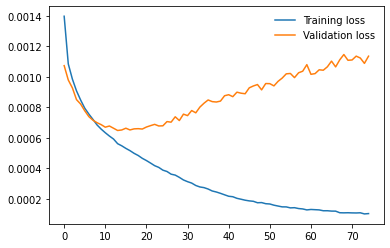

In [33]:
plt.plot(train_losses, label='Training loss')
plt.plot(test_losses, label='Validation loss')
plt.legend(frameon=False)

In [165]:
torchModel.Bert.device

device(type='cuda', index=0)

In [166]:
torchModel(X_test[:25])

Forward Called


tensor([[-1.4626, -1.5387, -1.6581,  5.5220, -1.1519, -1.9339, -0.4945],
        [-2.4869, -2.2417, -0.1596,  5.9095, -0.8429, -2.5162, -0.1103],
        [-2.2634, -1.6346,  0.2437,  5.0969, -1.4610, -0.9196,  0.4518],
        [-1.4876, -2.0991, -1.3574,  5.9189, -0.3710, -3.3775, -0.0616],
        [-1.9867, -2.1058, -0.8074,  5.6330, -0.1044, -3.1820, -0.1562],
        [-2.2982, -2.8106, -0.7049,  5.6376, -0.9757, -1.1950, -0.0750],
        [-1.3132, -0.8251, -0.8038,  4.2634, -0.0722, -2.5963,  0.0976],
        [-1.7288, -1.0971, -0.2127,  5.4893, -1.3920, -1.5332,  0.2278],
        [-2.0425, -1.3268, -1.0715,  5.6121, -0.3769, -1.5521,  0.0577],
        [-1.2958, -1.1475, -0.4645,  3.3163, -0.1179, -1.1458, -0.0809],
        [-2.9055, -2.2610, -0.9447,  6.2404, -0.8267, -2.1755,  0.2848],
        [-2.0705, -1.8187, -1.2083,  5.5571, -0.0396, -2.7881,  0.2048],
        [-1.7872, -2.5268, -1.0414,  4.4269, -0.7507, -0.7875,  0.1495],
        [-2.2243, -2.2796, -0.6230,  5.6976, -1.015

In [36]:
Y_pred = []
targets = []
for X_batch, labels in mMiniBatcherTest.getBatchIterator():
  
        X_batch = torch.tensor(X_batch).to(device)
        output = torchModelLight.predict(X_batch)
        Y_pred.extend(output)
        targets.extend(labels)


In [37]:
Y_pred = np.array(Y_pred)
targets = np.array(targets)

In [38]:
#Y_pred = torchModel.predict(X_test[200:300])
Y_pred

array([6, 2, 6, ..., 6, 2, 6], dtype=int64)

In [39]:
#targets = Y_test[200:300]
targets

array([6, 6, 4, ..., 6, 2, 6], dtype=int64)

In [80]:
testId = 21
print(Y_test[testId])
print(X_test.iloc[testId])

6
000000. kund ringer in, har råkat dubbelköpa en biljett i appen. xxxx biljett-id: pj0wpwz. gör ett återköp av den ena biljetten. kund får återköpskvitto.


In [40]:
accuracy = np.mean(Y_pred == targets)
print(f'Accuracy: {accuracy}')

Accuracy: 0.8919642857142858


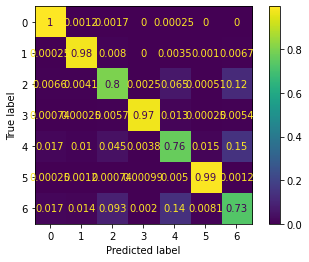

In [42]:
cm = confusion_matrix(targets, Y_pred, normalize='true', labels=list(set(targets)))
ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=list(set(targets))).plot()

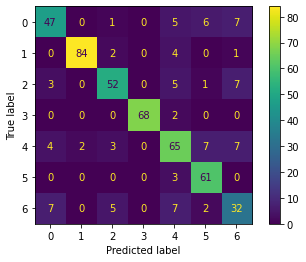

In [62]:
cm = confusion_matrix(targets, Y_pred, normalize=None, labels=list(set(Y_test)))
ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=list(set(Y_test))).plot()

In [43]:
torch.save(torchModelLight, 'torchModel_conv_batch_norm.pth')

In [33]:
for param_tensor in (torchModel.TorchModel.state_dict()):
    print(param_tensor, "\t", torchModel.TorchModel.state_dict()[param_tensor].size())

0.weight 	 torch.Size([256, 768])
0.bias 	 torch.Size([256])
3.weight 	 torch.Size([128, 256])
3.bias 	 torch.Size([128])
6.weight 	 torch.Size([7, 128])
6.bias 	 torch.Size([7])


In [44]:
torch.save(torchModelLight.TorchModel.state_dict(),'torchModel_conv_batch_norm_state_dict.pth')

In [21]:
torchModel =  torch.load('torchModel.pth', map_location=torch.device('cuda'))

In [16]:

n_classes = 7
torchModel = TorchNLP(n_classes)
torchModel.TorchModel.load_state_dict(torch.load('torchModel_state_dict.pth'))

Some weights of the model checkpoint at KB/bert-base-swedish-cased were not used when initializing BertModel: ['cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.decoder.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


<All keys matched successfully>

In [25]:
torchModel.eval()
torchModel.predict(X[:15])

array([5, 1, 5, 6, 4, 6, 5, 6, 6, 1, 6, 4, 4, 6, 2], dtype=int64)

In [24]:
Y[:15]

array([4, 6, 5, 4, 2, 6, 5, 4, 6, 4, 2, 6, 6, 6, 6], dtype=int64)

In [45]:
transformer = NLPTransformer()

Init called


Some weights of the model checkpoint at KB/bert-base-swedish-cased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [47]:
transformer.transform(testing)

Transform Called
Running batch 1/1
output shape: (1, 768)
transformed.shape: (1, 768)


array([[ 9.87884760e-01, -1.32418856e-01,  9.23658788e-01,
         9.53841284e-02,  5.00432737e-02, -1.74600735e-01,
        -6.13515228e-02, -8.26982021e-01, -8.38522017e-02,
        -9.93365169e-01,  6.42717481e-02, -3.05998195e-02,
         4.04555025e-03, -3.32312472e-02, -2.55960405e-01,
         8.80274400e-02,  2.30186395e-02,  1.60196766e-01,
         5.89367636e-02,  9.98809397e-01, -4.29829396e-02,
        -9.95216131e-01,  3.62579674e-02, -4.38297138e-04,
         2.73966137e-02, -8.72960865e-01,  7.15051591e-02,
        -9.36015248e-01,  2.12837279e-01, -9.79796946e-02,
        -4.70896997e-02, -7.83243418e-01, -9.90428030e-01,
         4.68692094e-01, -2.34113559e-01,  1.40514001e-01,
         1.79409549e-01,  3.13502923e-02, -7.68147185e-02,
        -5.33504598e-02,  1.49713665e-01,  8.09488297e-01,
        -1.73246086e-01, -8.50201309e-01,  9.99719203e-01,
        -1.37132853e-01,  9.39538836e-01,  7.69650459e-01,
         1.41458228e-01, -1.47941232e-01, -6.37947395e-0

In [54]:
next(torchModelLight.parameters()).is_cuda#torchModelLight.TorchModel.parameters

True

In [65]:
def MakePredictions(X, model, transformer, classes = None):
    
    #Check model device
    #modelOnCuda = next(torchModelLight.parameters()).is_cuda
    
    #Make sure both model and inputs are on the same device
    cuda_enabled = torch.cuda.is_available()
    if cuda_enabled:
        device = torch.device('cuda')
    else:
        device = torch.device('cpu')
    
    model.to(device)
    
    
    X = transformer.transform(X) #Output is numpy array
    X = torch.tensor(X).to(device)
    output = model.predict(X)
    
    if classes is not None:
        output = [classes[i] for i in output]
    
    return output
    

In [66]:
classes = ['Avvikelse', 'Beröm', 'Fråga', 'Förseningsersättning', 'Klagomål',
       'Skada', 'Synpunkt/Önskemål']

In [101]:
testing = pd.Series(data={'Beskrivning_Anonymized':'Ni har världens bästa utvecklare. Måste bara säga det :)'})


In [102]:
MakePredictions(testing, torchModelLight, transformer, classes)

Transform Called
Running batch 1/1
output shape: (1, 768)
transformed.shape: (1, 768)


['Beröm']

In [150]:
output = torchModel.predict(testing)
output


array([2], dtype=int64)

In [57]:
classes[output[0]]

NameError: name 'classes' is not defined

In [152]:
Y

array([1, 2, 6, ..., 1, 0, 4], dtype=int64)

In [130]:
classes

Index(['Avvikelse', 'Beröm', 'Fråga', 'Förseningsersättning', 'Klagomål',
       'Skada', 'Synpunkt/Önskemål'],
      dtype='object')

In [42]:
#Evaluate loaded model on full dataset
mMiniBatcherFull = MiniBatcher(X[:50000], Y[:50000], batch_size=100)

In [ ]:
Y_pred = []
targets = []
for X_batch, labels in mMiniBatcherFull.getBatchIterator():
  
        output = torchModel.predict(X_batch)
        Y_pred.extend(output)
        targets.extend(labels)
        print(mMiniBatcherFull.getBatchInfo())

batch: 1/500
batch: 2/500
batch: 3/500
batch: 4/500
batch: 5/500
batch: 6/500
batch: 7/500
batch: 8/500
batch: 9/500
batch: 10/500
batch: 11/500
batch: 12/500
batch: 13/500
batch: 14/500
batch: 15/500
batch: 16/500
batch: 17/500
batch: 18/500
batch: 19/500
batch: 20/500
batch: 21/500
batch: 22/500
batch: 23/500
batch: 24/500
batch: 25/500
batch: 26/500
batch: 27/500
batch: 28/500


In [ ]:
accuracy = np.mean(Y_pred == targets)
print(f'Accuracy: {accuracy}')

In [ ]:
cm = confusion_matrix(targets, Y_pred, normalize='true', labels=list(set(Y_test)))
ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=list(set(Y_test))).plot()

In [ ]:
cm = confusion_matrix(targets, Y_pred, normalize=None, labels=list(set(Y_test)))
ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=list(set(Y_test))).plot()

In [44]:

list(range(Y_test.columns.shape[0]))

[0, 1, 2, 3, 4, 5, 6]